In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
import glob, json
import numpy as np
import pandas as pd
import s4_authors_stats as s4
import dask.dataframe as dd
import matplotlib.pyplot as plt
from scipy.stats import rankdata
from scipy.stats import pearsonr, spearmanr
from matplotlib.colors import LogNorm

from functools import partial
from multiprocessing import Pool

In [7]:
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)
NCOLS = 4
SUFFIX = 2020
SUFFIX_STR = '_%d' % SUFFIX

In [247]:
# pairs_authors_dd = dd.read_csv('data/pair_csv_%d_byAuthorIDprocessed_pairs.csv' % SUFFIX, sep='\t', header=None, names=['author_id', 'cits'])
pairs_authors_dd = dd.read_csv('data/PairAuthors2csv_split/pair_csv_year_%d*' % SUFFIX, sep='\t', header=None, names=['author_id', 'cits'])
pairs_authors_dd = pairs_authors_dd.set_index('author_id', sorted=True)
pairs_authors_dd.head()

cits
author_id                                                   
5211       {"1141255472": [14], "1970691061": [0, 0, 1, 4...
6478       {"1088438710": [43], "1238614089": [94], "1278...
11720      {"1214880279": [23, 35, 41, 24], "1250321752":...
15251      {"105506866": [93], "1061427020": [33, 93], "1...
16490      {"1156106740": [10, 2, 23, 24], "1355423769": ...

In [248]:
authors_infos = dd.read_csv('data/authors_infos_full_final_%d' % SUFFIX, sep='\t', header=None, 
                            names=['author_id', 'birth_year', 'citation_count'])
authors_infos = authors_infos.set_index('author_id', sorted=True)
authors_infos.head()

birth_year                                     citation_count
author_id                                                               
5211             2005  [0, 96.0, 40.0, 46.0, 69.0, 24.0, 13.0, 43.0, ...
6478             1994  [43.0, 3.0, 0, 1.0, 6.0, 22.0, 1.0, 21.0, 0, 1...
11720            1999  [2.0, 42.0, 2.0, 17.0, 29.0, 14.0, 0, 17.0, 42...
15251            1995  [69.0, 38.0, 23.0, 65.0, 93.0, 0, 70.0, 43.0, ...
16490            1998  [0, 1.0, 0, 0, 6.0, 0, 2.0, 0, 1.0, 0, 0, 0, 5...

In [249]:
pairs_authors_dd2 = pairs_authors_dd.merge(authors_infos, left_index=True, right_index=True)
pairs_authors_dd2.head()

cits  birth_year  \
author_id                                                                  
5211       {"1141255472": [14], "1970691061": [0, 0, 1, 4...        2005   
6478       {"1088438710": [43], "1238614089": [94], "1278...        1994   
11720      {"1214880279": [23, 35, 41, 24], "1250321752":...        1999   
15251      {"105506866": [93], "1061427020": [33, 93], "1...        1995   
16490      {"1156106740": [10, 2, 23, 24], "1355423769": ...        1998   

                                              citation_count  
author_id                                                     
5211       [0, 96.0, 40.0, 46.0, 69.0, 24.0, 13.0, 43.0, ...  
6478       [43.0, 3.0, 0, 1.0, 6.0, 22.0, 1.0, 21.0, 0, 1...  
11720      [2.0, 42.0, 2.0, 17.0, 29.0, 14.0, 0, 17.0, 42...  
15251      [69.0, 38.0, 23.0, 65.0, 93.0, 0, 70.0, 43.0, ...  
16490      [0, 1.0, 0, 0, 6.0, 0, 2.0, 0, 1.0, 0, 0, 0, 5...

In [250]:
header = '/mnt/e/MAG/mag-2021-01-05/advanced/'
fields_infos = 'FieldsOfStudy.txt'
fos_infos = pd.read_csv(header+fields_infos, header=None, sep='\t')[[0, 1, 2]]
fos_infos.columns = ['field_id', 'rank', 'normalized_name']

In [251]:
authors_fos = dd.read_csv('data/authors_weights_year_%d_unfied_fos.csv' % SUFFIX, sep='\t', header=None, 
                          names=['author_id', 'weights', 'fos'], dtype={'fos':int})
# authors_fos = authors_fos.set_index('author_id', sorted=True)
print(authors_fos.head(5))

# rows_nan = authors_fos.isnull().any(axis=1)
# rows_with_nan = authors_fos[rows_nan]
# rows_with_nan

   author_id                                            weights        fos
0        584  {"15744967": 2.772012987012987, "71924100": 0....   15744967
1        859                                 {"121332964": 1.0}  121332964
2        978  {"138885662": 3.64297619047619, "142362112": 3...  138885662
3       1139  {"142362112": 1.5366666666666666, "138885662":...  142362112
4       1799  {"86803240": 0.9756349206349206, "185592680": ...   86803240


In [252]:
authors_complete = pairs_authors_dd2.merge(authors_fos, on='author_id')
authors_complete.head(5)

author_id                                               cits  birth_year  \
0  2137821847  {"1231495105": [77], "2043320824": [26], "2046...        1983   
1  2137930475  {"1916000741": [49], "1966228128": [85], "2021...        1998   
2  2137948843  {"1881428358": [0, 127, 2, 35, 3, 3, 3, 56], "...        1978   
3  2061367082  {"1263594521": [13], "2062115068": [56], "2086...        1953   
4  2062130630  {"148013605": [0, 1], "1576900243": [173, 78],...        2007   

                                      citation_count  \
0  [8.0, 10.0, 70.0, 25.0, 18.0, 13.0, 12.0, 3.0,...   
1  [0, 0, 0, 0, 0, 0, 114.0, 2.0, 49.0, 0, 85.0, ...   
2  [35.0, 89.0, 56.0, 127.0, 3.0, 10.0, 5.0, 5.0,...   
3  [13.0, 3.0, 39.0, 2.0, 1.0, 8.0, 4.0, 2.0, 56....   
4  [0, 1.0, 51.0, 0, 1.0, 13.0, 173.0, 3.0, 14.0,...   

                                             weights        fos  
0  {"185592680": 4.837021404521406, "86803240": 1...   86803240  
1  {"121332964": 43.522088351463346, "33923547": ...  121332964  
2  {"127413603": 0.3974747474747475, "121332964":...   15744967  
3  {"162324750": 0.09839466089466088, "144133560"...   71924100  
4  {"127413603": 0.9502272727272726, "41008148": ...   41008148

In [253]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    authors_complete.to_csv('data/AuthorsMetrics_split/authors_metrics_full_%d' % SUFFIX, sep='\t', header=None, index=None, single_file=True)

[########################################] | 100% Completed | 39min 10.1s


In [13]:
from s4_authors_stats import _step_1

authors_complete = dd.read_csv('data/AuthorsMetrics_split/authors_metrics_full_%d' % SUFFIX, sep='\t', header=None)
authors_complete.columns = ['author_id', 'cits', 'birth_year', 'citation_count', 'weights', 'fos']

def sum_cits(row):
    c = sum(json.loads(row['citation_count']))
    return c

authors_complete = authors_complete[authors_complete.apply(sum_cits, meta=(int), axis=1) > 0]
authors_complete.head()
# print(authors_complete.head())

author_id                                               cits  birth_year  \
0  2108107264  {"1900077484": [38], "1924117682": [21], "1994...        2014   
1  2108140143  {"1968057827": [0, 2, 0, 0, 0, 17, 26, 2], "19...        2010   
2  2107896124  {"1743078665": [0, 0, 16, 56], "2012773138": [...        1964   
3  2137821847  {"1231495105": [77], "2043320824": [26], "2046...        1983   
4  2137930475  {"1916000741": [49], "1966228128": [85], "2021...        1998   

                                      citation_count  \
0  [52.0, 35.0, 38.0, 0, 21.0, 36.0, 18.0, 0, 17....   
1  [9.0, 0, 0, 0, 2.0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2  [7.0, 24.0, 32.0, 157.0, 14.0, 22.0, 74.0, 22....   
3  [8.0, 10.0, 70.0, 25.0, 18.0, 13.0, 12.0, 3.0,...   
4  [0, 0, 0, 0, 0, 0, 114.0, 2.0, 49.0, 0, 85.0, ...   

                                             weights        fos  
0  {"121332964": 1.9564923039923037, "127413603":...  185592680  
1  {"121332964": 4.454854845446951, "41008148": 3...  127313418  
2  {"185592680": 6.845343822843821, "86803240": 2...   86803240  
3  {"185592680": 4.837021404521406, "86803240": 1...   86803240  
4  {"121332964": 43.522088351463346, "33923547": ...  121332964

In [15]:
header = '/mnt/e/MAG/mag-2021-01-05/advanced/'
fields_infos = 'FieldsOfStudy.txt'
fos_infos = pd.read_csv(header+fields_infos, header=None, sep='\t')[[0, 1, 2]]
fos_infos.columns = ['field_id', 'rank', 'normalized_name']

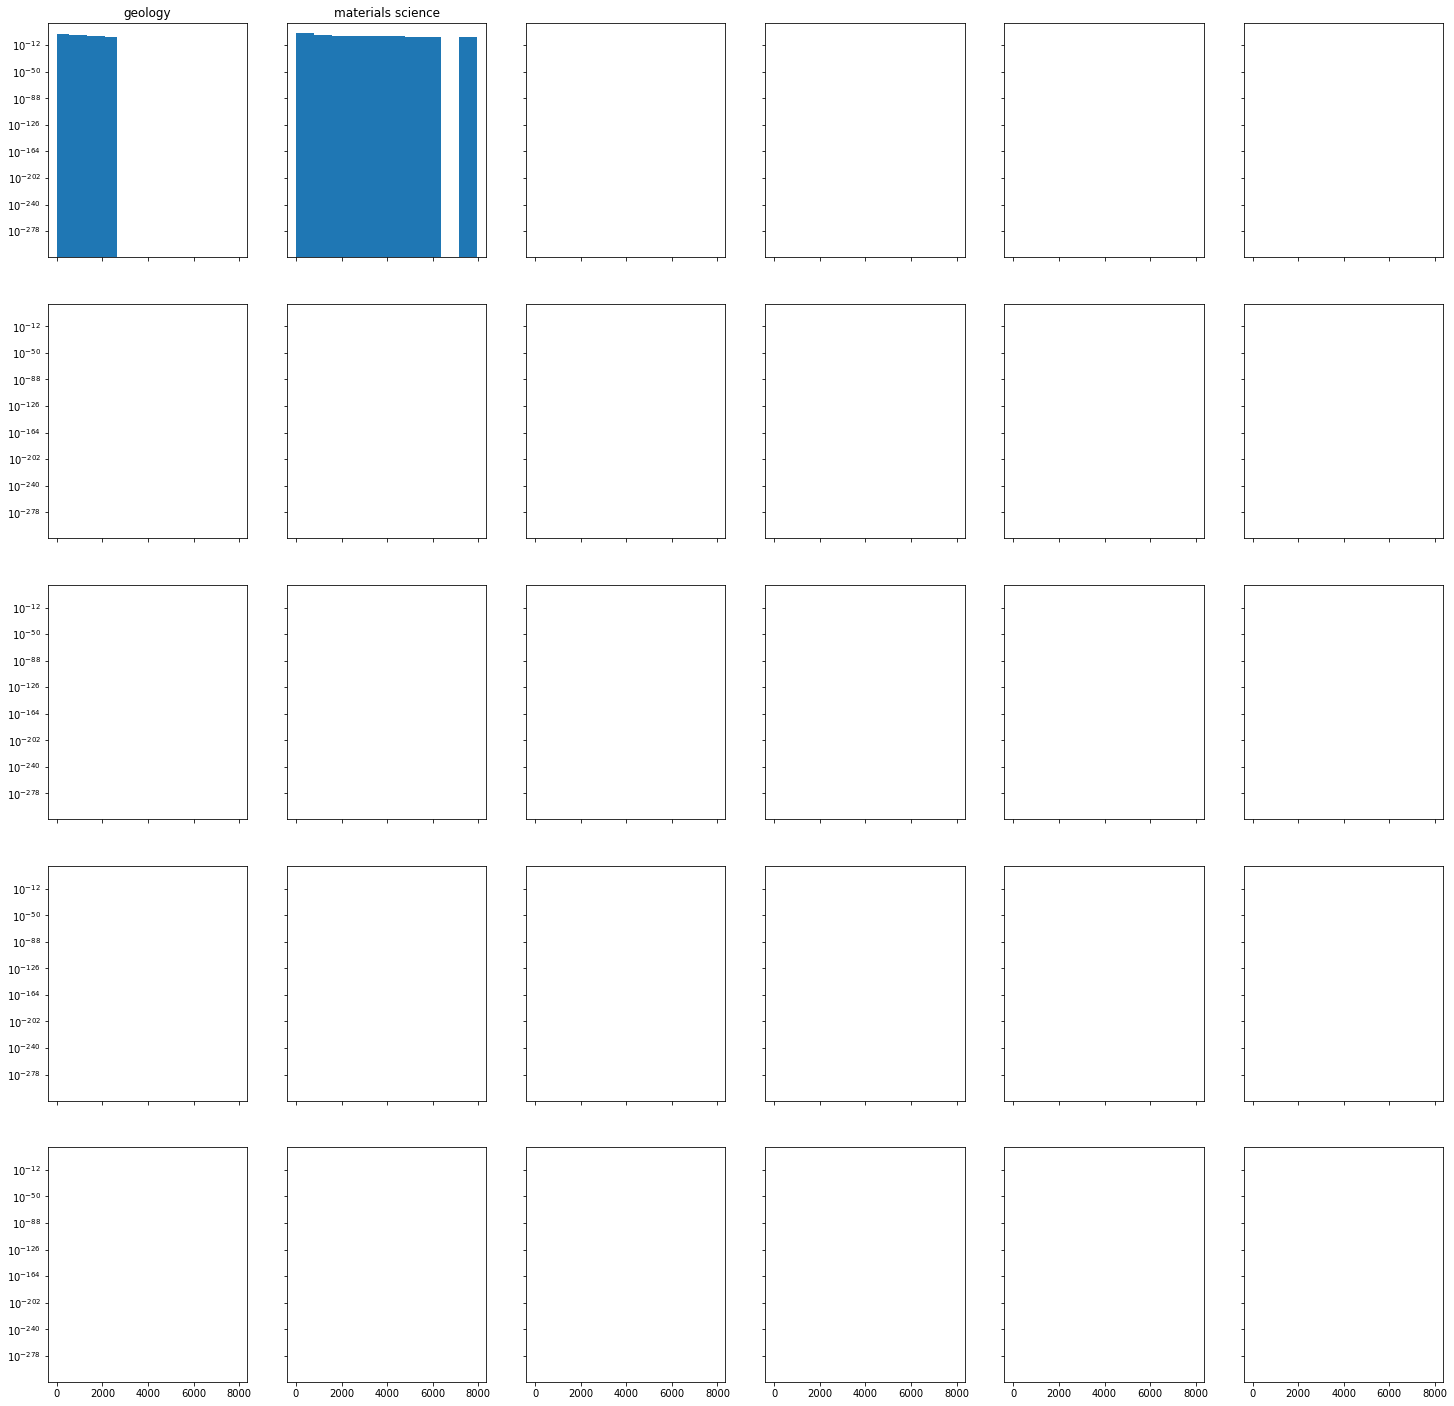

In [20]:
def cit_count(bla):
    return bla.apply(lambda x: x.cits.count('['), meta=(int), axis=1)
    
colabs_per_author = authors_complete.assign(n_authors=cit_count)[['author_id', 'fos', 'n_authors']]

print(colabs_per_author.head())

results = colabs_per_author.groupby('fos')['n_authors'].apply(list, meta=('n_authors_per_fos', object))

fig,axes = plt.subplots(figsize=(25, 25), nrows=5, ncols=6, sharex=True, sharey=True)
i = 0
axes = axes.ravel()
for field, fos_dist in results.iteritems():
    axes[i].hist(fos_dist)
    field_name = fos_infos[fos_infos['field_id'] == field].iloc[0, -1]
    print(field_name)
    axes[i].set_title(field_name)
    i += 1
    
plt.savefig('number_of_colabs_per_fos_%d.pdf' % SUFFIX)

In [ ]:
# h_index, cits, n_papers, birth, max_ws, max_colabs, citation_list, colabs_cit_list, authors_id = s4.step_1(pairs_authors_dd)
# with ProgressBar():
#     s4.step_1(authors_complete).to_csv('data/AuthorsMetrics_split/authors_v2_metrics_*', sep='\t', header=None)

H, C, P, WS, WP, CL, Y, CH, FOS = s4.step_1(authors_complete)

In [256]:
# open('results/hindex_full_%d.json' % SUFFIX,'w').write(json.dumps(H))
# open('results/cits_full_%d.json' % SUFFIX,'w').write(json.dumps(C))
# open('results/papers_full_%d.json' % SUFFIX,'w').write(json.dumps(P))
# open('results/ws_full_%d.json' % SUFFIX,'w').write(json.dumps(WS))
# open('results/wp_full_%d.json' % SUFFIX,'w').write(json.dumps(WP))
# open('results/citlist_full_%d.json' % SUFFIX,'w').write(json.dumps(CL))
# open('results/birth_full_%d.json' % SUFFIX, 'w').write(json.dumps(Y))
# open('results/fos_full_%d.json' % SUFFIX,'w').write(json.dumps(FOS))
# open('results/ch_full_%d.json' % SUFFIX, 'w').write(json.dumps(CH))

455415883

In [11]:
H = json.load(open('results/hindex_full_%d.json' % SUFFIX))
C = json.load(open('results/cits_full_%d.json' % SUFFIX))
P = json.load(open('results/papers_full_%d.json' % SUFFIX))
WS = json.load(open('results/ws_full_%d.json' % SUFFIX))
WP = json.load(open('results/wp_full_%d.json' % SUFFIX))
CL = json.load(open('results/citlist_full_%d.json' % SUFFIX))
Y = json.load(open('results/birth_full_%d.json' % SUFFIX))
CH = json.load(open('results/ch_full_%d.json' % SUFFIX))
FOS = json.load(open('results/fos_full_%d.json' % SUFFIX))

unique = np.unique(FOS)

H = np.asarray(H)
C = np.asarray(C)
P = np.asarray(P)
WS = np.asarray(WS)
WP = np.asarray(WP)
CL = np.asarray(CL)
Y = np.asarray(Y)
CH = np.asarray(CH)
FOS = np.asarray(FOS)
#TODO ajeitar o HINDEX pra rank funcionar

/home/acmbrito/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [22]:
for current_year in [1960, 1970, 1980, 1990, 2000, 2010, 2020]:
    colabs_cits = json.load(open('results/citlist_full_%d.json' % current_year))
    count_no_colabs = 0
    for temp in colabs_cits:
        if len(temp) == 0:
            count_no_colabs += 1
    print("%d & %.2f\%% & %d" % (current_year, 100*count_no_colabs/len(colabs_cits), count_no_colabs))

1960 & 1.46\% & 560
1970 & 0.95\% & 1171
1980 & 0.64\% & 2138
1990 & 0.40\% & 3057
2000 & 0.20\% & 3085
2010 & 0.06\% & 1525
2020 & 0.02\% & 247


In [97]:
fos_infos[fos_infos['normalized_name'] == 'history']

field_id  rank normalized_name
18012  95457728  6708         history

In [12]:
def fos_sort(max_ws, fos):
    values = []
    fs = []
    count = []
    for field in unique:
        group = max_ws[fos == field]
        if len(group) < 500:
            continue
        median = np.percentile(group, 50)
        fs.append(field)
        values.append(median)
        count.append(len(group))
    values = np.asarray(values)
    fs = np.asarray(fs)
    count = np.asarray(count)
    idxs = np.argsort(values)
    values = values[idxs]
    fs = fs[idxs]
    count = count[idxs]
    
    return fs, count

In [25]:
fos_sorted, _ = fos_sort(WS, FOS)
fos_sorted

array([ 95457728, 142362112, 138885662, 144024400,  17744445, 162324750,
        33923547, 144133560, 127313418,  15744967, 205649164,  39432304,
        41008148, 127413603, 121332964,  71924100,  86803240, 185592680,
       192562407])

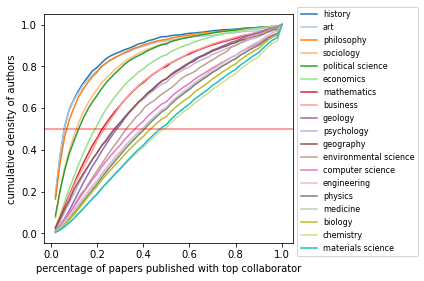

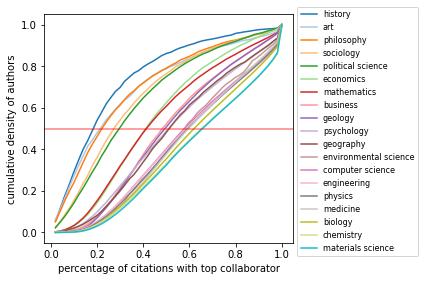

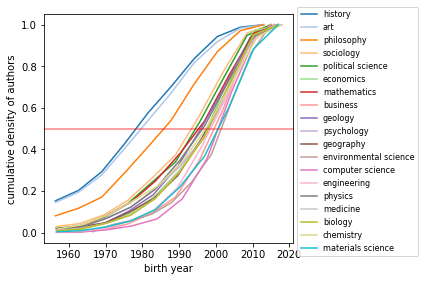

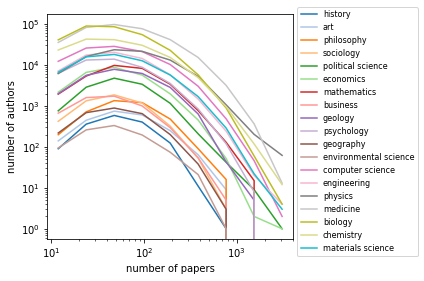

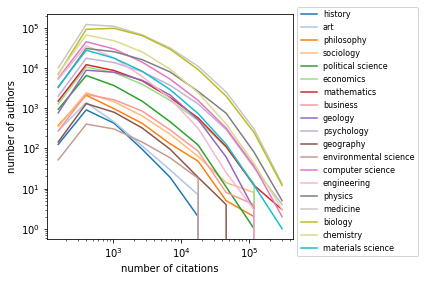

In [26]:
def plot_hist(fig, group, bins, field_name, cumulative):
    y,x = np.histogram(group, bins=bins)
    if cumulative:
        y = np.cumsum(y)
        fig.plot(x[1:], y/y[-1], label=field_name)
    else:
        bins_center = 0.5*(x[:-1]+x[1:])
        fig.plot(bins_center,y, label=field_name)
    
def basic_hist(unique, fos, data, key, suffix, bins, yscale=None, xscale=None, cumulative=False):
    fig, ax = plt.subplots()
    
    for field in unique:
        group = data[fos == field]
        field_name = fos_infos[fos_infos['field_id'] == field].iloc[0, -1]
        plot_hist(ax, group, bins, field_name, cumulative)

    ax.legend(bbox_to_anchor=(1.0, 1.05), prop={'size': 8})
    if cumulative:
        ax.axhline(0.5, xmin=0, xmax=1, color='red', alpha=0.5)
    if yscale:
        ax.set_yscale(yscale)
    if xscale:
        ax.set_xscale(xscale)
    ax.set_title(labels_description[key]['title'])
    ax.set_xlabel(labels_description[key]['x'])
    ax.set_ylabel(labels_description[key]['y'])
    fig.subplots_adjust(right=0.2)
    fig.tight_layout()
    fig.savefig('outputs/fos_hist_%s%s.pdf' % (key,suffix))
    fig.show()

labels_description = {
    'max_colabs': {'x': 'percentage of papers published with top collaborator', 'y': 'cumulative density of authors', 'title': ''},
    'max_ws': {'x': 'percentage of citations with top collaborator', 'y': 'cumulative density of authors', 'title': ''},
    'birth': {'x': 'birth year', 'y': 'cumulative density of authors', 'title': ''},
    'papers': {'x': 'number of papers', 'y': 'number of authors', 'title': ''},
    'total_cits': {'x': 'number of citations', 'y': 'number of authors', 'title': ''} 
}    

basic_hist(fos_sorted, FOS, WP, 'max_colabs', suffix=SUFFIX_STR, bins=50, cumulative=True) # papers
basic_hist(fos_sorted, FOS, WS, 'max_ws', suffix=SUFFIX_STR, bins=50, cumulative=True) # citações
basic_hist(fos_sorted, FOS, Y, 'birth', suffix=SUFFIX_STR, bins=10, cumulative=True)
xspace = np.logspace(np.log10(min(P)), np.log10(max(P)), 10)
basic_hist(fos_sorted, FOS, P, 'papers', suffix=SUFFIX_STR, bins=xspace, yscale='log', xscale='log')
xspace = np.logspace(np.log10(min(C)), np.log10(max(C)), 10)
basic_hist(fos_sorted, FOS, C, 'total_cits', suffix=SUFFIX_STR, bins=xspace, yscale='log', xscale='log')

In [27]:
def get_rows_cols(unique):
    N = len(unique)
    if N % NCOLS == 0:
        rows = N//NCOLS
    else:
        rows = N//NCOLS + 1
    cols = NCOLS
    return rows,cols

In [28]:
def _hist2d(ax, xgroup, ygroup, xspace, yspace, field_name): 
    ax.set_facecolor("black")
    im = ax.hist2d(xgroup, ygroup, bins=(xspace, yspace), cmap='inferno', norm=LogNorm()) #vmin=1,vmax=10000))
    ax.set_title("%s \nspearman=%.2f \npearson=%.2f" % (field_name, spearmanr(xgroup, ygroup)[0], pearsonr(xgroup, ygroup)[0]))
    return im

    
def hist2d(unique, fos, xdata, ydata, xkey, ykey, suffix, xbins, ybins, yscale=None, xscale=None):
    rows,cols = get_rows_cols(unique)
    print(rows,cols)
    fig, axs = plt.subplots(figsize=(3*cols, 3*rows), nrows=rows, ncols=cols, sharex=True, sharey=True)
    i = 0
    for field in unique:
        xgroup = xdata[fos == field]
        ygroup = ydata[fos == field]
        ax = axs[int(i/cols)][i%cols]
        
        field_name = fos_infos[fos_infos['field_id'] == field].iloc[0, -1]
        im = _hist2d(ax, xgroup, ygroup, xbins, ybins, field_name=field_name)
        
        if yscale:
            ax.set_yscale(yscale)
        if xscale:
            ax.set_xscale(xscale)
    
        if i%cols == 0: 
            ax.set_ylabel(ykey)
        if int(i/cols) == rows-1:    
            ax.set_xlabel(xkey)
        
        
    
        fig.colorbar(im[3], ax=ax)
        
        i += 1
    empty_plots = len(unique)%cols
    if empty_plots != 0: 
        for i in range(empty_plots,cols):
            axs[-1,i].axis('off')
    fig.tight_layout()
    fig.savefig('outputs/fos_hist2d_%s_%s%s.pdf' % (xkey, ykey, suffix))
    fig.show()
    

5 4


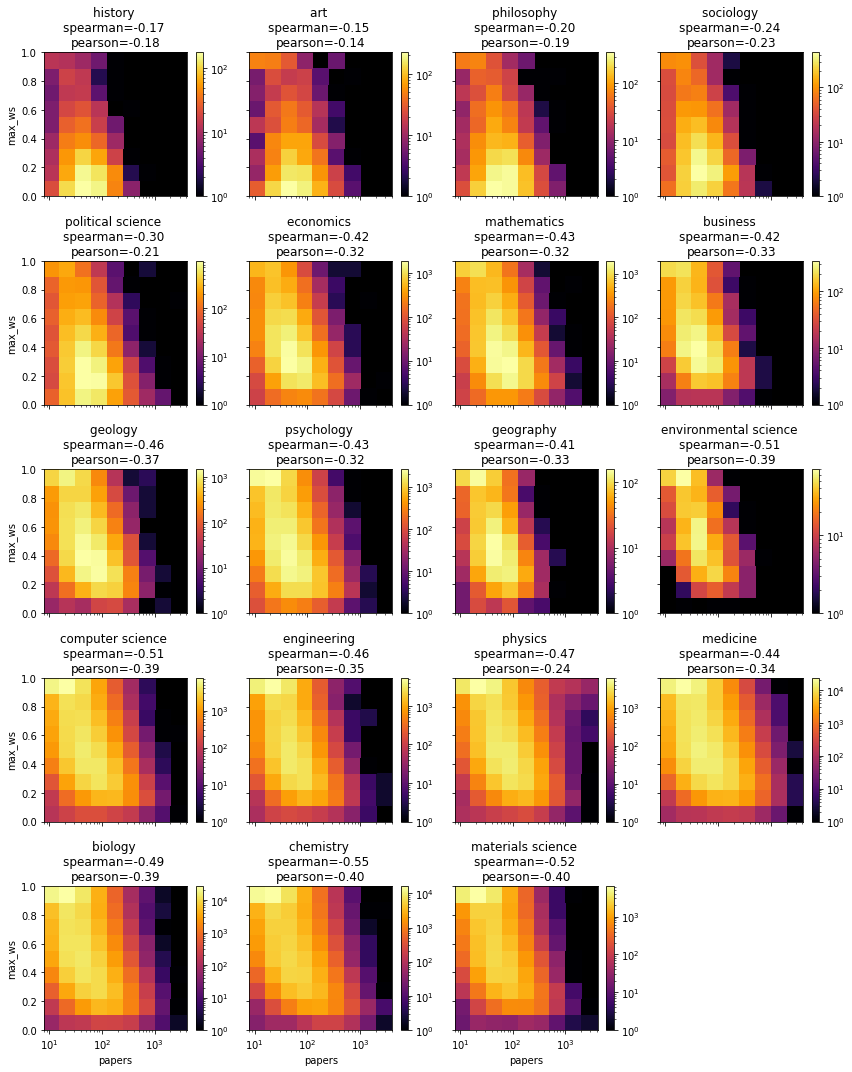

In [29]:
xbins = np.logspace(np.log10(min(P)), np.log10(max(P)+1), 10)
ybins = np.linspace(min(WS), max(WS), 10)
hist2d(fos_sorted, FOS, P, WS, 'papers', 'max_ws', SUFFIX, xbins=xbins, ybins=ybins, xscale='log', yscale=None)

5 4


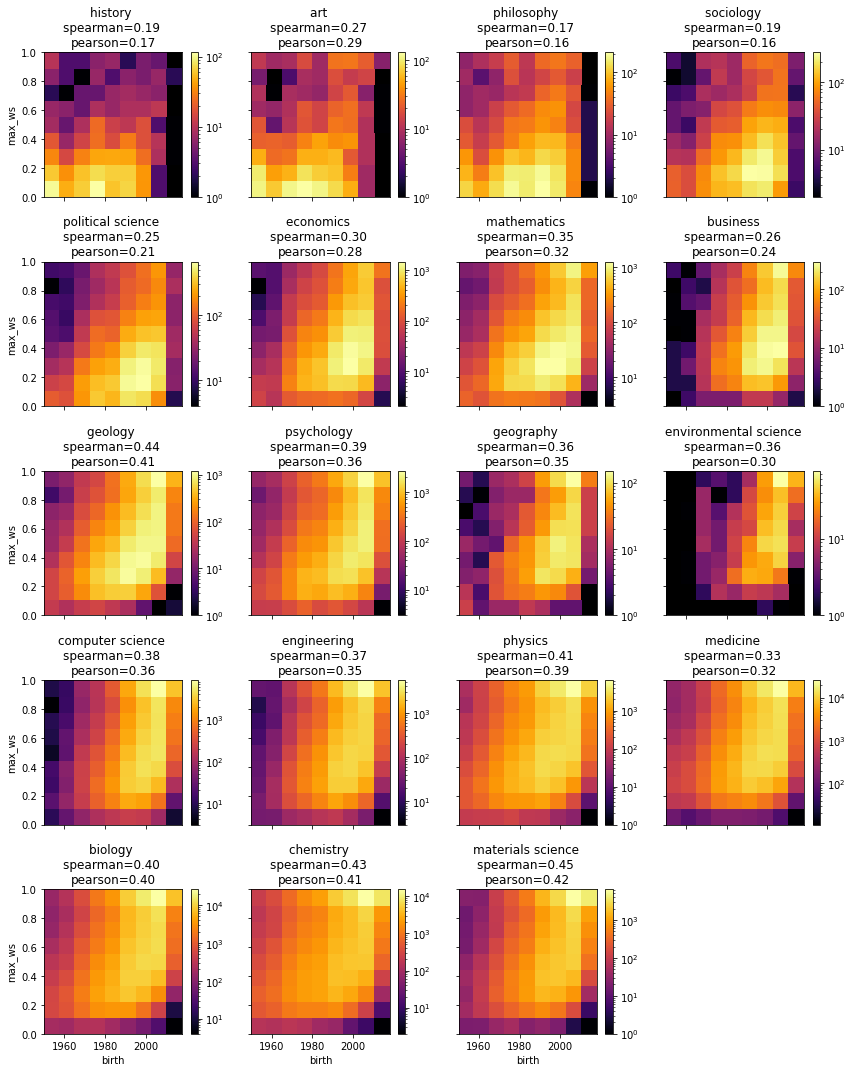

In [30]:
xbins = np.linspace(min(Y), max(Y), 10)
ybins = np.linspace(min(WS), max(WS), 10)
hist2d(fos_sorted, FOS, Y, WS, 'birth', 'max_ws', suffix=SUFFIX, xbins=xbins, ybins=ybins, xscale=None, yscale=None)

5 4


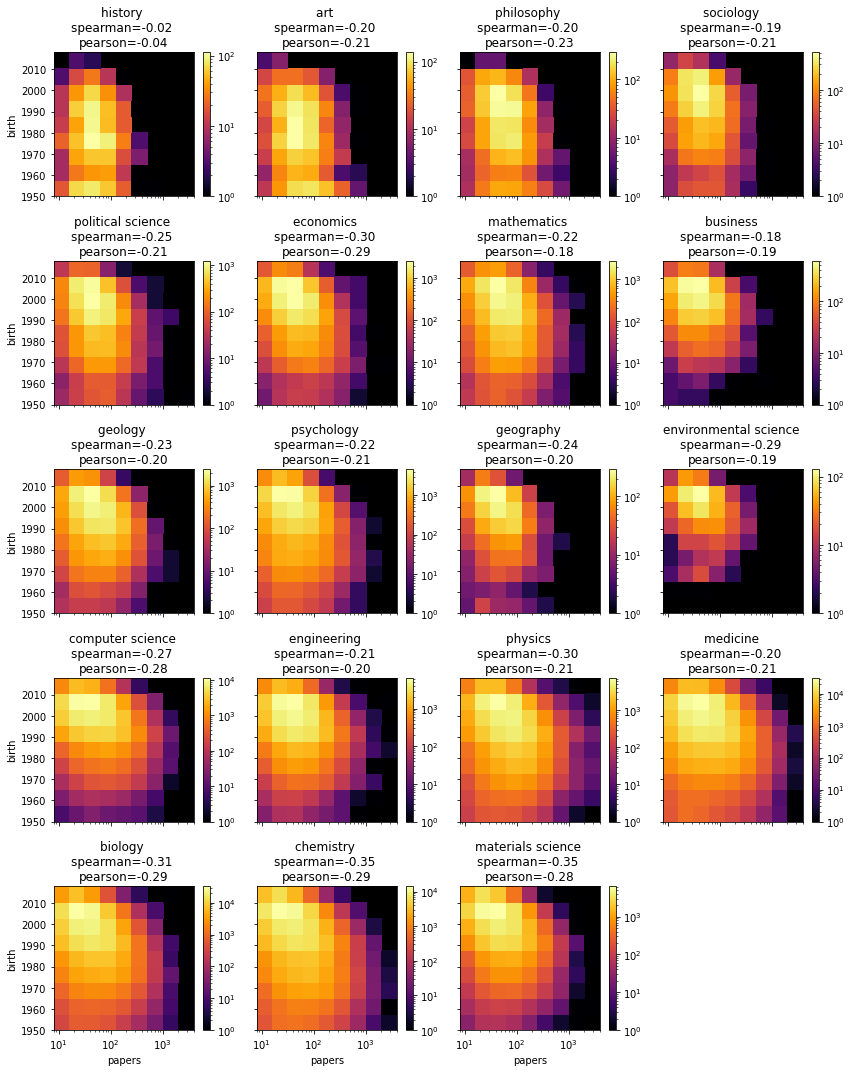

In [31]:
xbins = np.logspace(np.log10(min(P)), np.log10(max(P)+1), 10)
ybins = np.linspace(min(Y), max(Y), 10)
hist2d(fos_sorted, FOS, P, Y, 'papers', 'birth', suffix=SUFFIX, xbins=xbins, ybins=ybins, xscale='log', yscale=None)

5 4


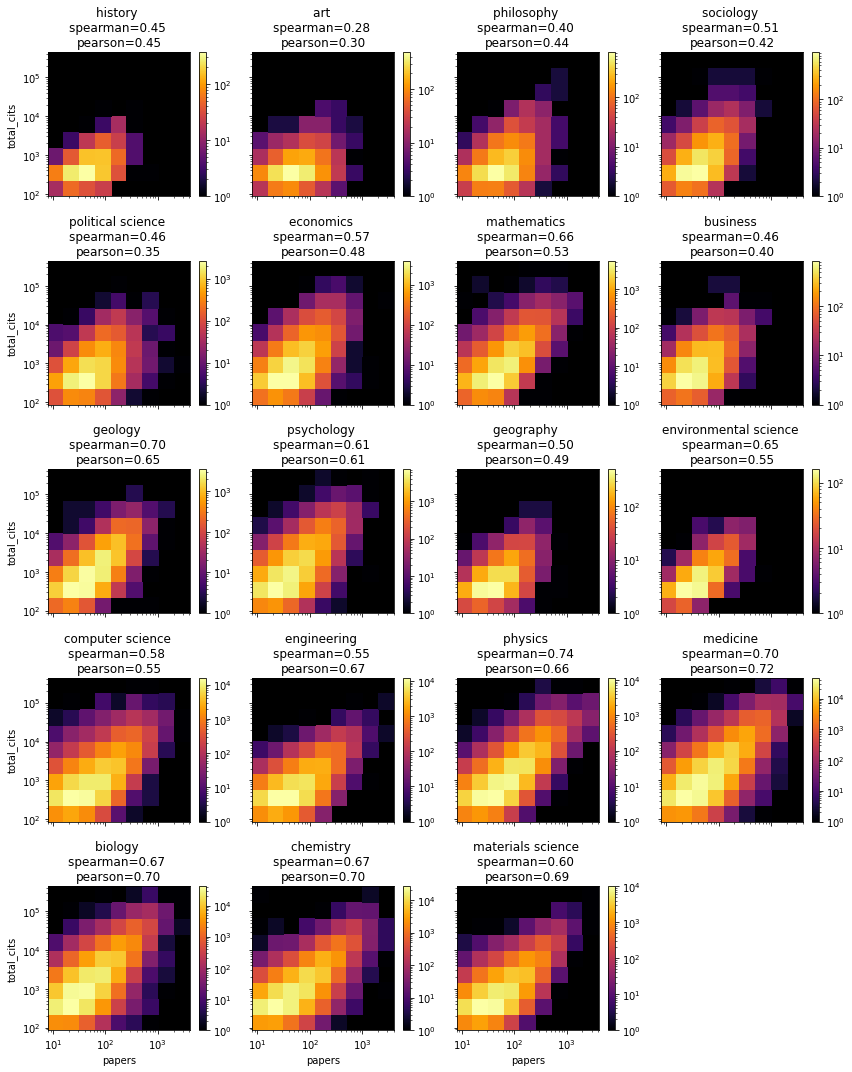

In [32]:
xbins = np.logspace(np.log10(min(P)), np.log10(max(P)+1), 10)
ybins = np.logspace(np.log10(min(C)), np.log10(max(C)+1), 10)
hist2d(fos_sorted, FOS, P, C, 'papers', 'total_cits', suffix=SUFFIX, xbins=xbins, ybins=ybins, xscale='log', yscale='log')

5 4


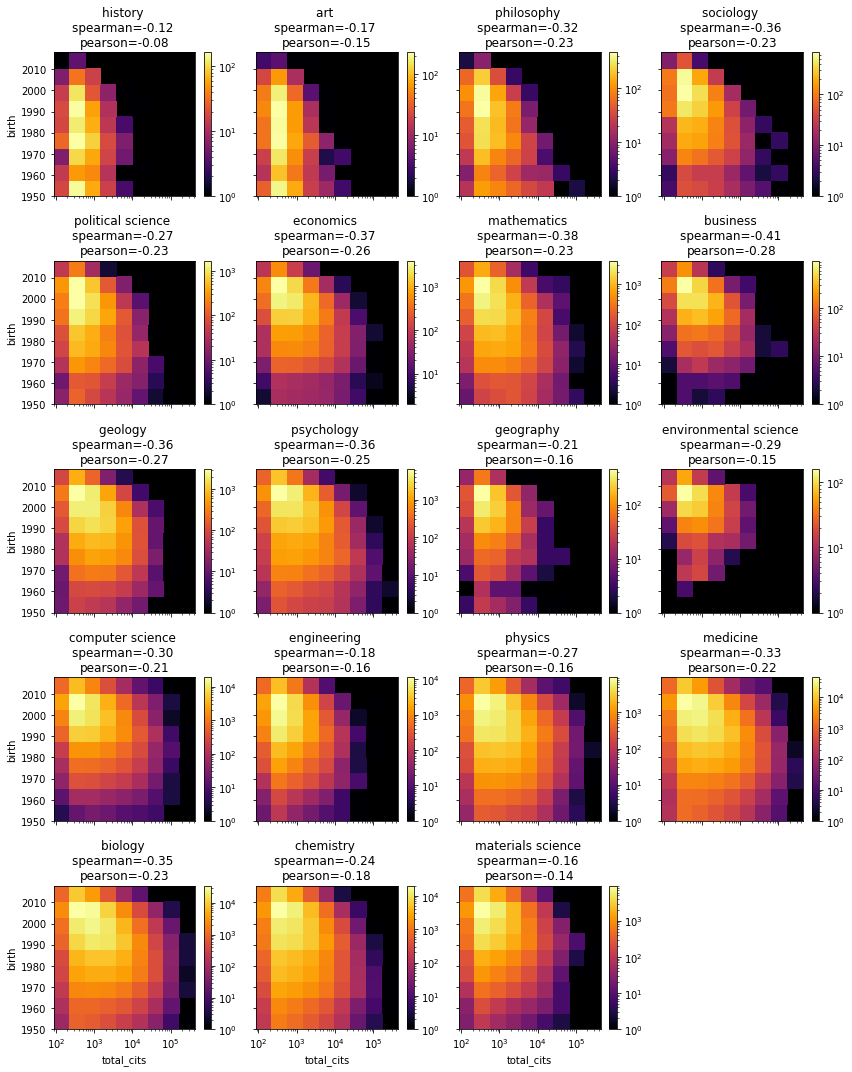

In [33]:
xbins = np.logspace(np.log10(min(C)), np.log10(max(C)+1), 10)
ybins = np.linspace(min(Y), max(Y), 10)
hist2d(fos_sorted, FOS, C, Y, 'total_cits', 'birth', suffix=SUFFIX, xbins=xbins, ybins=ybins, xscale='log', yscale=None)

In [34]:
def generic_before_after(suffix, _metric_before_after, xlabel, ylabel, outputname):
    rows,cols = get_rows_cols(fos_sorted)
    fig, axs = plt.subplots(figsize=(3*cols, 2.7*rows), nrows=rows, ncols=cols) #, sharex=True, sharey=True)
    
    i = 0
    hafter_map = {}
    for field in fos_sorted:
        group = (FOS == field)
        ax = axs[int(i/cols)][i%cols]
        
        field_name = fos_infos[fos_infos['field_id'] == field].iloc[0, -1]
        im, hafter = _metric_before_after(ax, group, field_name=field_name)
        hafter_map[field] = hafter
    
        if i%cols == 0: 
            ax.set_ylabel(ylabel)
        if int(i/cols) == rows-1:    
            ax.set_xlabel(xlabel)
        
        fig.colorbar(im[3], ax=ax)
        
        i += 1
    empty_plots = len(fos_sorted)%cols
    if empty_plots != 0:
        for i in range(empty_plots,cols):
            axs[-1,i].axis('off')
    
    fig.tight_layout()
    fig.savefig('outputs/fos_hist2d_before_after_%d_%s.pdf' % (suffix, outputname))
    fig.show()
    
    return hafter_map

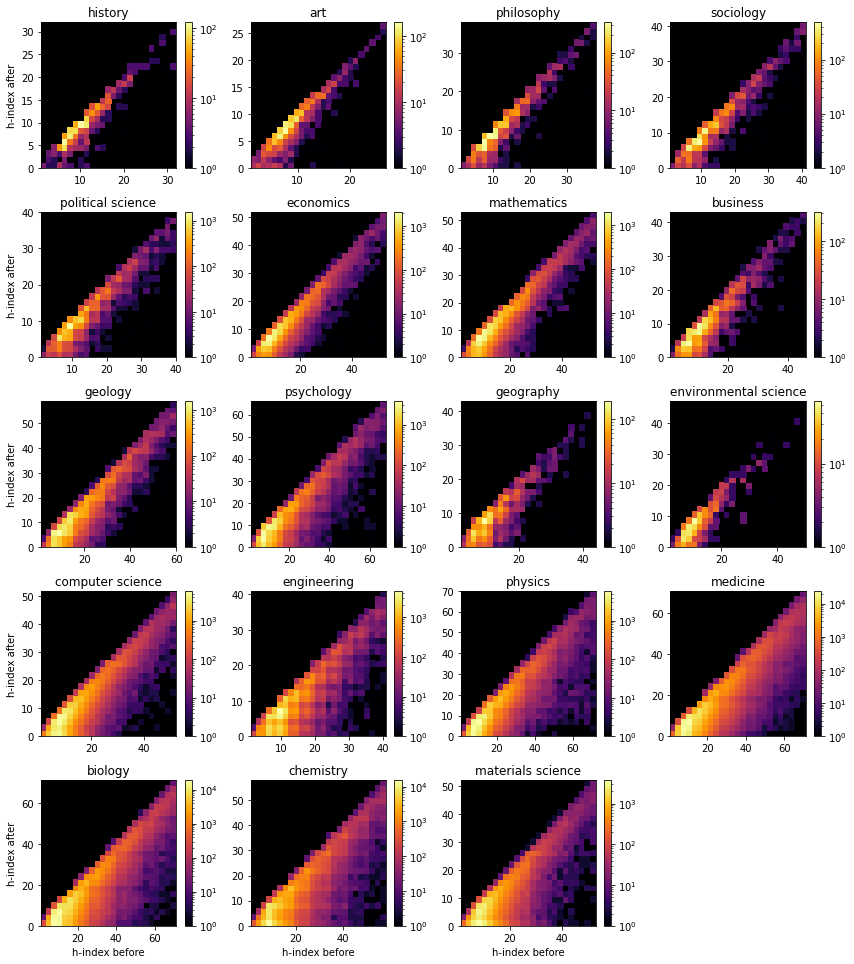

In [35]:
from s4_authors_stats import get_h_index

def _hindex_before_after(ax, idxs, field_name):
    valid_colabs_cit_list = CL[idxs]
    valid_citation_list = CH[idxs]
    valid_h_index = H[idxs]
    hindex_after = []
    
    for ccits, acits in zip(valid_colabs_cit_list, valid_citation_list):
        diff_cits = acits.copy() # json.loads(acits)
        for ctemp in ccits: # json.loads(ccits):
            diff_cits.remove(ctemp)
            
        hafter = get_h_index(diff_cits)
        hindex_after.append(hafter)
    
    hindex_before_l1 = np.asarray([row[0] for row in valid_h_index])
    hindex_after_l1 = np.asarray(hindex_after)[:,0]
    
    ax.set_facecolor("black")
    perc = np.percentile(hindex_before_l1, 99)
    im = ax.hist2d(hindex_before_l1[hindex_before_l1 <= perc], hindex_after_l1[hindex_before_l1 <= perc], 
           norm=LogNorm(), cmap='inferno', bins=(25, 25))
    ax.set_title(field_name)
    
    return im, hindex_after 

hafter_map = generic_before_after(SUFFIX, _hindex_before_after, 'h-index before', 'h-index after', 'hindex')

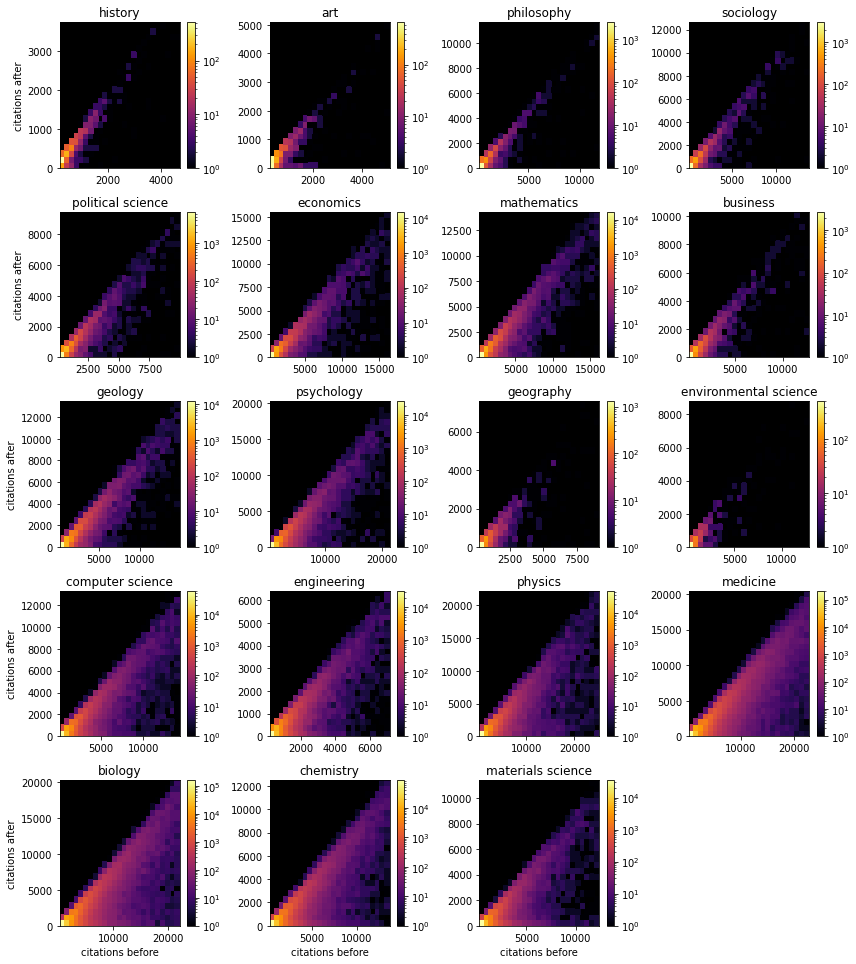

In [36]:
from s4_authors_stats import get_h_index

def _cits_before_after(ax, idxs, field_name):
    valid_colabs_cit_list = CL[idxs]
    valid_citation_list = CH[idxs]
    cits_before = []
    cits_after = []
    
    for ccits, acits in zip(valid_colabs_cit_list, valid_citation_list):
        before = sum(acits)
        after = before - sum(ccits)
        
        cits_before.append(before)    
        cits_after.append(after)
    
    cits_before = np.asarray(cits_before)
    cits_after = np.asarray(cits_after)
    
    ax.set_facecolor("black")
    perc = np.percentile(cits_before, 99)
    im = ax.hist2d(cits_before[cits_before <= perc], cits_after[cits_before <= perc], 
           norm=LogNorm(), cmap='inferno', bins=(25, 25))
    ax.set_title(field_name)
    
    return im, cits_after 

citsafter_map = generic_before_after(SUFFIX, _cits_before_after, 'citations before', 'citations after', 'citations')

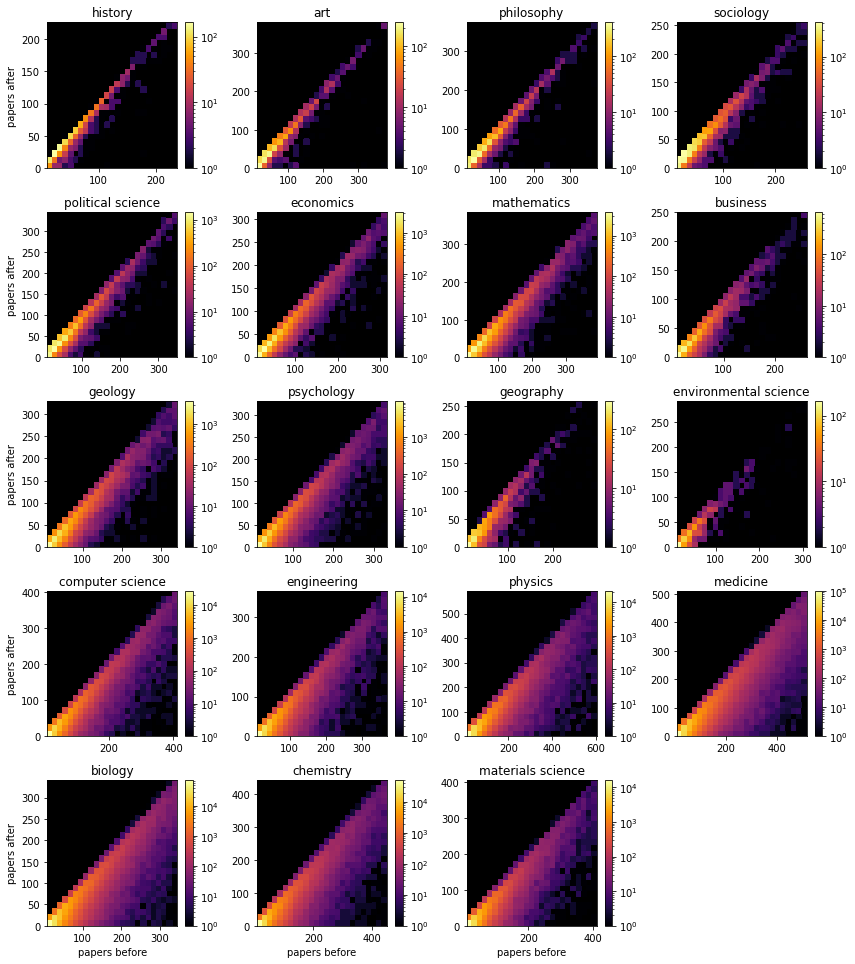

In [37]:
from s4_authors_stats import get_h_index

def _papers_before_after(ax, idxs, field_name):
    valid_colabs_cit_list = CL[idxs]
    valid_citation_list = CH[idxs]
    p_before = []
    p_after = []
    
    for ccits, acits in zip(valid_colabs_cit_list, valid_citation_list):
        before = len(acits)
        after = before - len(ccits)
        
        p_before.append(before)    
        p_after.append(after)
    
    p_before = np.asarray(p_before)
    p_after = np.asarray(p_after)
    
    ax.set_facecolor("black")
    perc = np.percentile(p_before, 99)
    im = ax.hist2d(p_before[p_before <= perc], p_after[p_before <= perc], 
           norm=LogNorm(), cmap='inferno', bins=(25, 25))
    ax.set_title(field_name)
    
    return im, p_after 

papersafter_map = generic_before_after(SUFFIX, _papers_before_after, 'papers before', 'papers after', 'papers')

In [18]:

def rank(values, i, new_val):
    new_pair = np.array([(new_val[0], new_val[1], new_val[2], i[-1])], dtype=[('my_val1', int), ('my_val2', int), ('my_val3', int), ('my_val4', int)])
    new_rank = np.searchsorted(values, new_pair[0], side='right')
    return new_rank

def get_rank_after(hindexbefore, i, ccits, acits):
    diff_cits = acits.copy() #json.loads(acits)
    for ctemp in ccits: #json.loads(ccits):
        diff_cits.remove(ctemp)
    hafter = get_h_index(diff_cits)
#     print(hafter, i, acits)
    rafter = rank(hindexbefore, i, (-hafter[0], -hafter[1], -hafter[2]))
    return rafter



100%|██████████| 60771/60771 [00:01<00:00, 32733.27it/s]


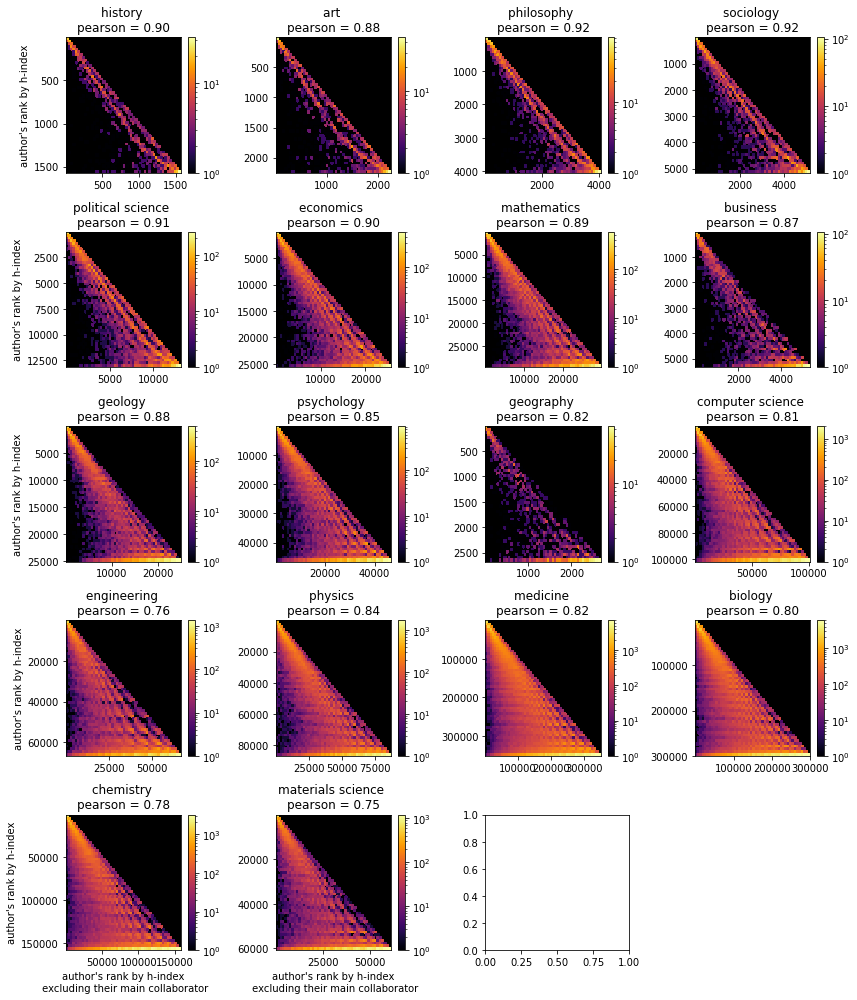

In [38]:
import tqdm
# from tqdm.auto import tqdm
def _plot_rank(ax, idxs, hindex_after, field_name):
    valid_h_index = H[idxs]
    
    valid_colabs_cit_list = CL[idxs]
    valid_citation_list = CH[idxs]
    
    neg_hindex = np.array([(-row[0], -row[1], -row[2], i) for i,row in enumerate(valid_h_index)], 
                          dtype=[('my_val1', int), ('my_val2', int), ('my_val3', int), ('my_val4', int)])
    neg_hindex_sorted = np.sort(neg_hindex)
    rankbefore = rankdata(neg_hindex, method='ordinal')

    results = []
    for a,b,c in tqdm.tqdm(zip(neg_hindex, valid_colabs_cit_list, valid_citation_list), total=len(neg_hindex)):
        results.append(get_rank_after(neg_hindex_sorted, a,b,c)) 
    
    ax.set_facecolor("black")
    
    im = ax.hist2d(rankbefore, results, bins=50, cmap='inferno', norm=LogNorm())
    ax.set_title('%s \npearson = %.2f' % (field_name, pearsonr(rankbefore, results)[0]))
    ax.invert_yaxis()
    return im


def plot_rank(hafter_map, suffix):
    rows,cols = get_rows_cols(fos_sorted)
    fig, axs = plt.subplots(figsize=(3*cols, 2.8*rows), nrows=rows, ncols=cols) #sharex=True, sharey=True)
    
    i = 0
    for field in fos_sorted:
        group = (FOS == field)
        if np.count_nonzero(group) < 1000:
            continue
        ax = axs[int(i/cols)][i%cols]
        
        field_name = fos_infos[fos_infos['field_id'] == field].iloc[0, -1]
        im = _plot_rank(ax, group, hafter_map[field], field_name=field_name)
    
        if i%cols == 0: 
            ax.set_ylabel('author\'s rank by h-index')
        if int(i/cols) == rows-1:    
            ax.set_xlabel('author\'s rank by h-index\n excluding their main collaborator')
    
        fig.colorbar(im[3], ax=ax)
        
        i += 1
    
    empty_plots = len(fos_sorted)%cols
    if empty_plots != 0:
        for i in range(empty_plots,cols):
            axs[-1,i].axis('off')

    fig.tight_layout()
    fig.savefig('outputs/fos_hist2d_hrank_%d.pdf' % suffix)
    fig.show()
    
plot_rank(hafter_map, suffix=SUFFIX)


100%|██████████| 60771/60771 [00:00<00:00, 170594.26it/s]


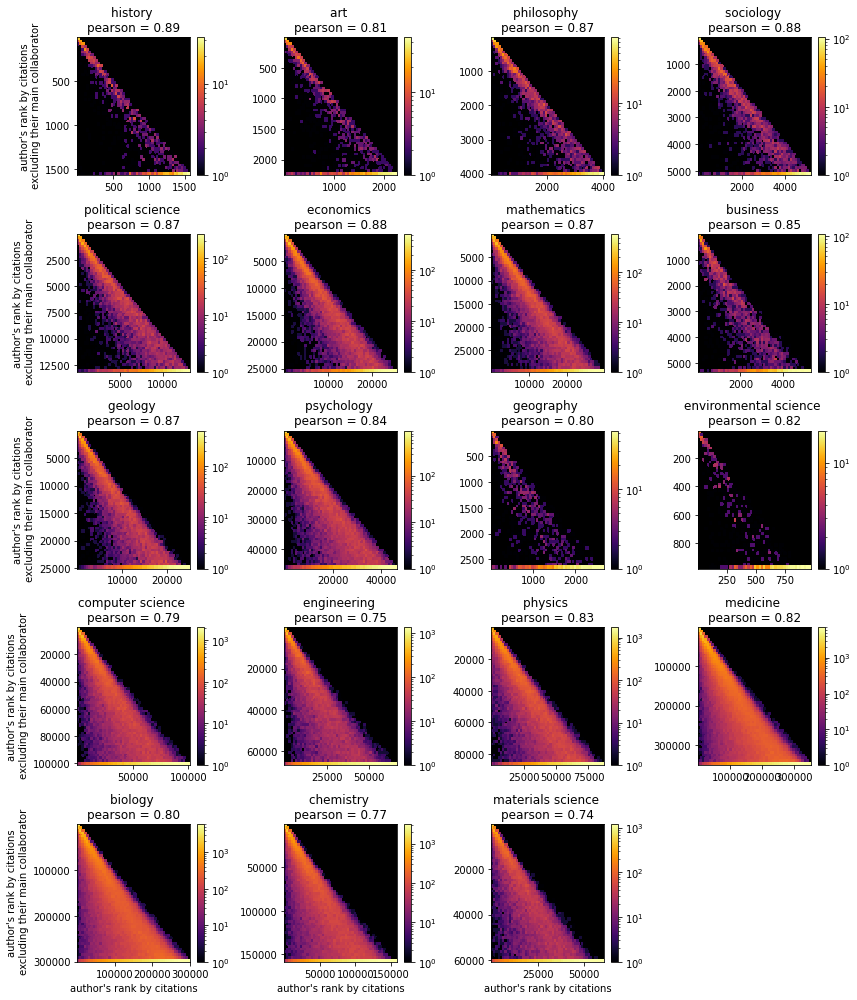

In [39]:
import tqdm
# from tqdm.auto import tqdm

def rank_cits(values, i, new_val):
    new_pair = np.array([(new_val[0], i[-1])], dtype=[('my_val1', int), ('my_val2', int)])
    new_rank = np.searchsorted(values, new_pair[0], side='right')
    return new_rank

def get_rank_author(hindexbefore, i, citsafter):
    rafter = rank_cits(hindexbefore, i, (-citsafter,))
    return rafter

def _plot_rank_cits(ax, idxs, metric_after, field_name):
    valid_citation_list = [sum(temp) for temp in CH[idxs]]
    
    neg_cits = np.array([(-row, i) for i,row in enumerate(valid_citation_list)], 
                          dtype=[('my_val1', int), ('my_val2', int)])
    neg_cits_sorted = np.sort(neg_cits)
    rankbefore = rankdata(neg_cits, method='ordinal')

    results = []
    for c, cafter in tqdm.tqdm(zip(neg_cits, metric_after), total=len(neg_cits)):
        results.append(get_rank_author(neg_cits_sorted, c, cafter)) 
    
    ax.set_facecolor("black")
    
    im = ax.hist2d(rankbefore, results, bins=50, cmap='inferno', norm=LogNorm())
    ax.set_title('%s \npearson = %.2f' % (field_name, pearsonr(rankbefore, results)[0]))
    ax.invert_yaxis()
    return im


def plot_rank_metric(after_map, metric_rank, suffix, xlabel, ylabel, outname):
    rows,cols = get_rows_cols(fos_sorted)
    fig, axs = plt.subplots(figsize=(3*cols, 2.8*rows), nrows=rows, ncols=cols) #sharex=True, sharey=True)
    
    i = 0
    for field in fos_sorted:
        group = (FOS == field)
        ax = axs[int(i/cols)][i%cols]
        
        field_name = fos_infos[fos_infos['field_id'] == field].iloc[0, -1]
        im = metric_rank(ax, group, after_map[field], field_name=field_name)
    
        if i%cols == 0: 
            ax.set_ylabel(ylabel)
        if int(i/cols) == rows-1:    
            ax.set_xlabel(xlabel)
    
        fig.colorbar(im[3], ax=ax)
        
        i += 1
    
    empty_plots = len(fos_sorted)%cols
    if empty_plots != 0:
        for i in range(empty_plots,cols):
            axs[-1,i].axis('off')

    fig.tight_layout()
    fig.savefig('outputs/fos_hist2d_rank_%s_%d.pdf' % (outname,suffix))
    fig.show()
    
ylabel = 'author\'s rank by citations\n excluding their main collaborator'
xlabel = 'author\'s rank by citations'
outname = 'cits'
plot_rank_metric(citsafter_map, _plot_rank_cits, SUFFIX, xlabel, ylabel, outname)


In [ ]:
def _plot_rank_papers(ax, idxs, metric_after, field_name):
    valid_papers_list = [len(temp) for temp in CH[idxs]]
    
    neg_cits = np.array([(-row, i) for i,row in enumerate(valid_papers_list)], 
                          dtype=[('my_val1', int), ('my_val2', int)])
    neg_cits_sorted = np.sort(neg_cits)
    rankbefore = rankdata(neg_cits, method='ordinal')

    results = []
    for c, cafter in tqdm.tqdm(zip(neg_cits, metric_after), total=len(neg_cits)):
        results.append(get_rank_author(neg_cits_sorted, c, cafter)) 
    
    ax.set_facecolor("black")
    
    im = ax.hist2d(rankbefore, results, bins=50, cmap='inferno', norm=LogNorm())
    ax.set_title('%s \npearson = %.2f' % (field_name, pearsonr(rankbefore, results)[0]))
    ax.invert_yaxis()
    return im


ylabel = 'author\'s rank by papers\n excluding their main collaborator'
xlabel = 'author\'s rank by papers'
outname = 'papers'
plot_rank_metric(papersafter_map, _plot_rank_papers, SUFFIX, xlabel, ylabel, outname)



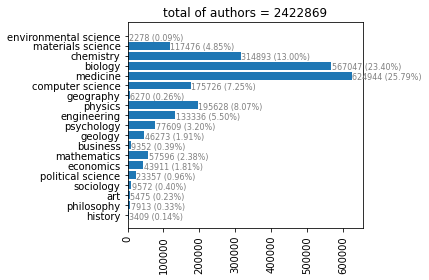

In [379]:
_, count = fos_sort(WS, FOS)
labels = [fos_infos[fos_infos['field_id'] == u].iloc[0, -1] for u in fos_sorted]

plt.barh(np.arange(1, len(count)+1), count, tick_label=labels)
plt.title('total of authors = %d' % len(FOS))
plt.xticks(rotation='vertical')
ax = plt.gca()
for i, v in enumerate(count):
    ax.text(v + 1500, i + .6, "%d (%.2f%%)" % (v, 100*v/len(FOS)), color='gray', size=8)
plt.tight_layout()
plt.savefig('authors_distribution_%d.pdf' % SUFFIX)

In [13]:
tempsuffix = 2020
WS = np.asarray(json.load(open('results/ws_full_%d.json' % tempsuffix)))
FOS = np.asarray(json.load(open('results/fos_full_%d.json' % tempsuffix)))
fos_sorted, _ = fos_sort(WS, FOS)

In [52]:
def hist2d_temporal(x_filename, y_filename, name, xlabel, ylabel, xscale, yscale='linear'):
    for field in fos_sorted:
        fig,axes = plt.subplots(figsize=(25, 4), nrows=1, ncols=7, sharex=True, sharey=True)

        for i, tempsuffix in enumerate(range(1960, 2021, 10)):
            X = np.asarray(json.load(open(x_filename % tempsuffix)))
            Y = np.asarray(json.load(open(y_filename % tempsuffix)))

            FOS = np.asarray(json.load(open('results/fos_full_%d.json' % tempsuffix)))

            idxs = FOS == field
            tempX = X[idxs]
            tempY = Y[idxs]
            if xscale == 'log':
                xbins = np.logspace(np.log10(min(tempX)), np.log10(max(tempX)+1), 10)
            else:
                xbins = np.linspace(min(tempX), max(tempX), 10)
               
            if yscale == 'log':
                ybins = np.logspace(np.log10(min(tempY)), np.log10(max(tempY)+1), 10)
            else:        
                ybins = np.linspace(min(tempY), max(tempY), 10)
            
            im = _hist2d(axes[i], tempX, tempY, xbins, ybins, '%d' % tempsuffix)
            axes[i].set_xscale(xscale)
            fig.colorbar(im[3], ax=axes[i])
            axes[i].set_xlabel(xlabel)
            if i == 0:
                axes[i].set_ylabel(ylabel)

        field_name = fos_infos[fos_infos['field_id'] == field].iloc[0, -1]
        fig.suptitle(field_name, y=1.15)

        fig.tight_layout()
        fig.savefig('outputs/hist2d_%s_%s_temporal.pdf' % (name, field_name))    

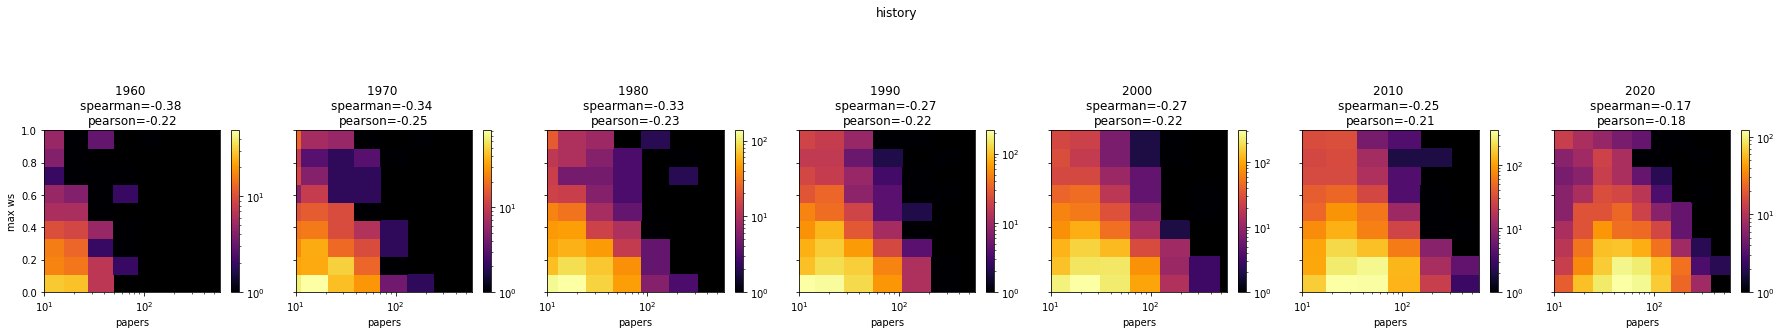

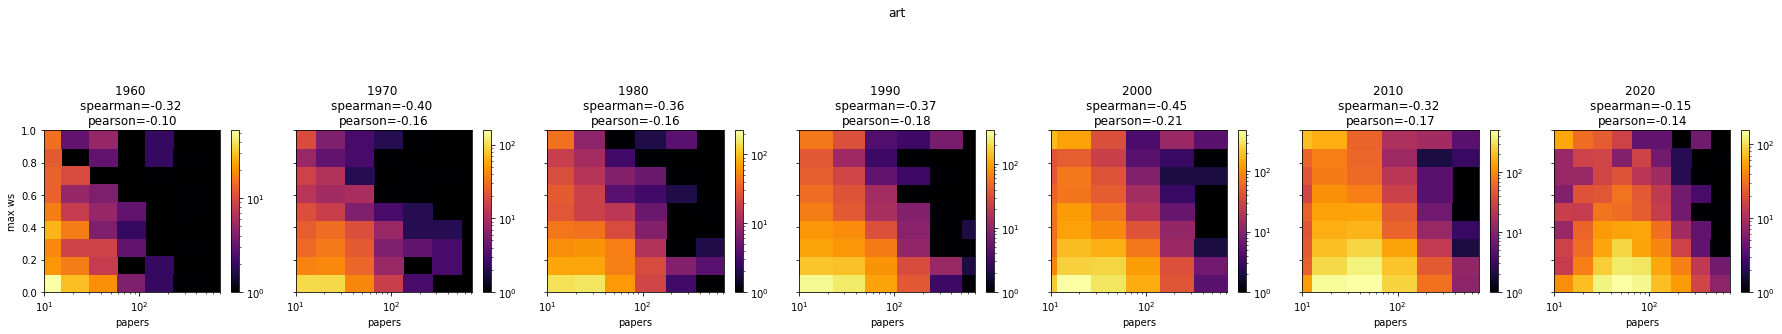

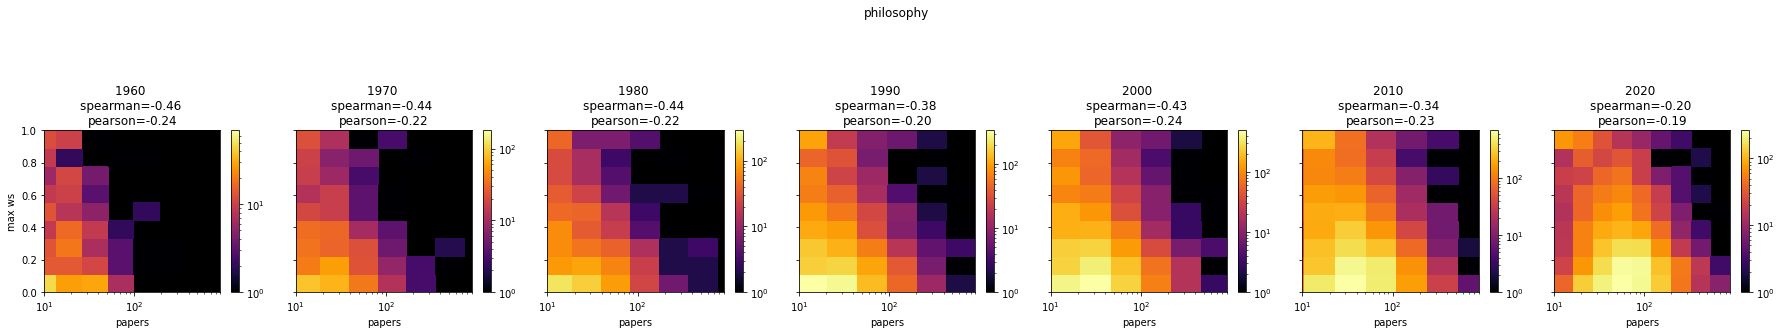

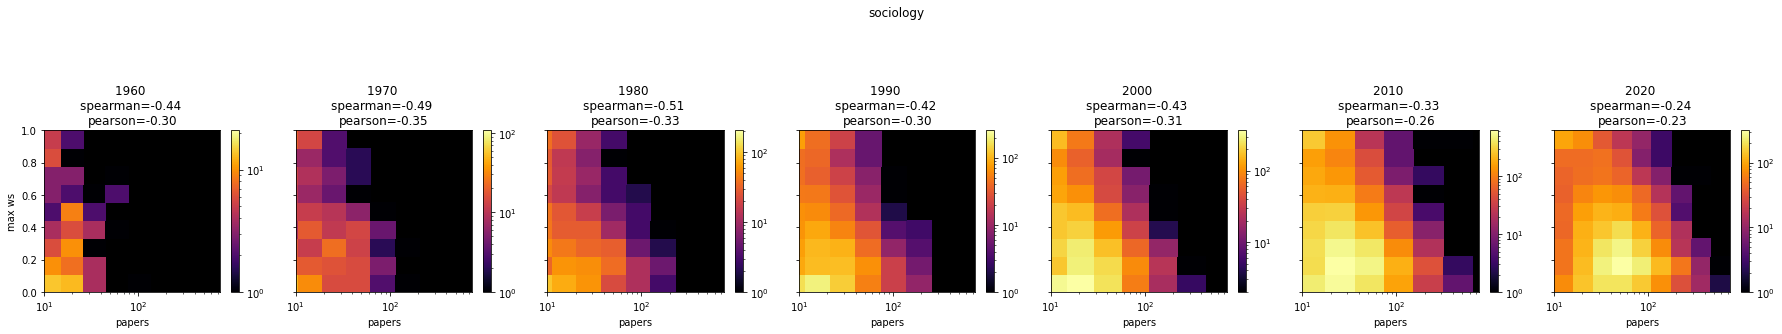

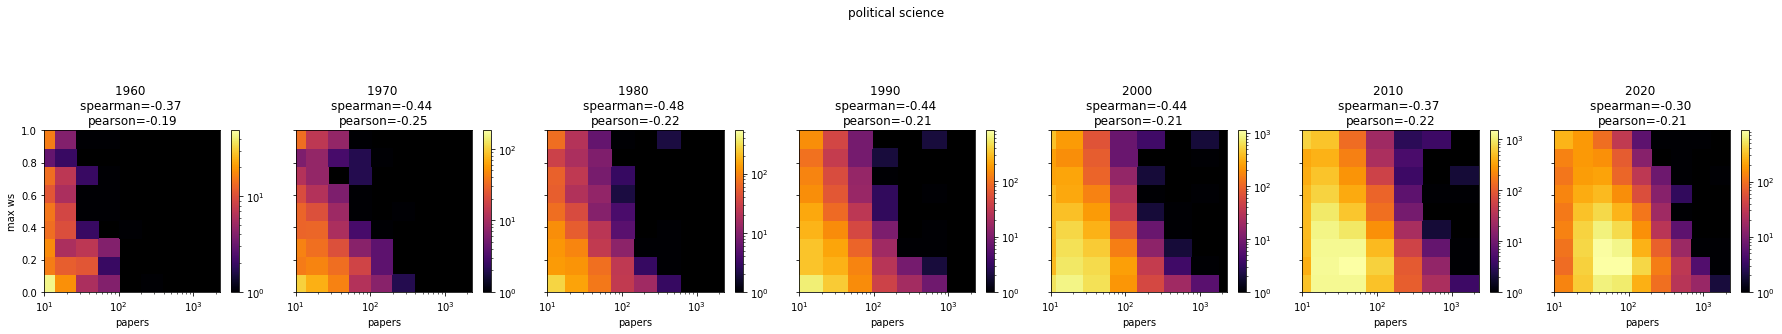

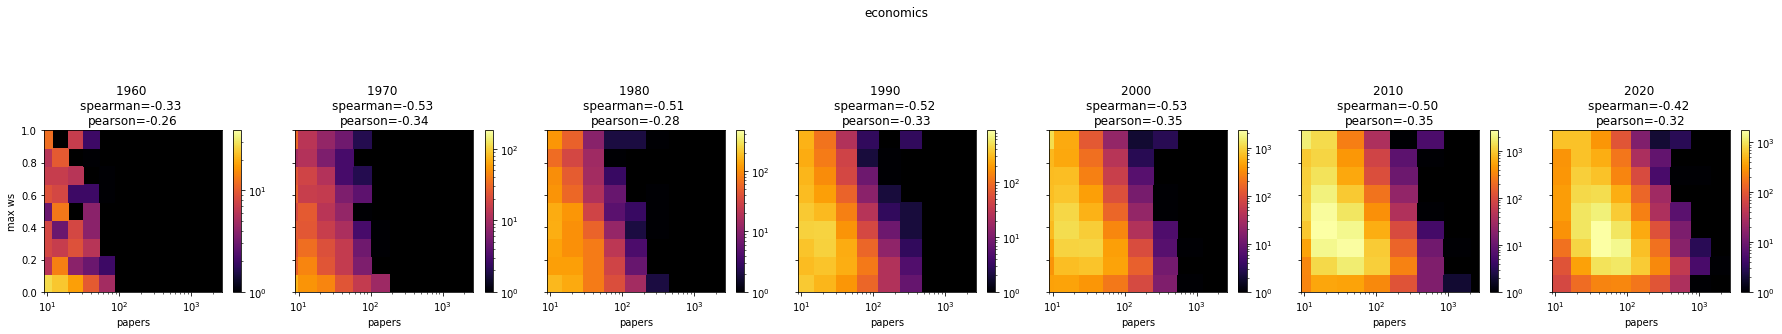

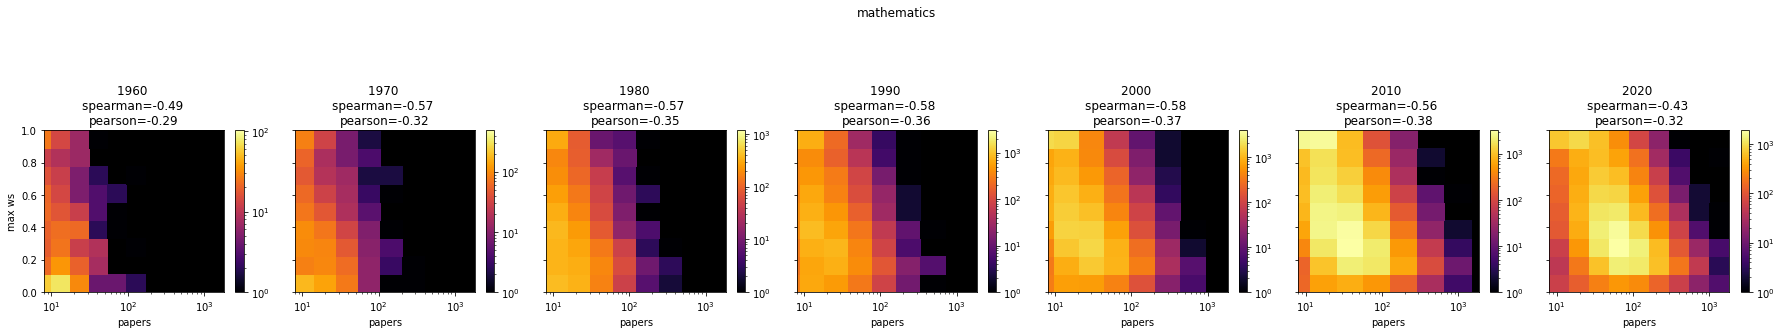

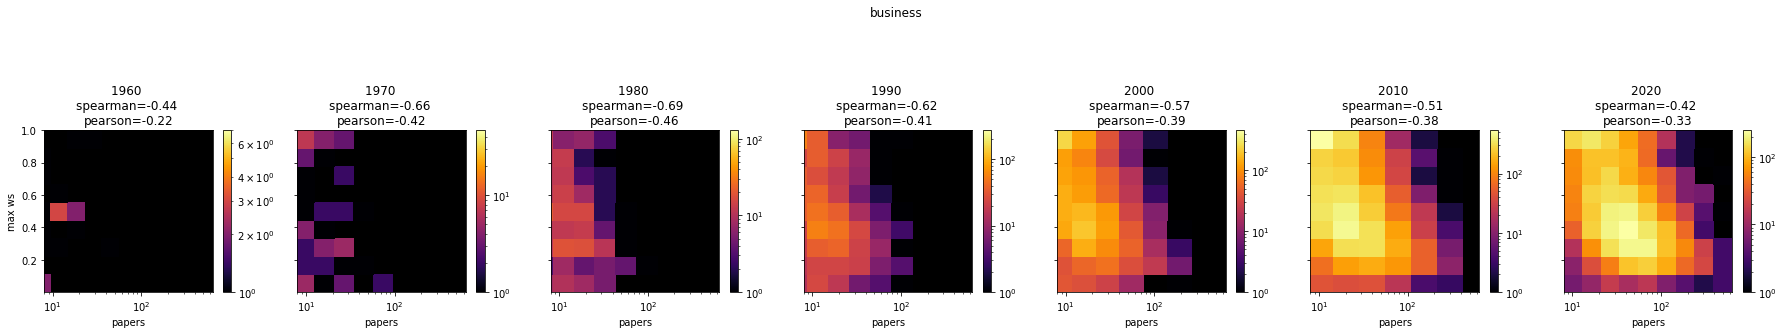

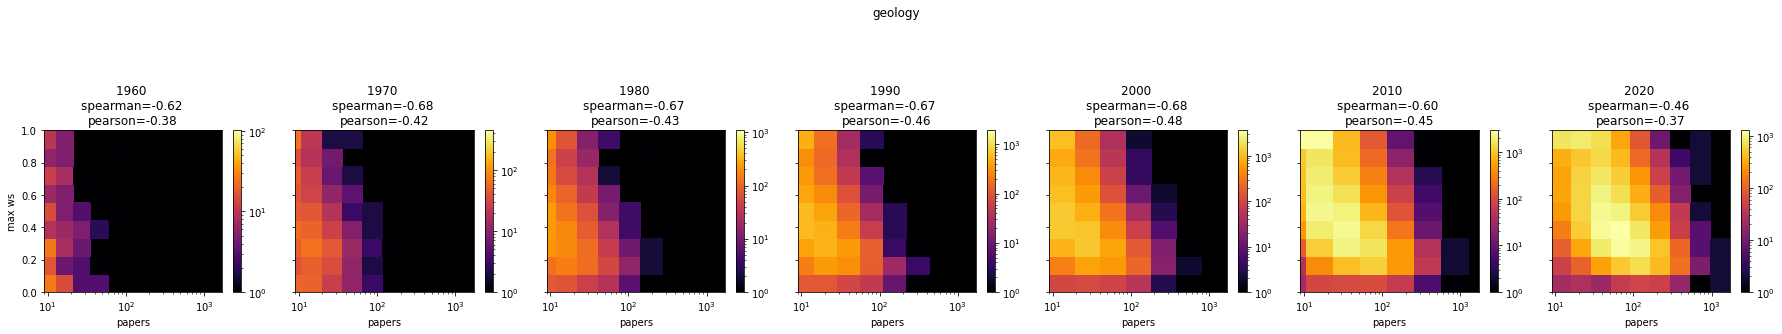

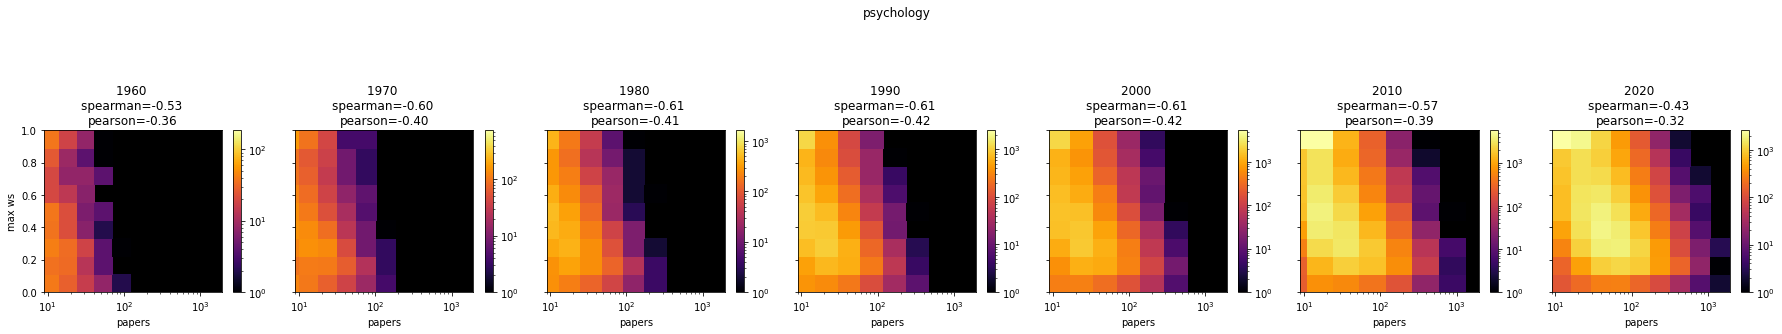

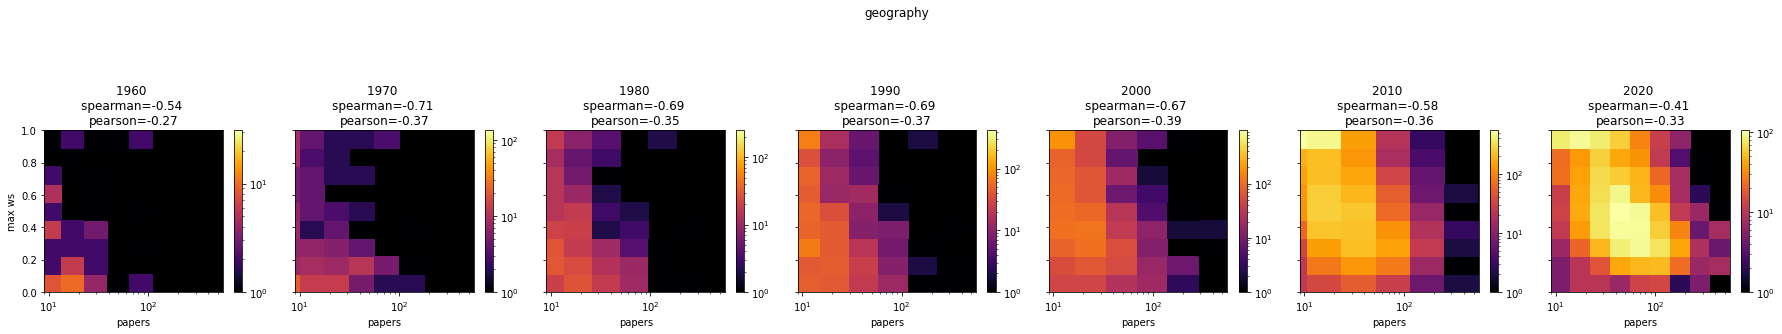

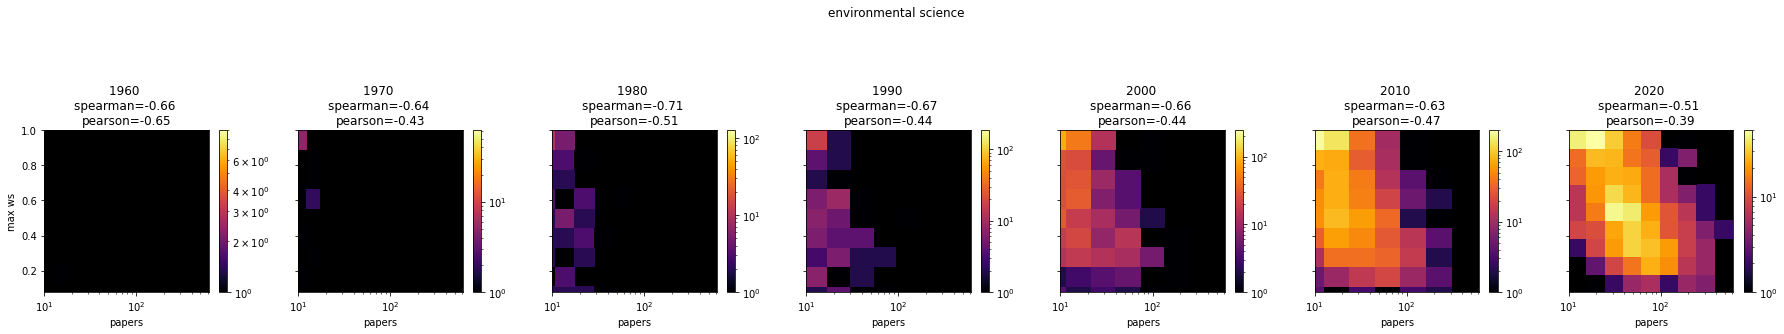

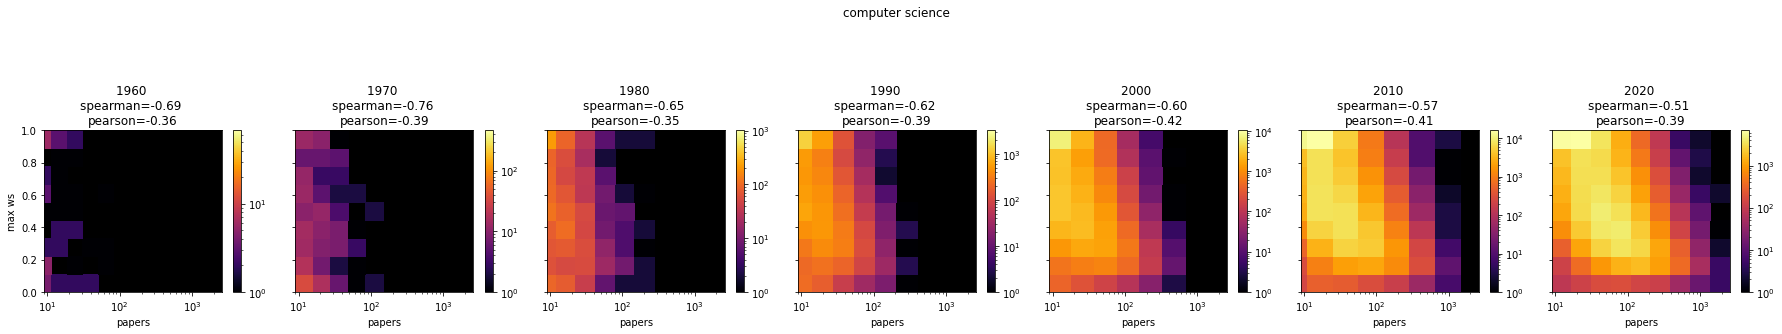

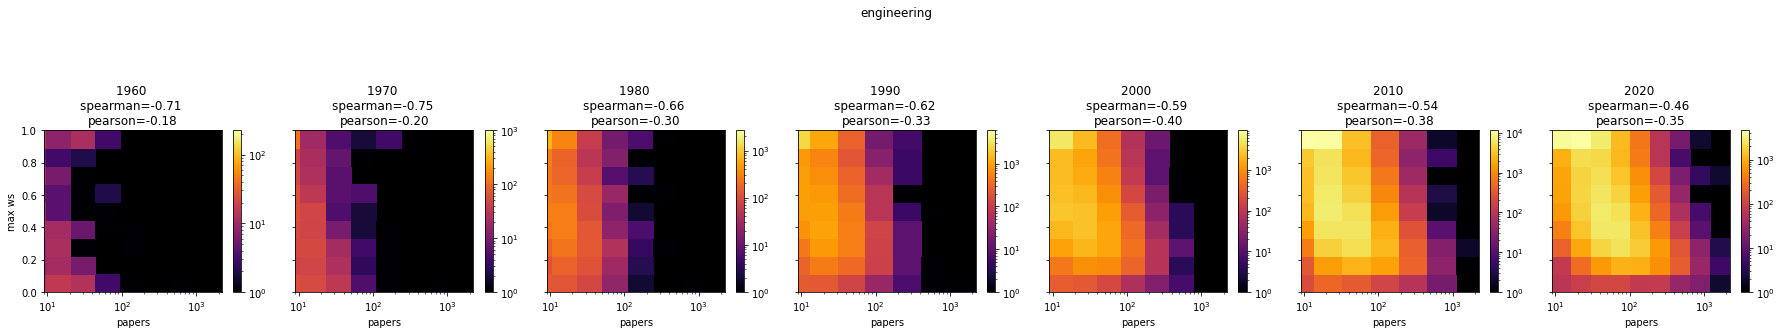

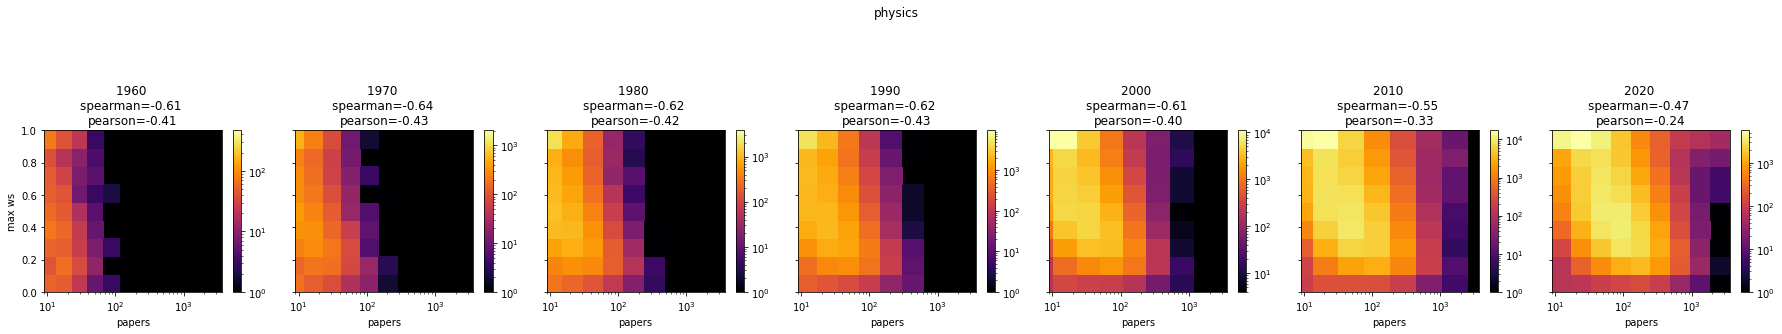

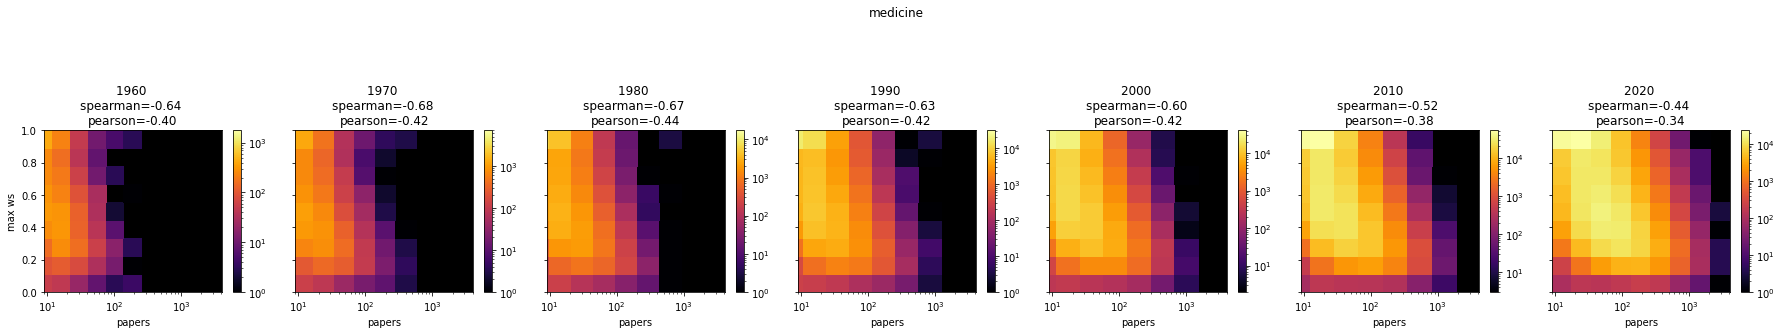

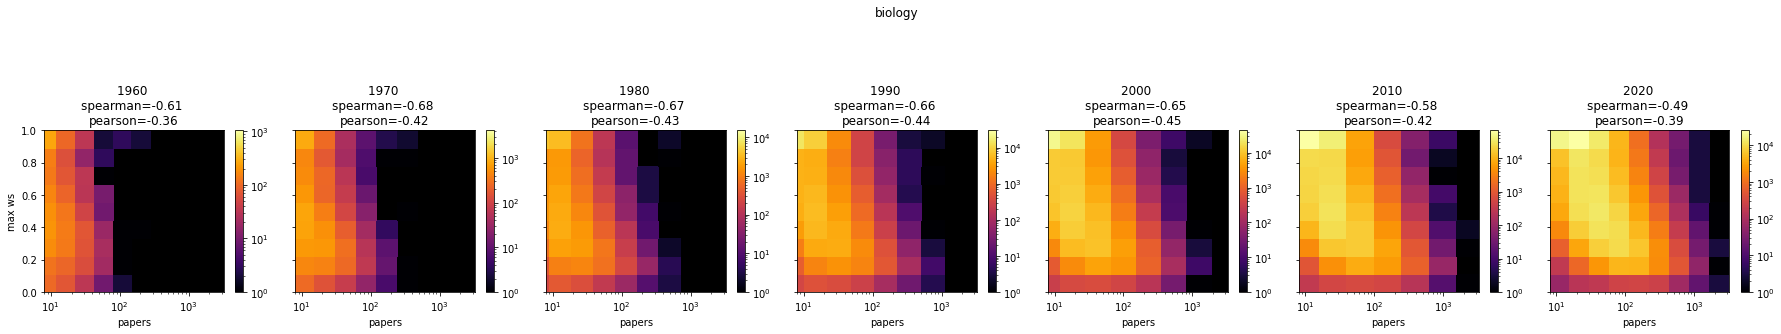

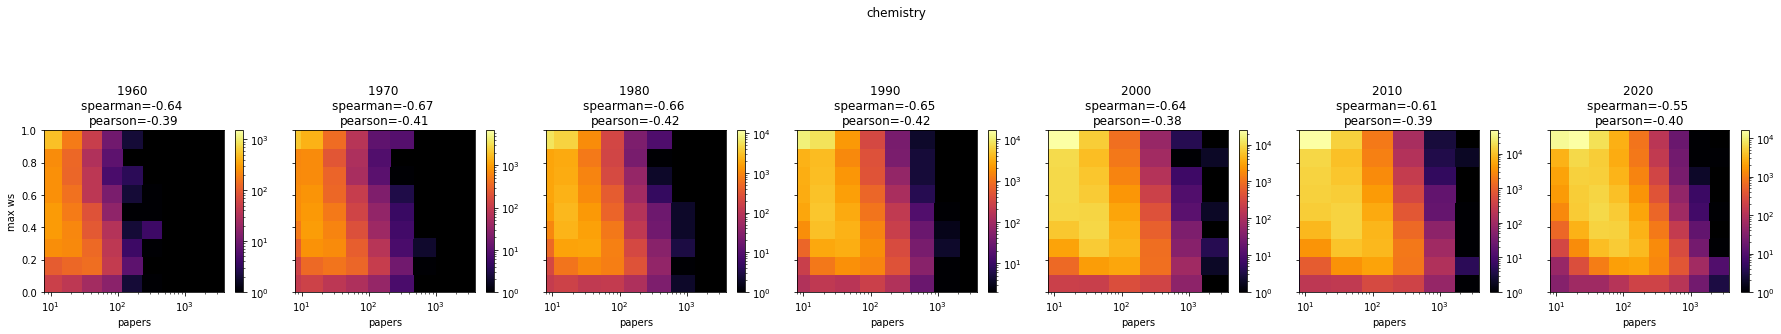

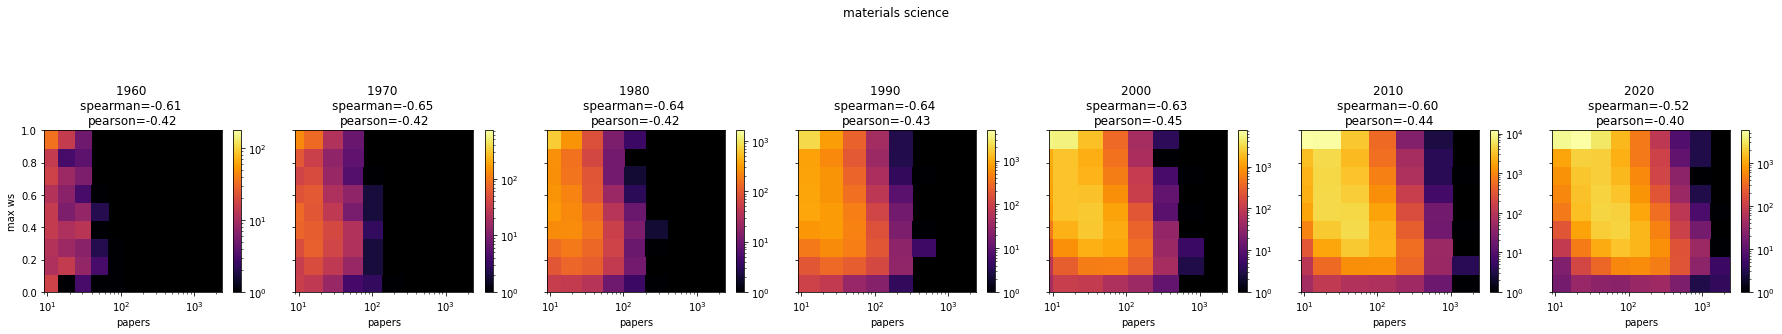

In [53]:
x_filename = 'results/papers_full_%d.json'
y_filename = 'results/ws_full_%d.json'
name = 'papers_ws'
xlabel = 'papers'
ylabel = 'max ws'
xscale = 'log'
hist2d_temporal(x_filename, y_filename, name, xlabel, ylabel, xscale)

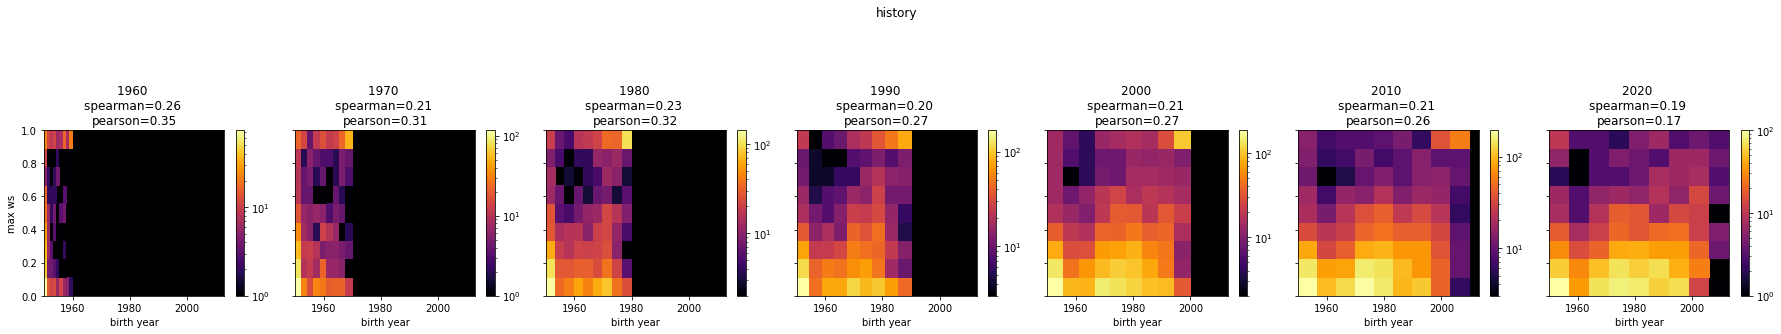

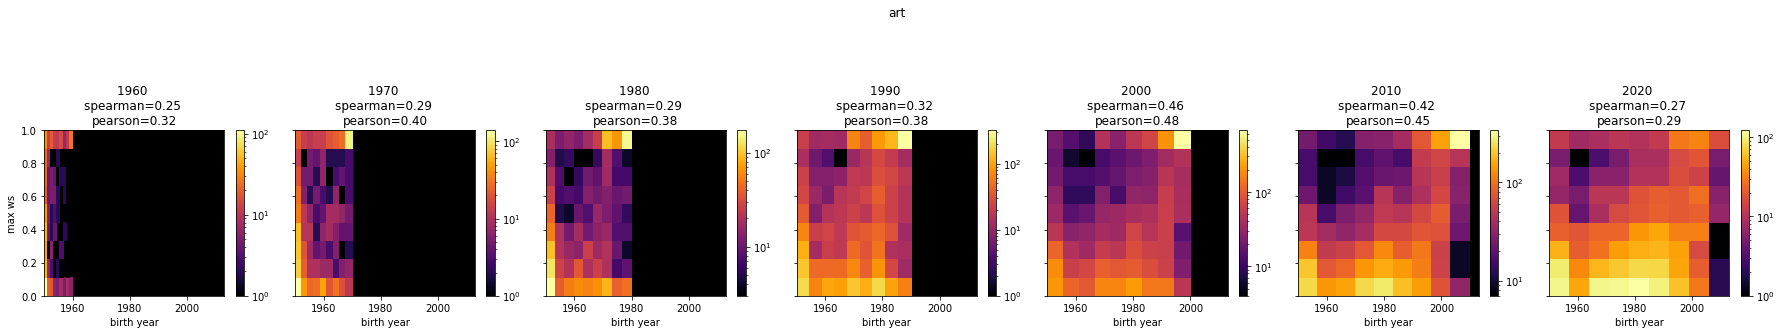

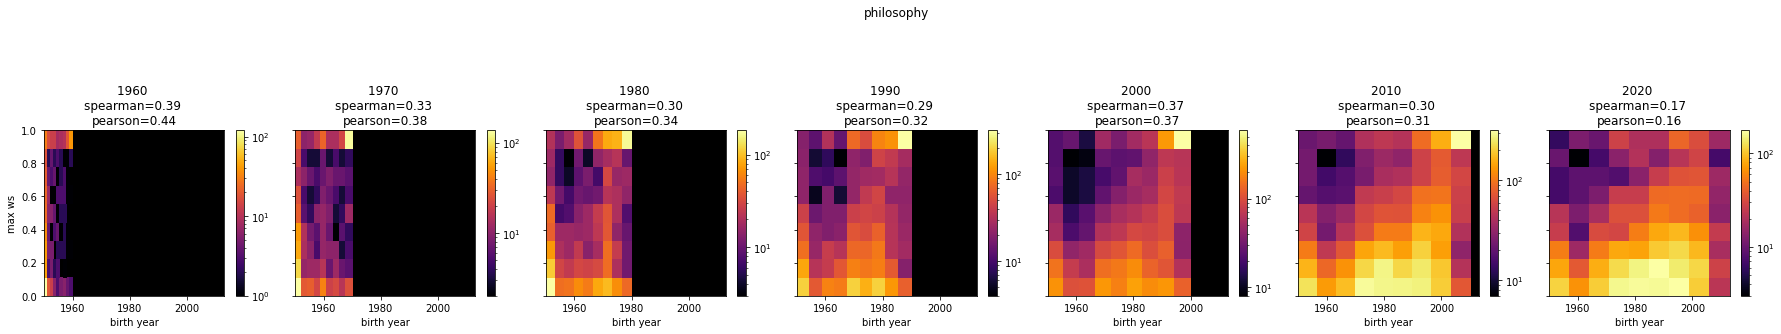

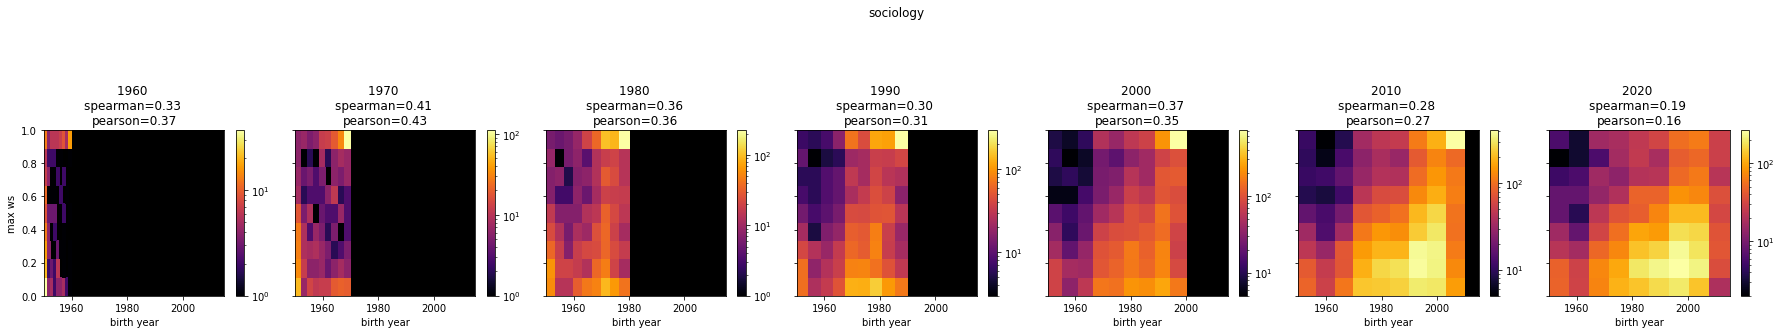

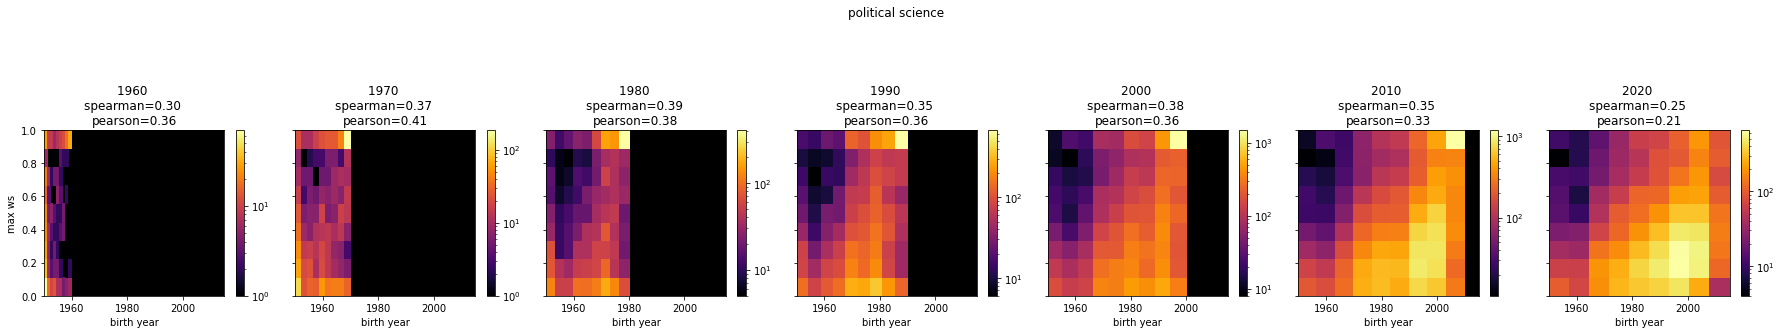

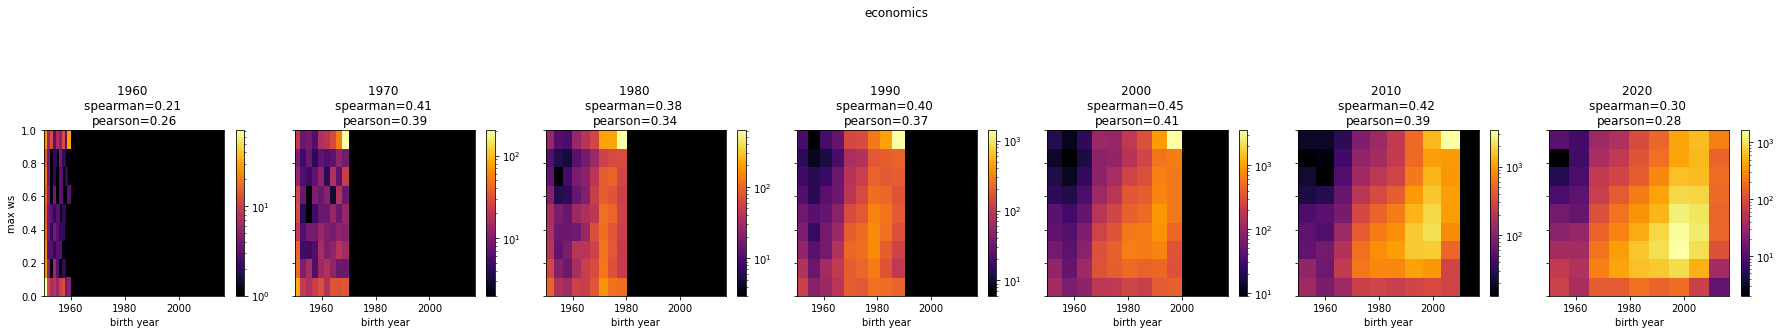

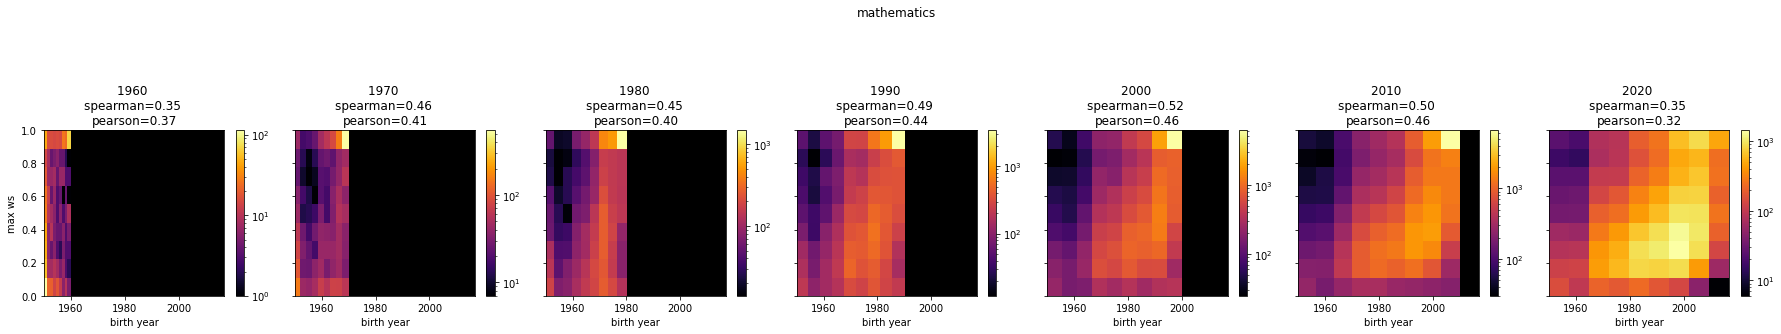

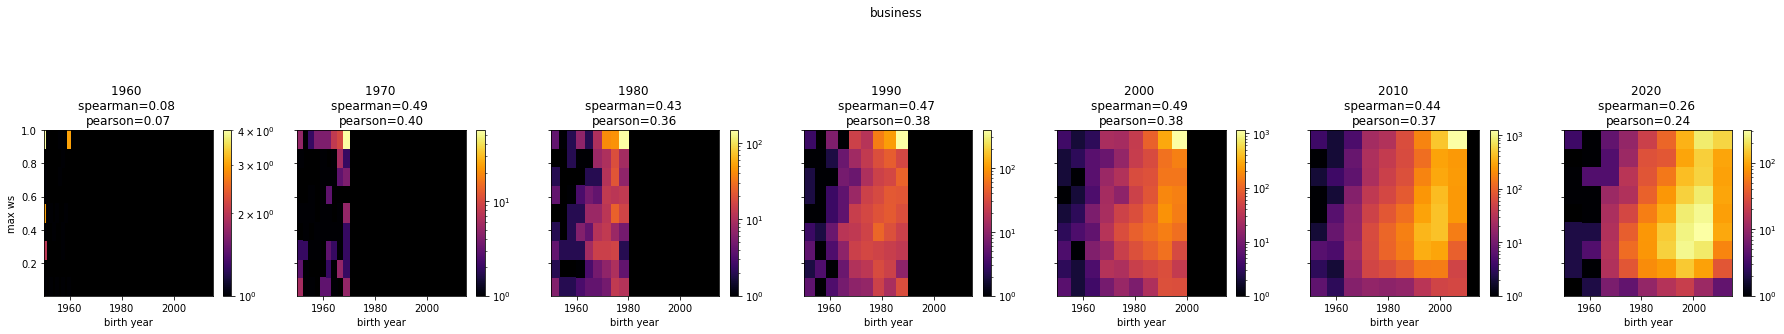

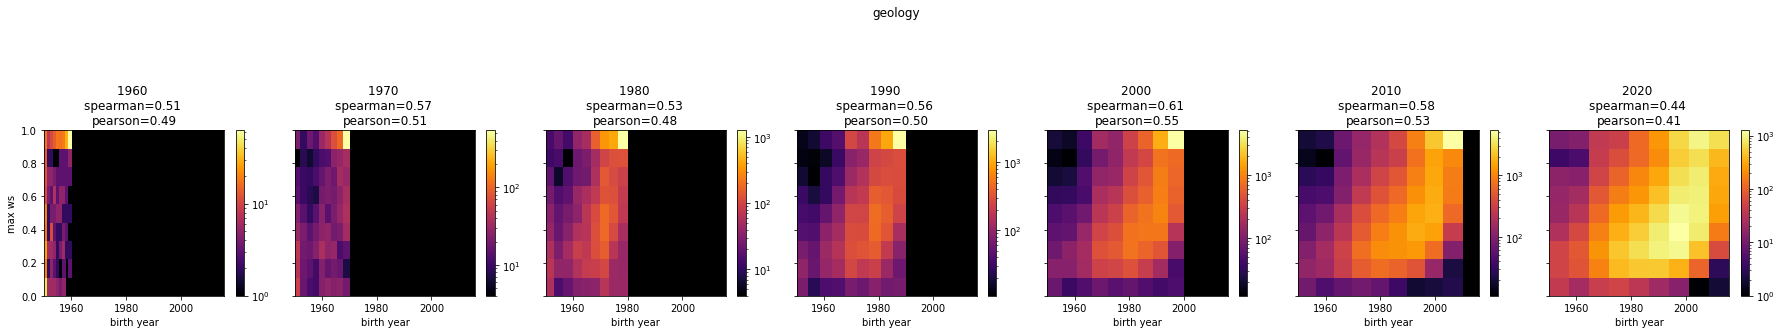

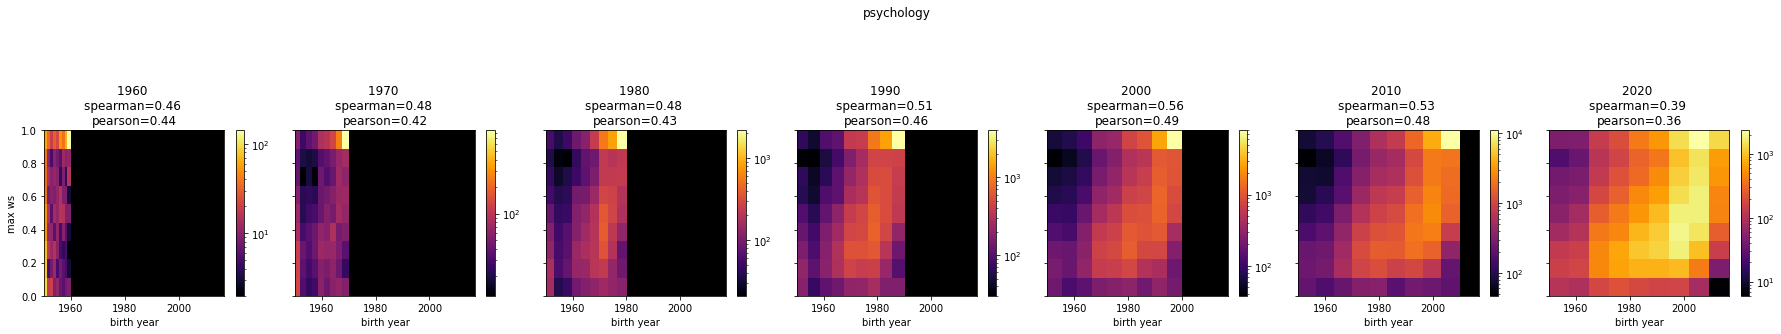

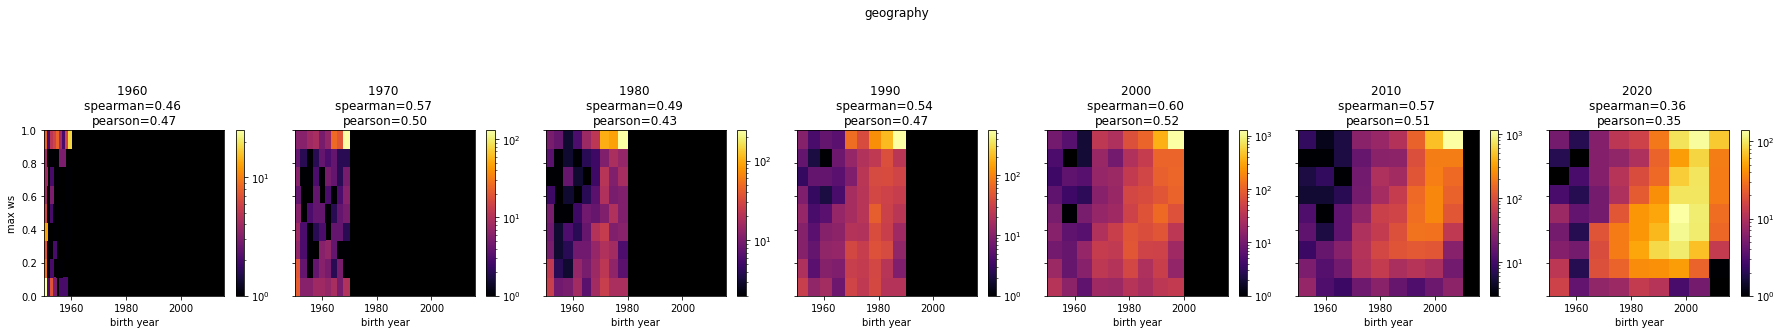

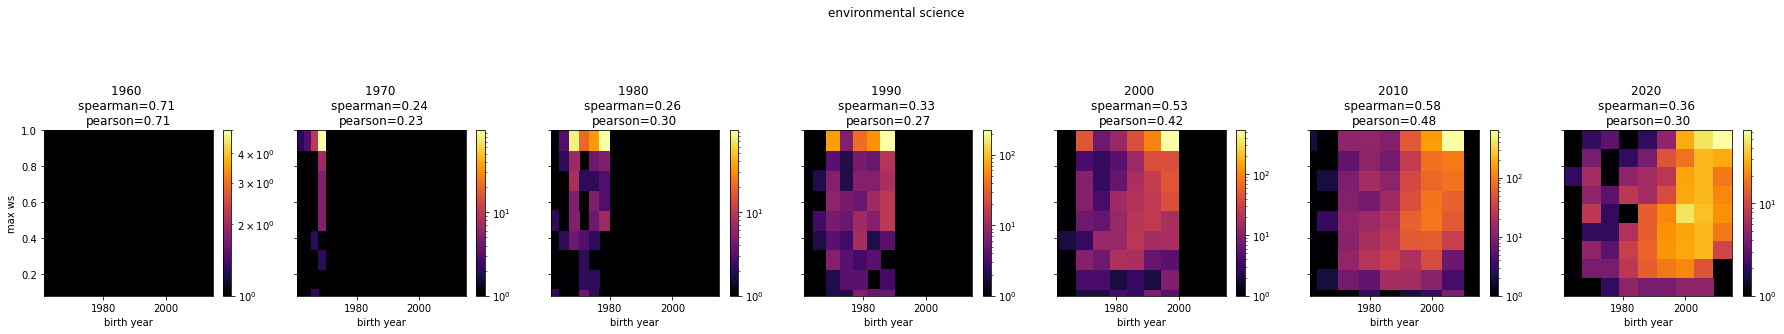

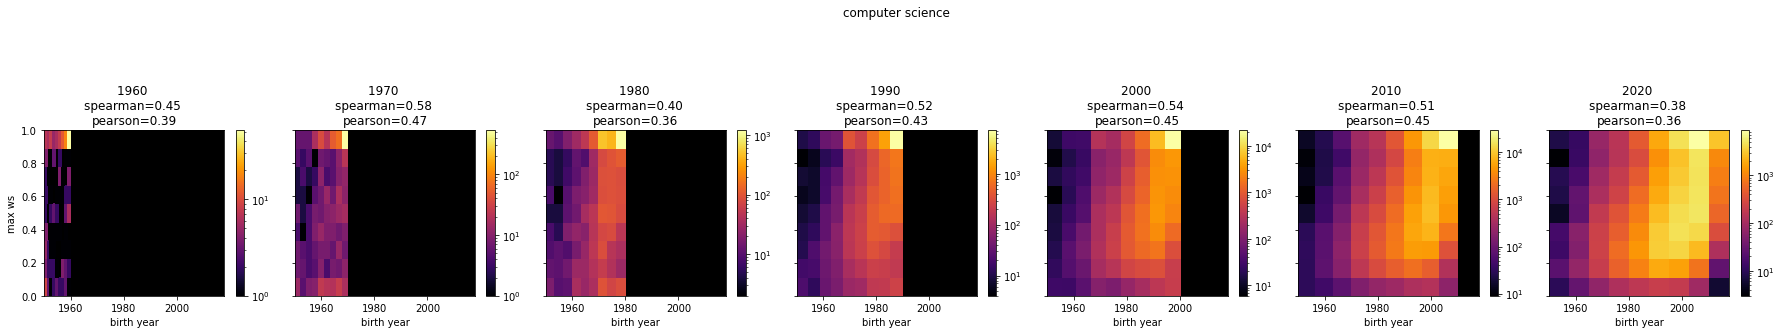

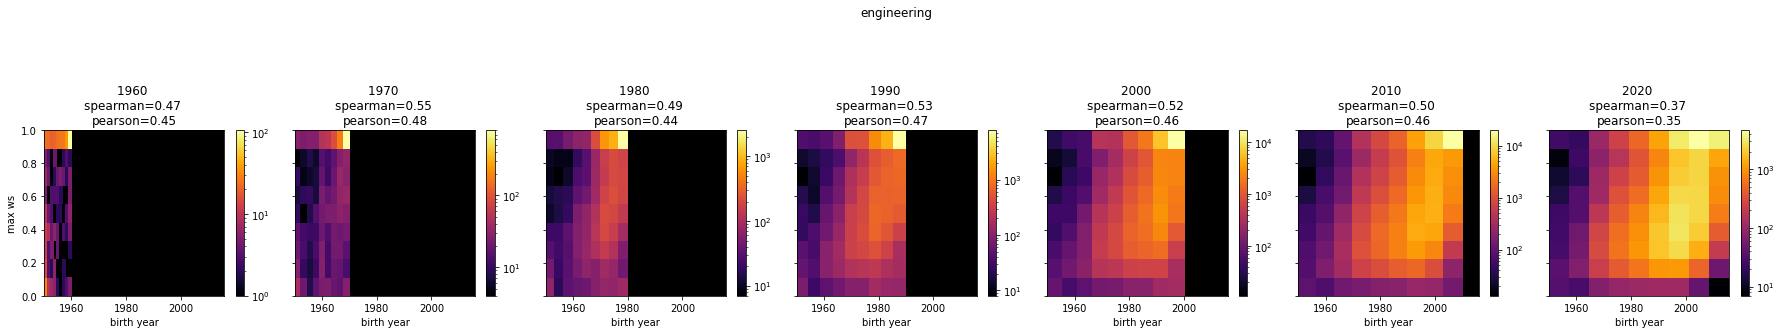

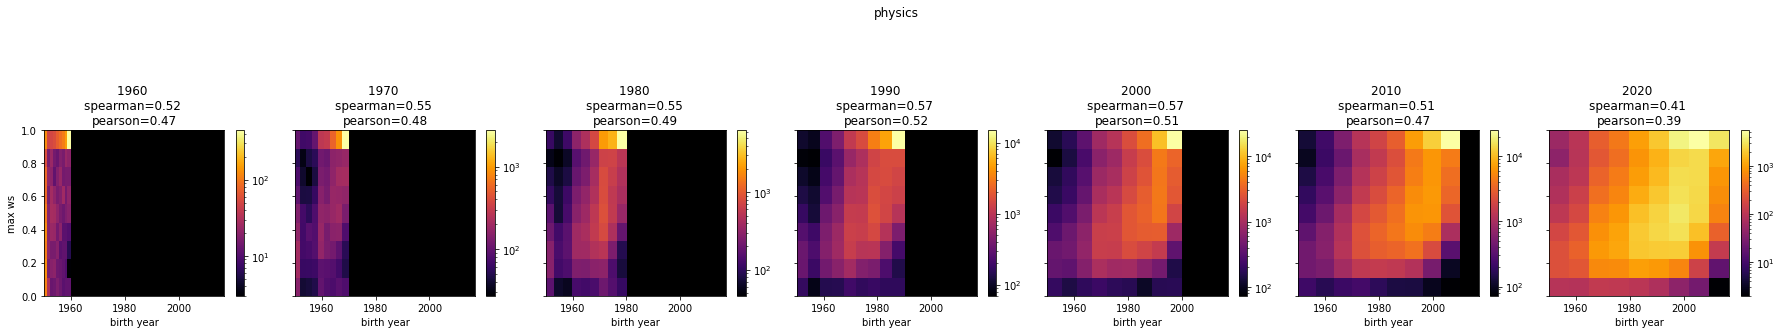

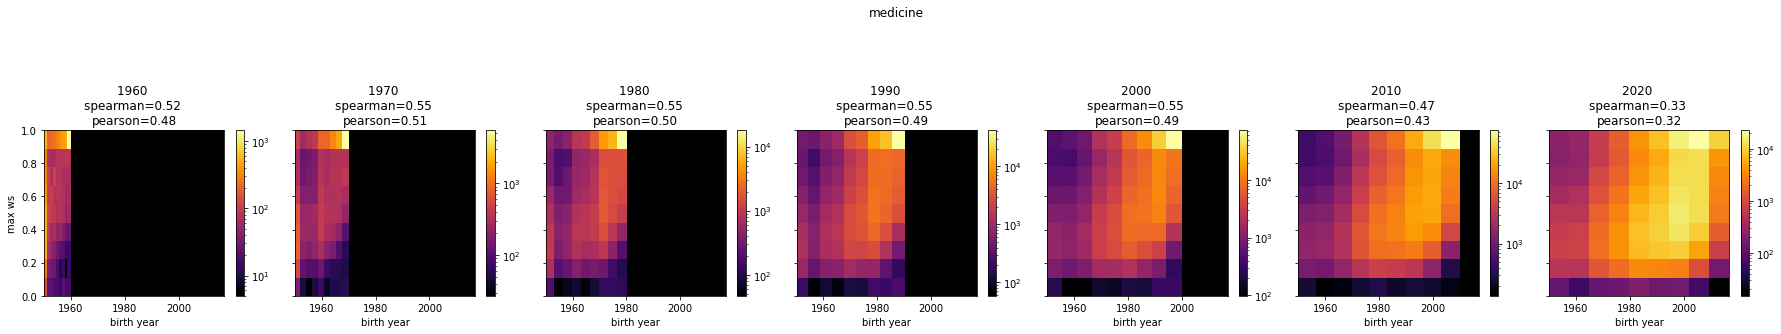

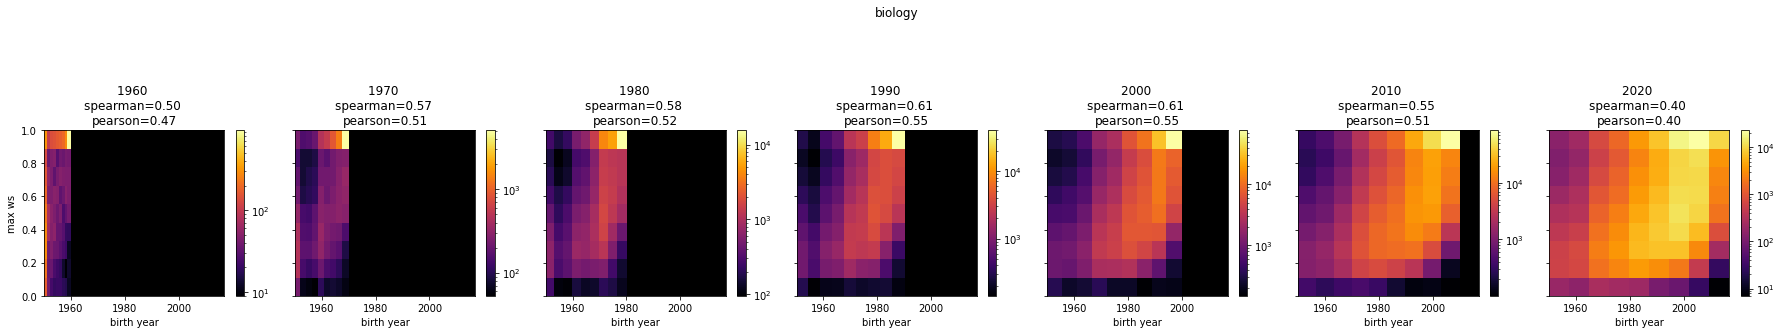

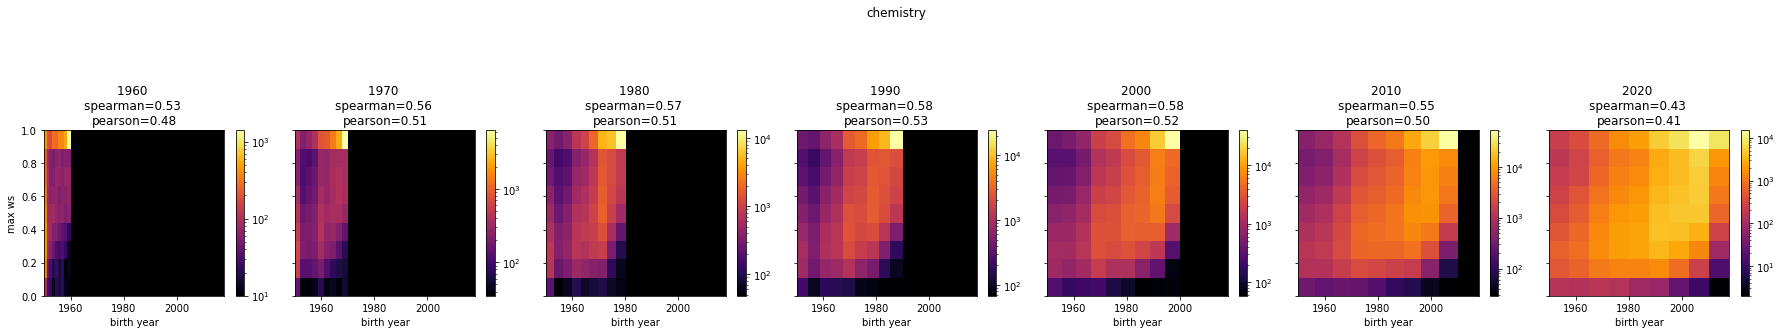

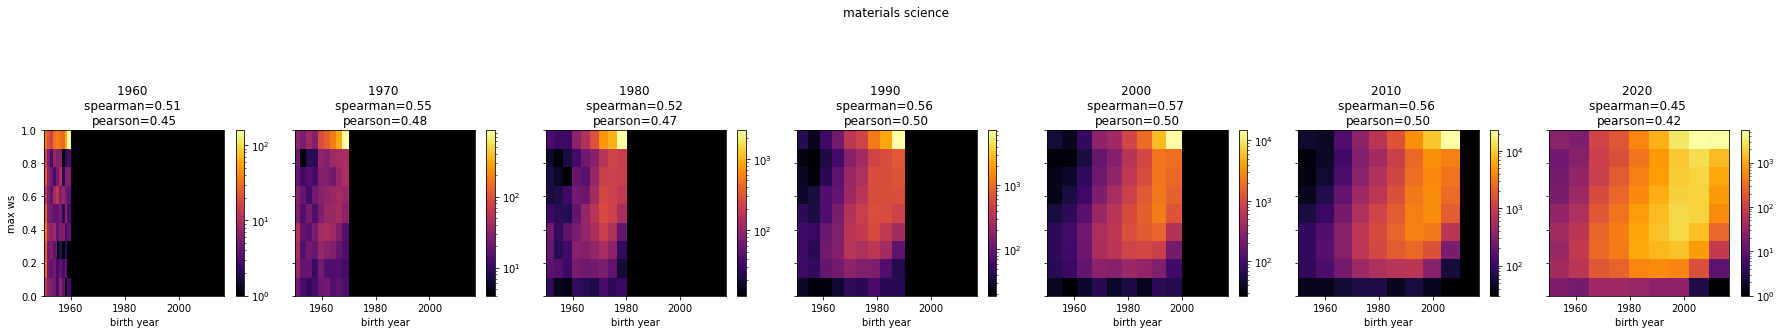

In [54]:
x_filename = 'results/birth_full_%d.json'
y_filename = 'results/ws_full_%d.json'
name = 'birth_ws'
xlabel = 'birth year'
ylabel = 'max ws'
xscale = 'linear'
hist2d_temporal(x_filename, y_filename, name, xlabel, ylabel, xscale)

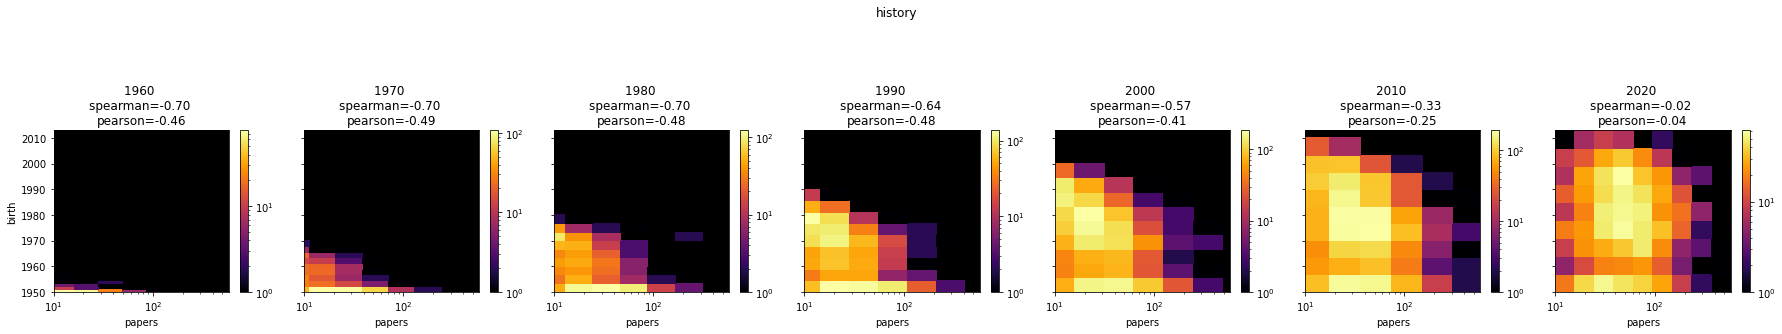

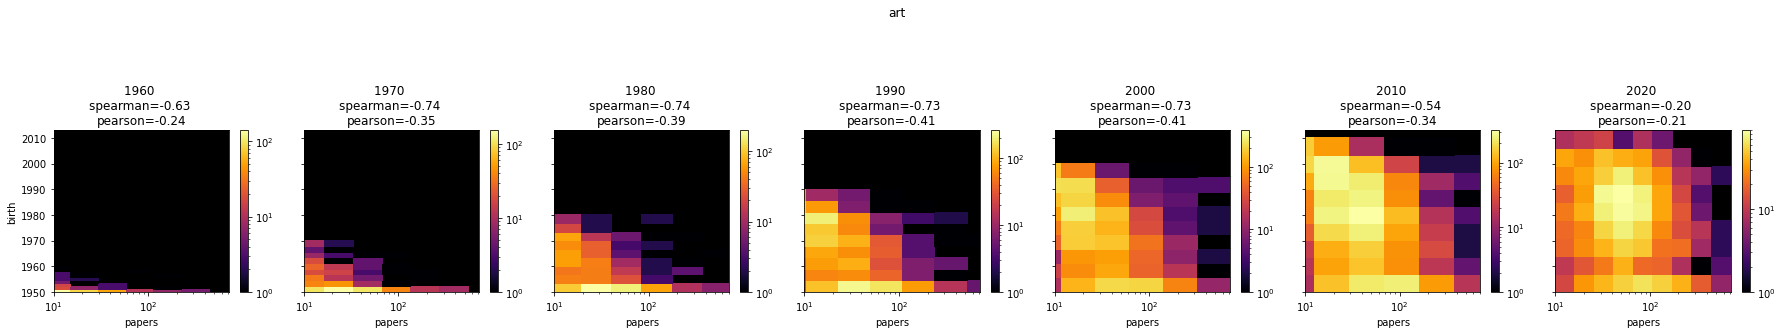

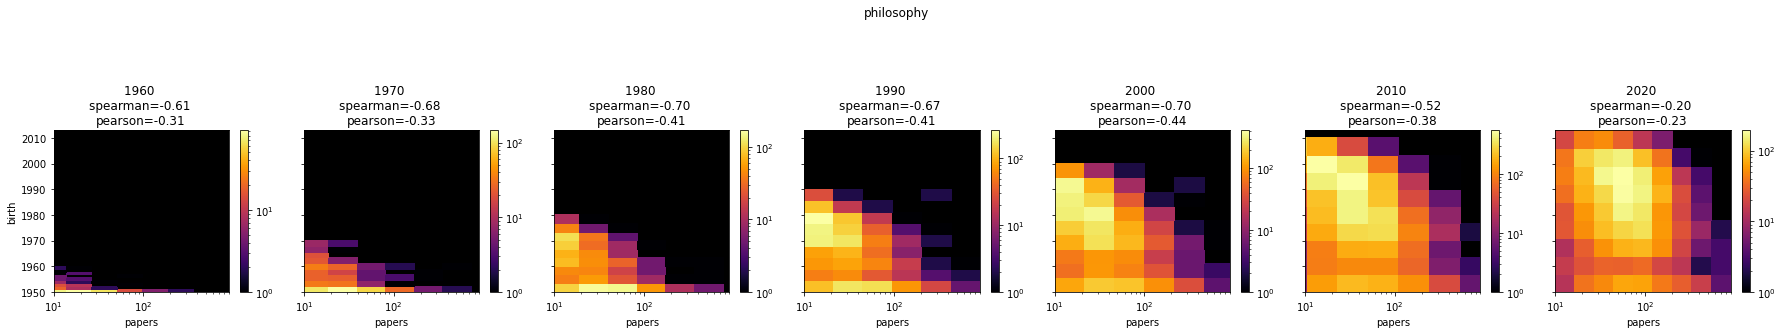

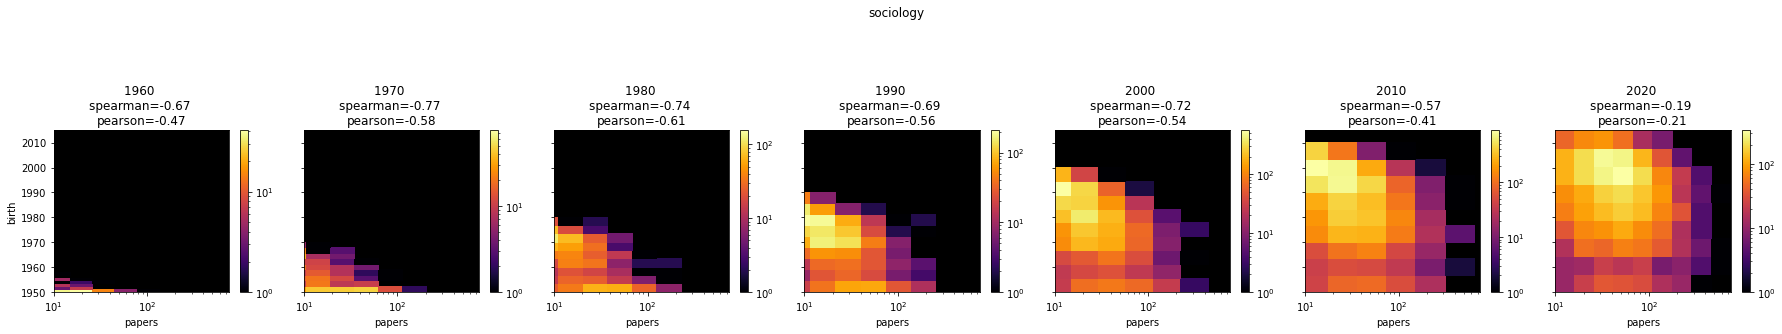

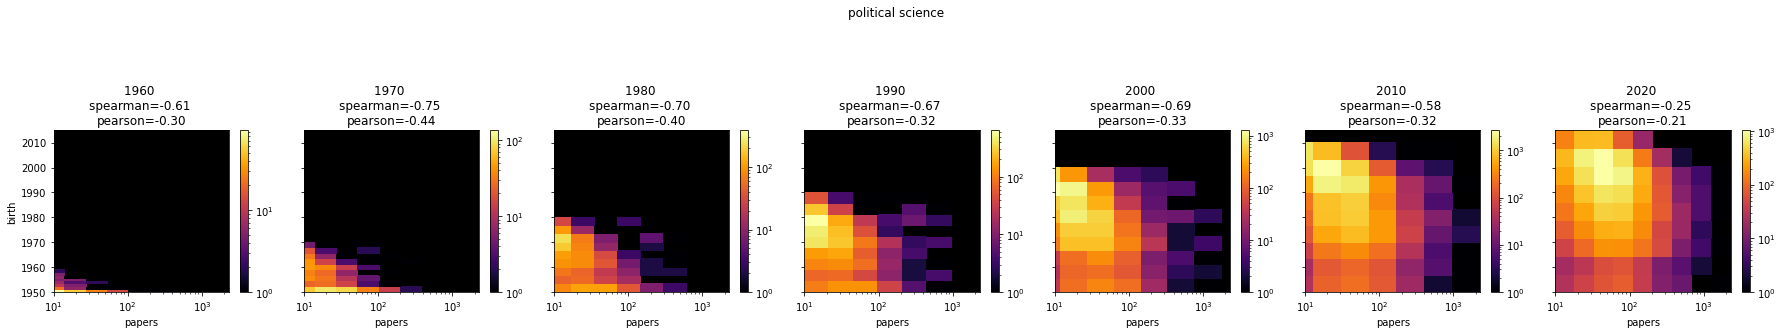

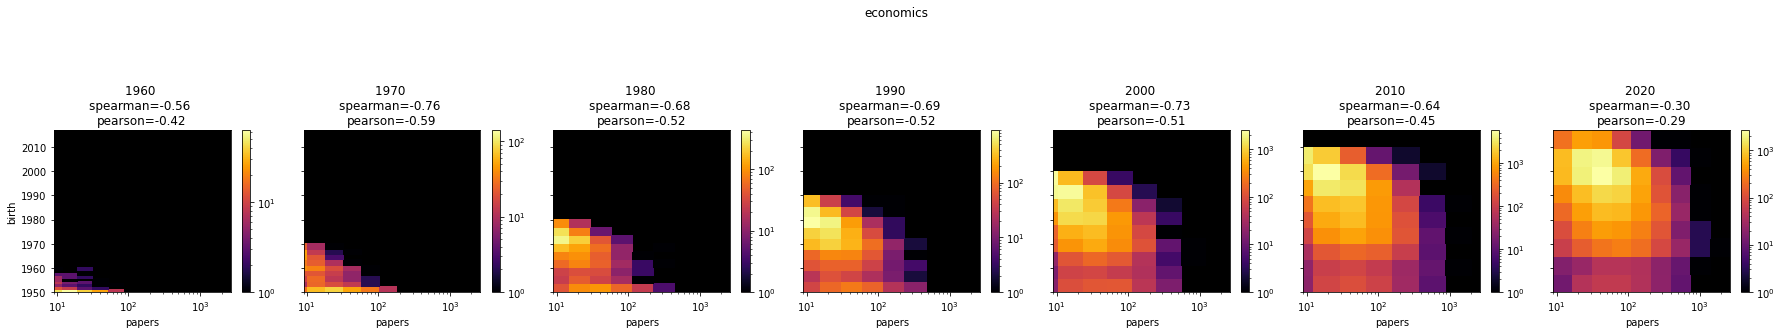

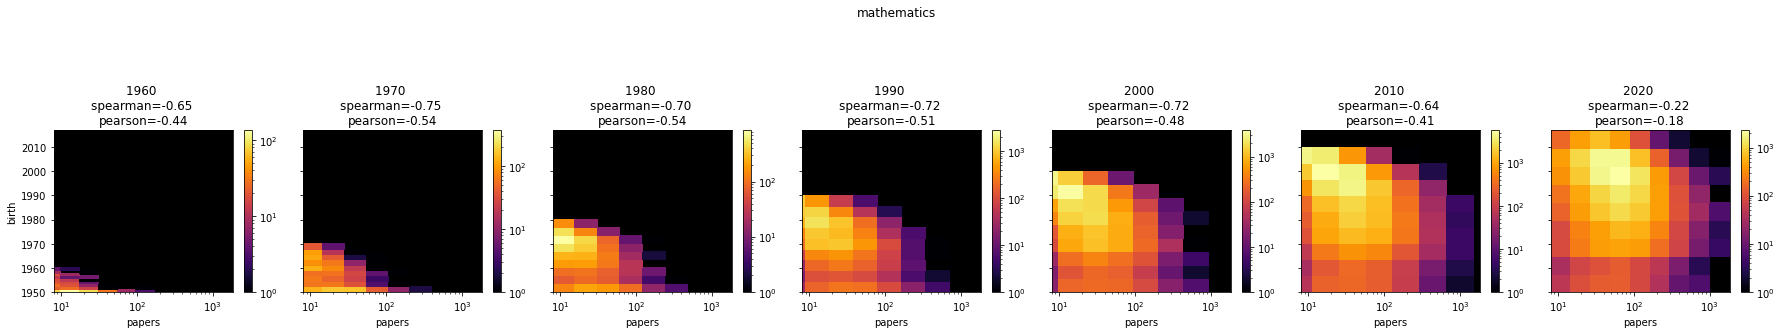

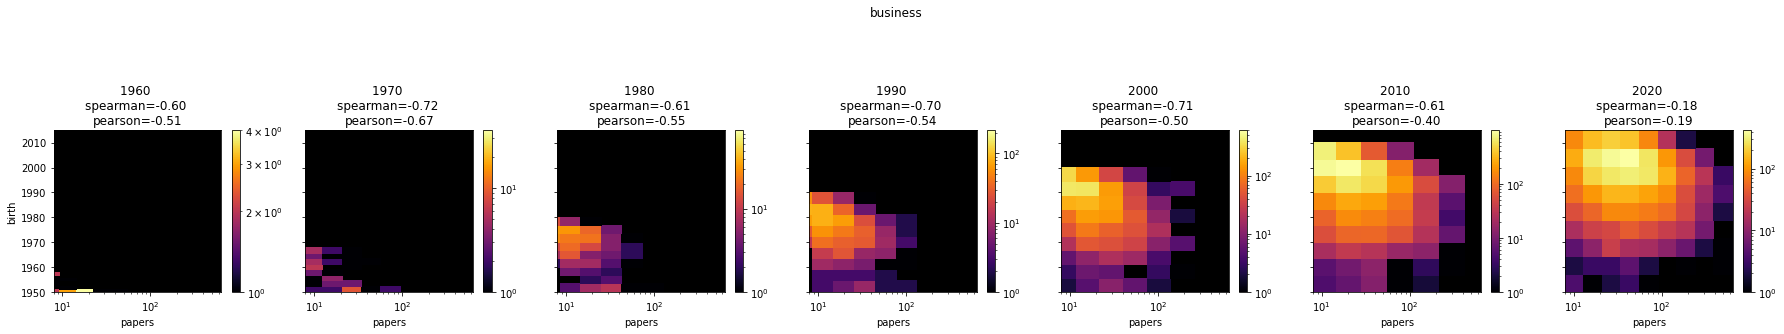

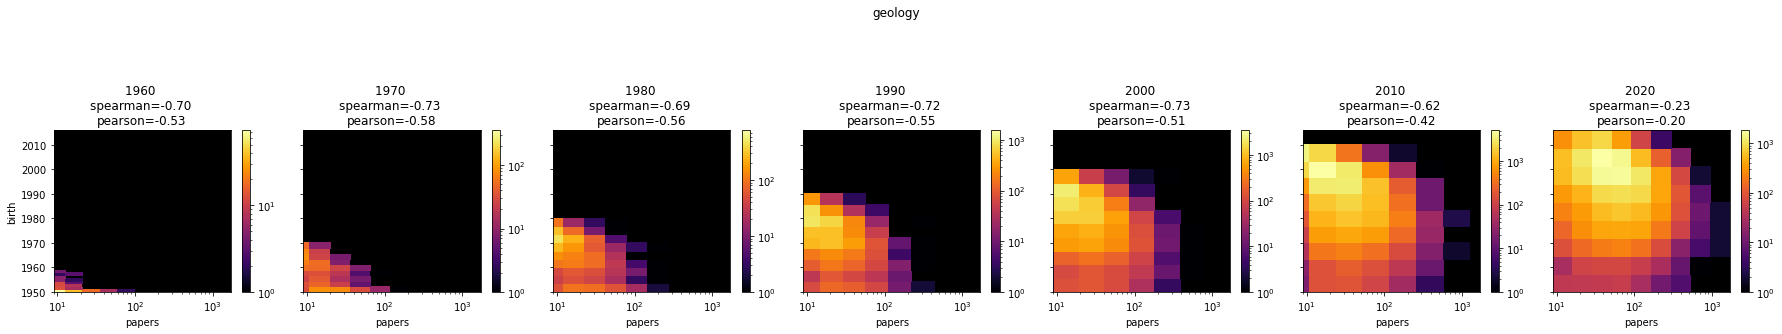

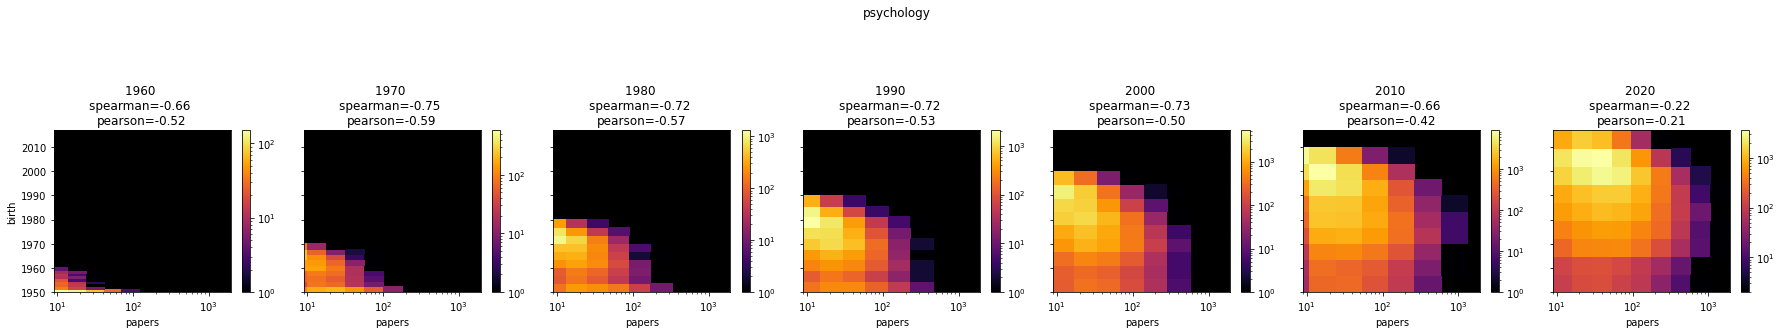

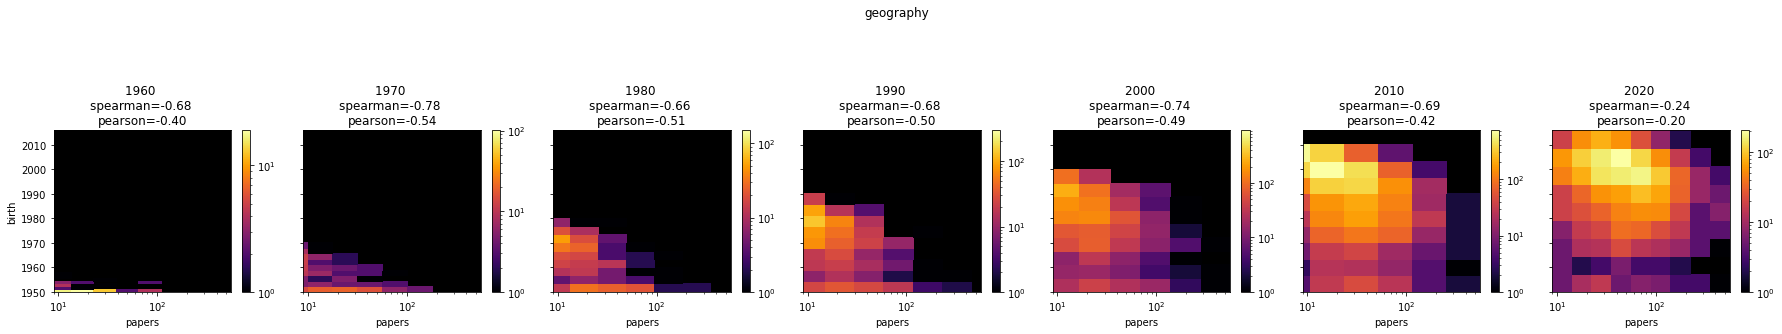

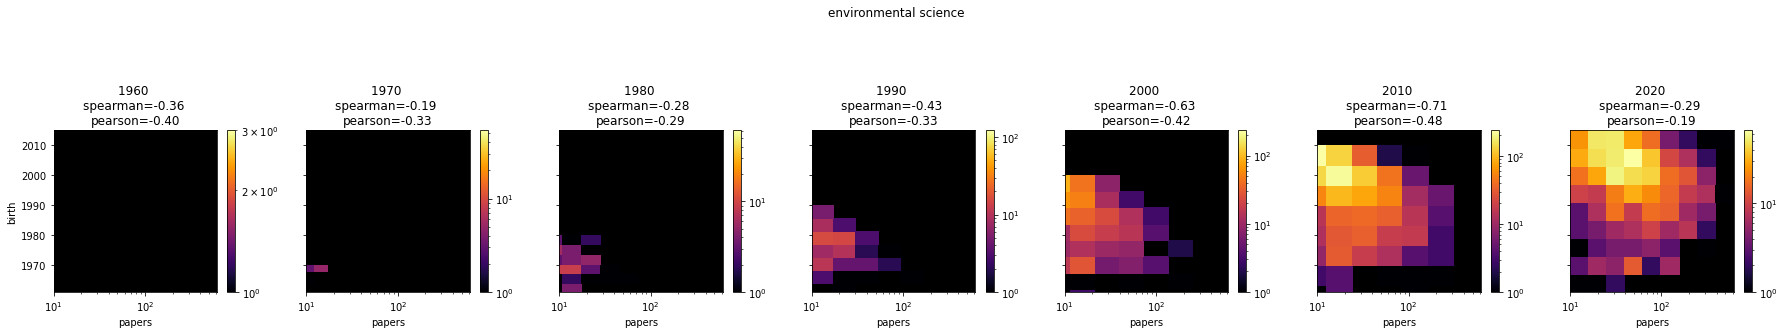

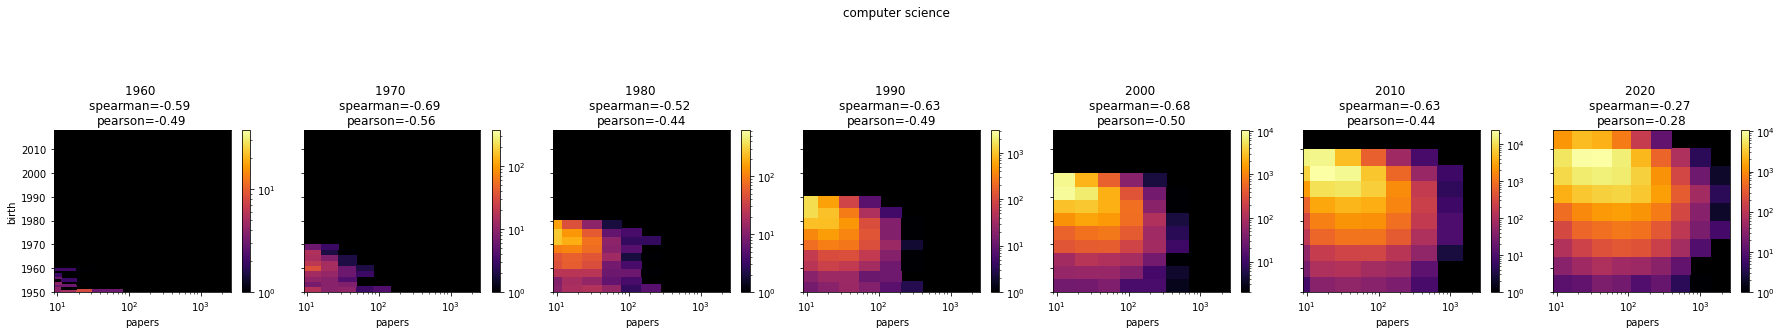

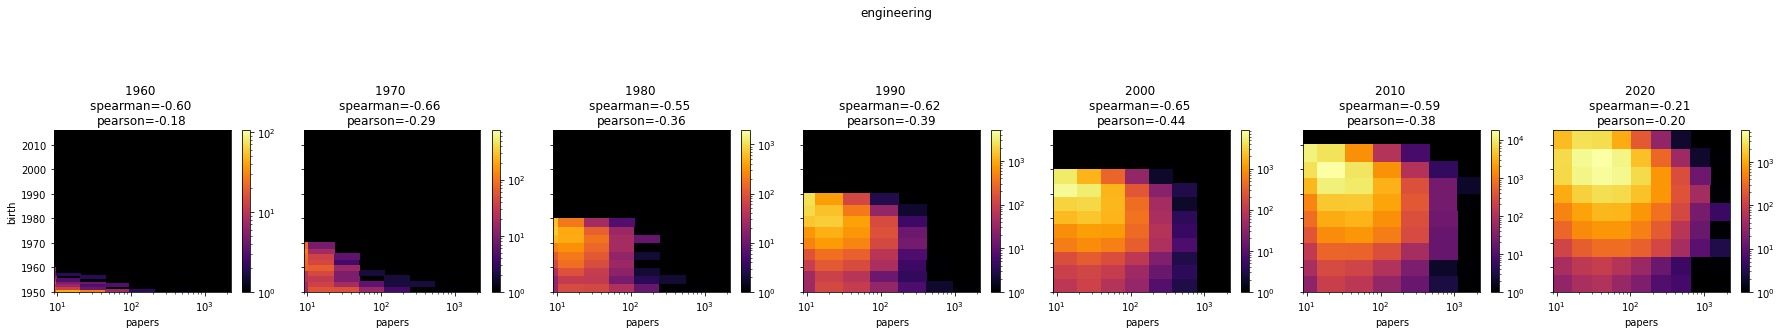

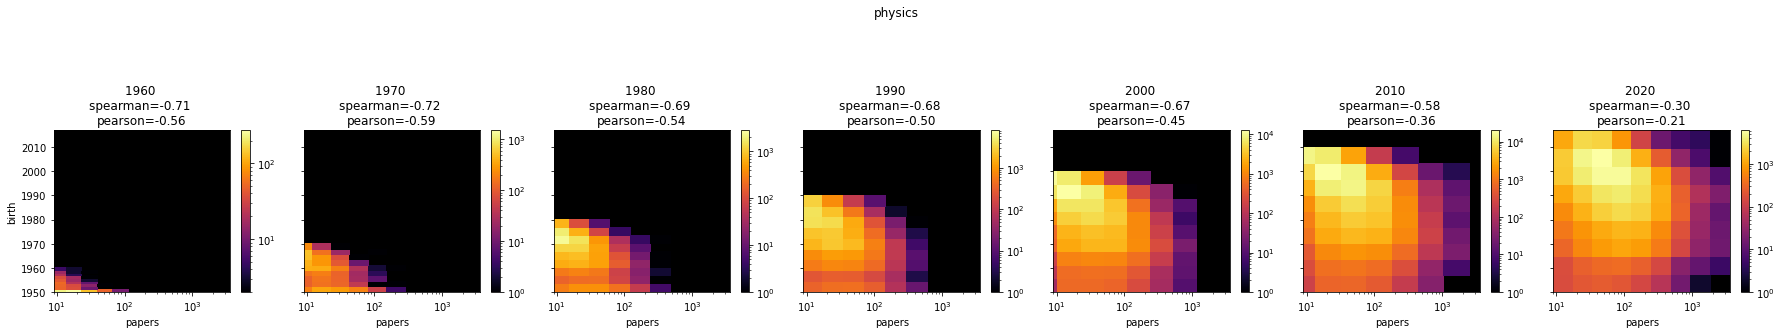

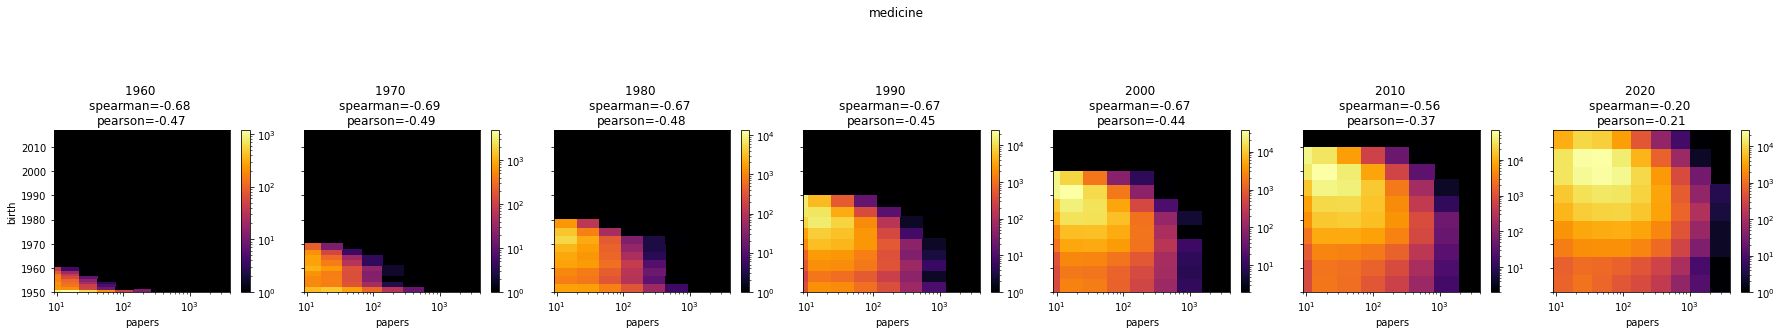

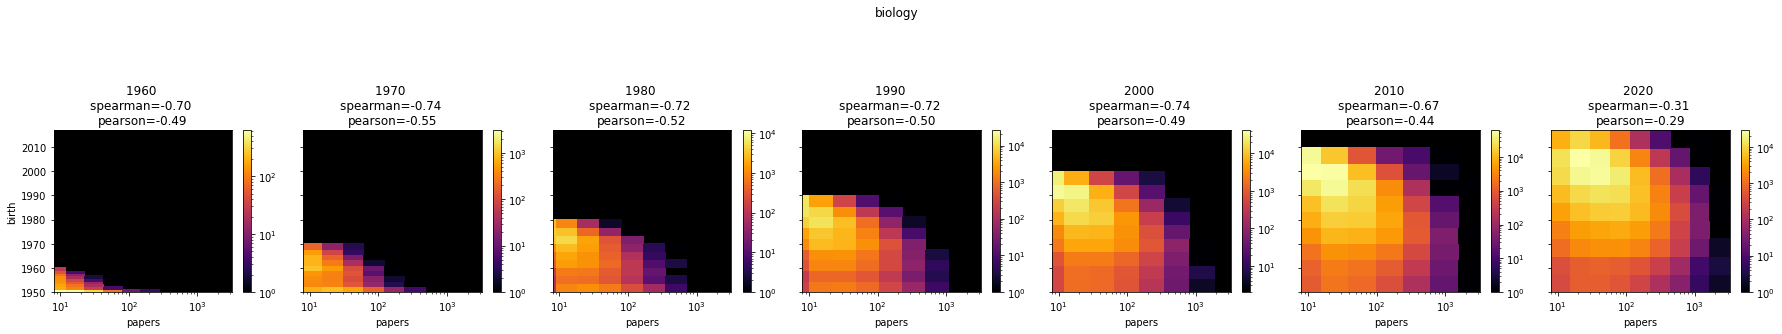

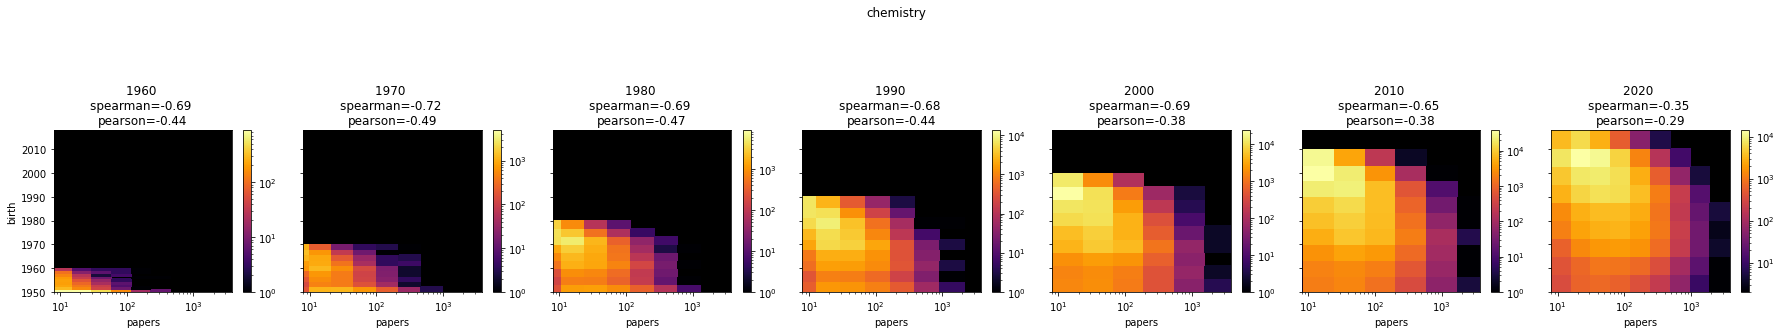

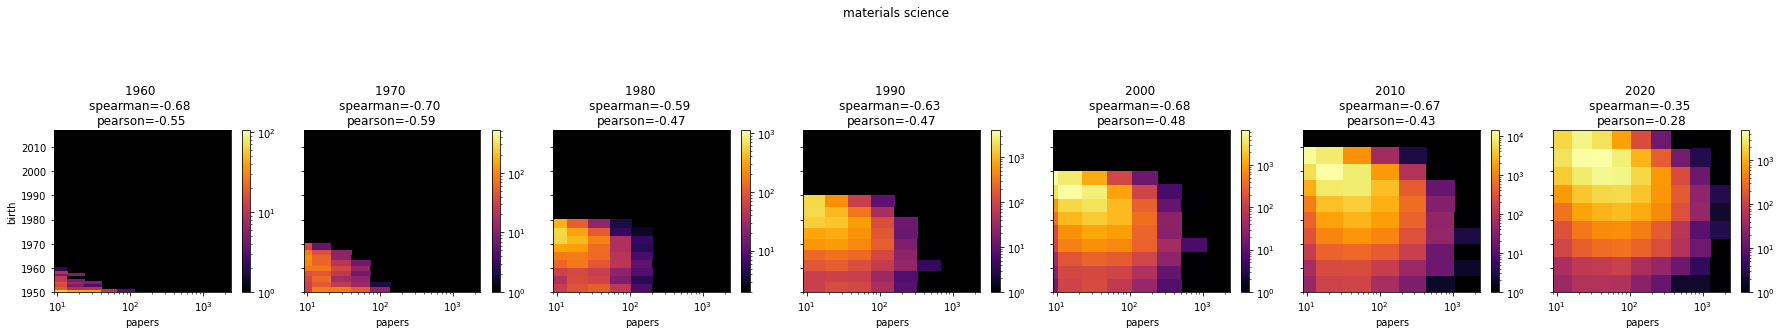

In [55]:
x_filename = 'results/papers_full_%d.json'
y_filename = 'results/birth_full_%d.json'
name = 'papers_ws'
xlabel = 'papers'
ylabel = 'birth'
xscale = 'log'
hist2d_temporal(x_filename, y_filename, name, xlabel, ylabel, xscale)

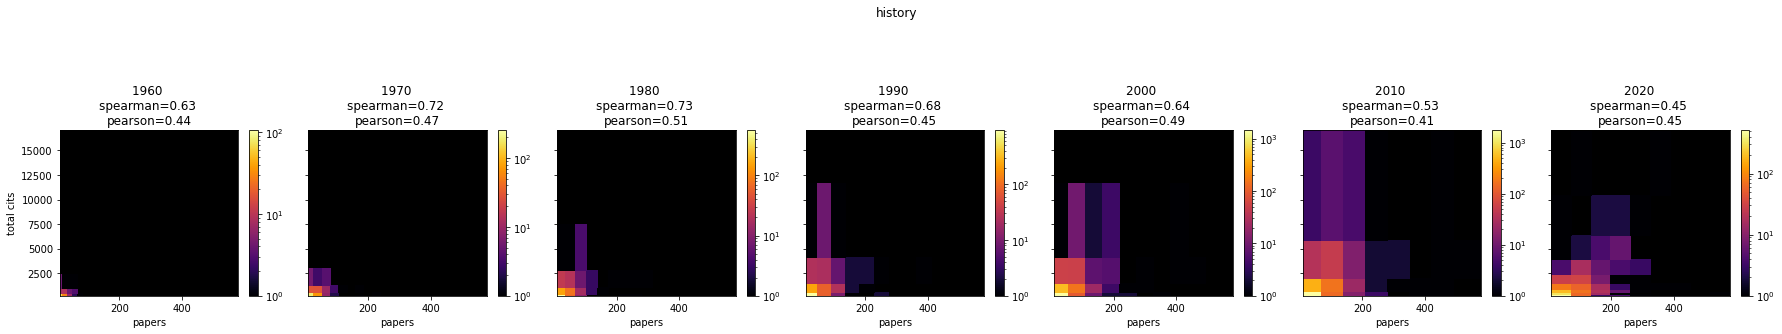

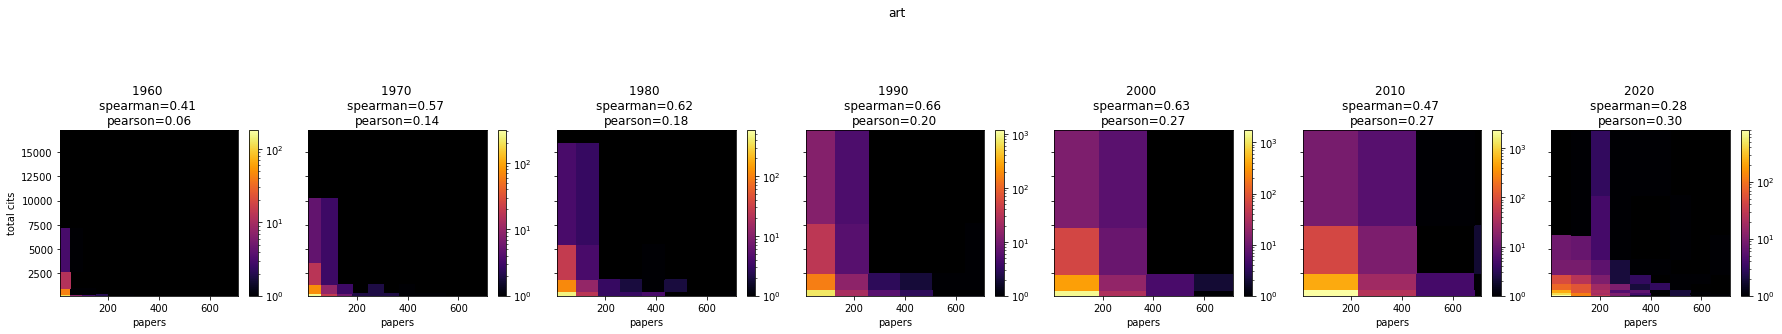

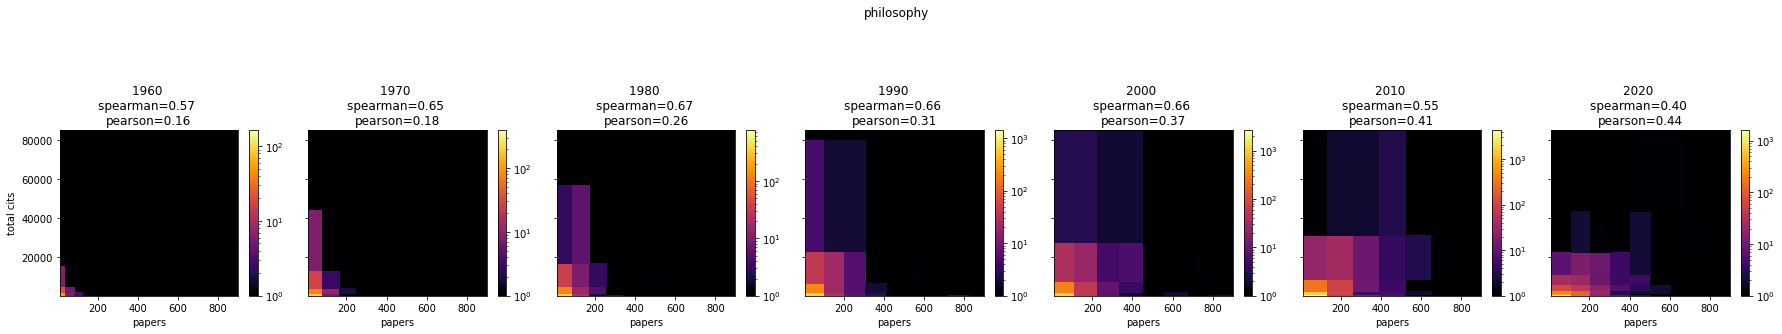

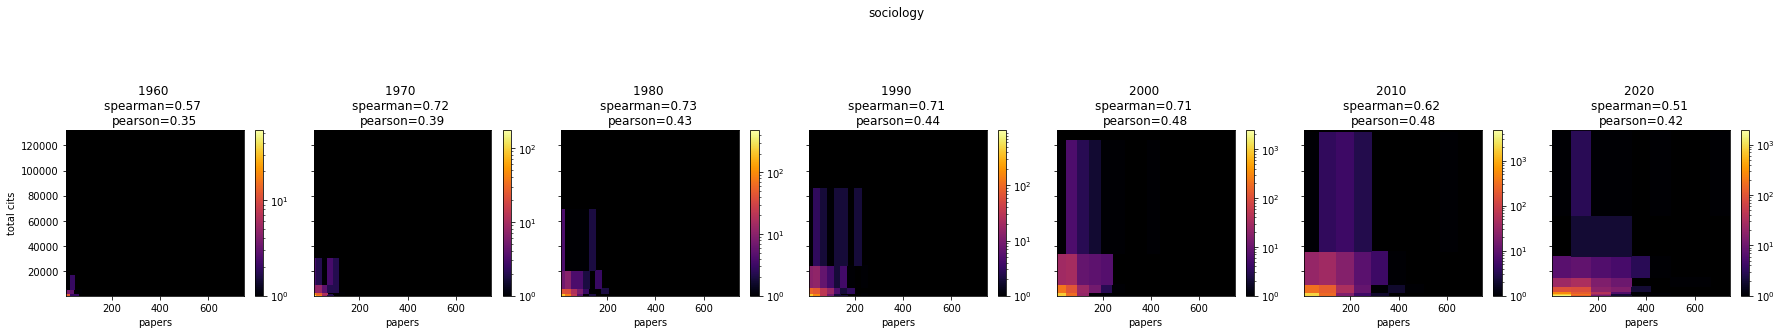

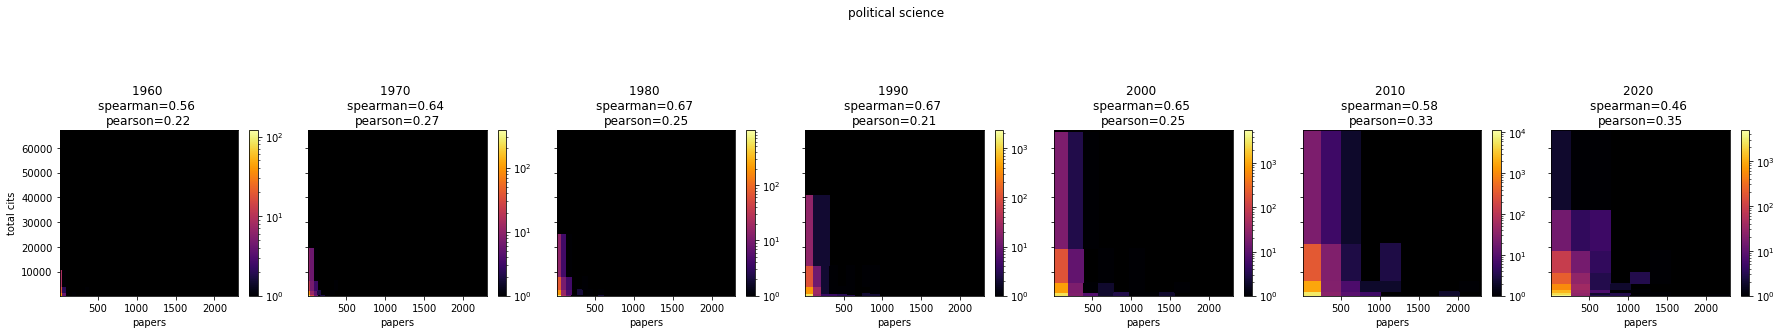

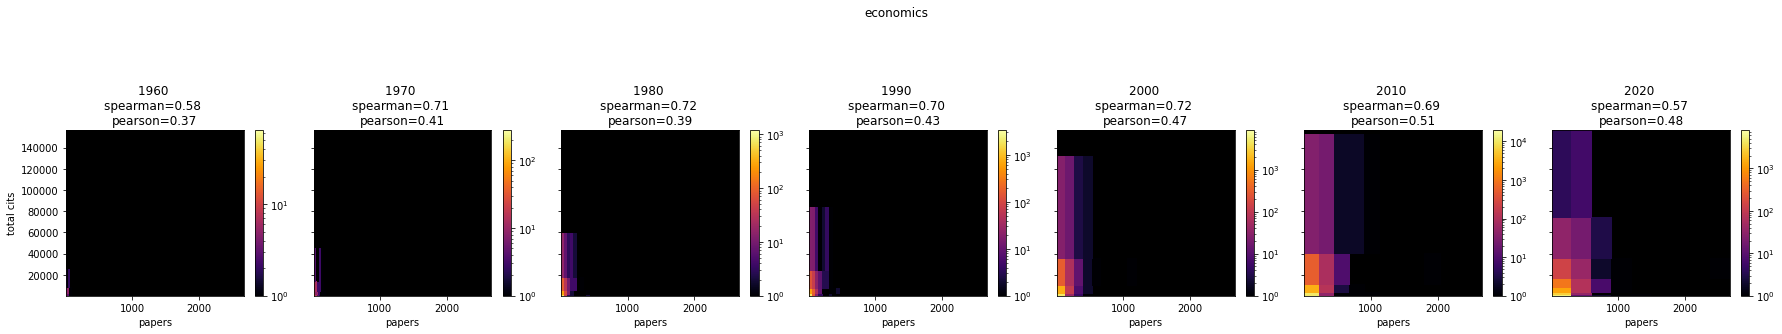

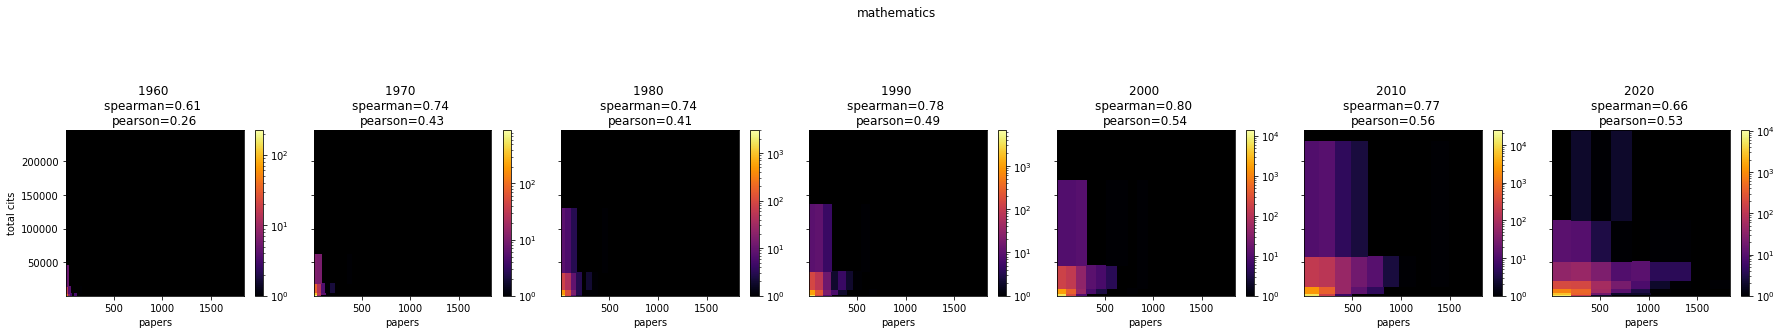

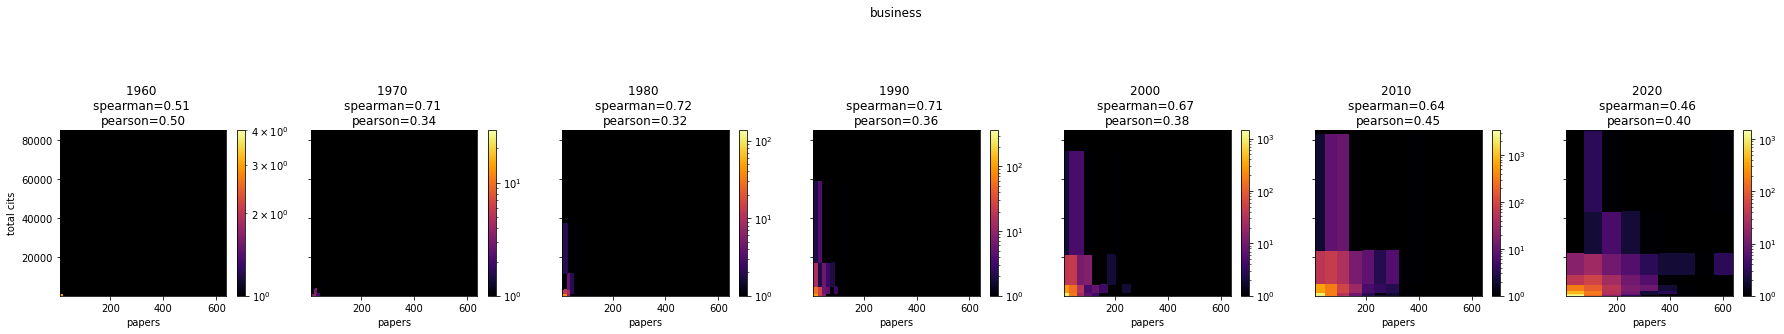

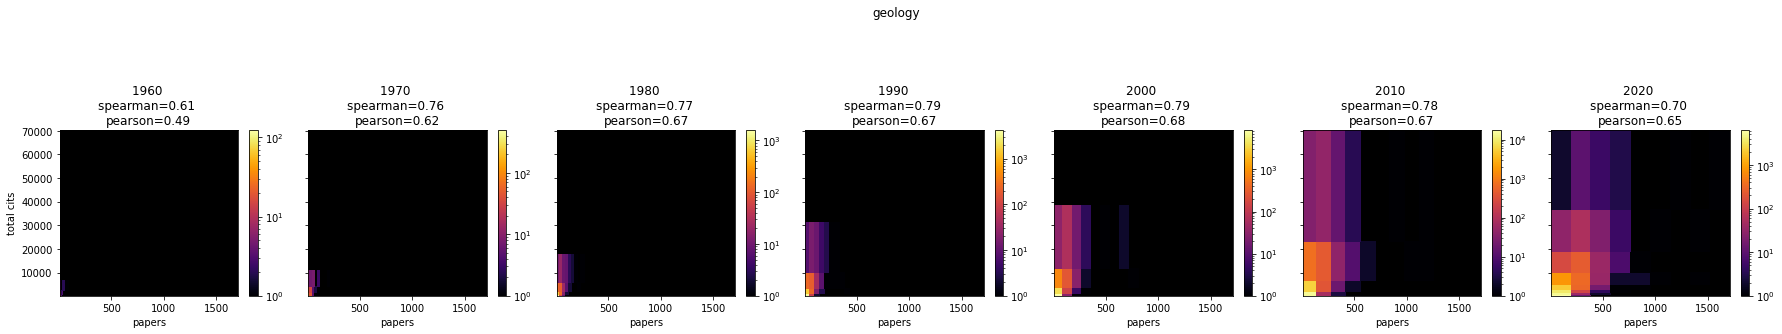

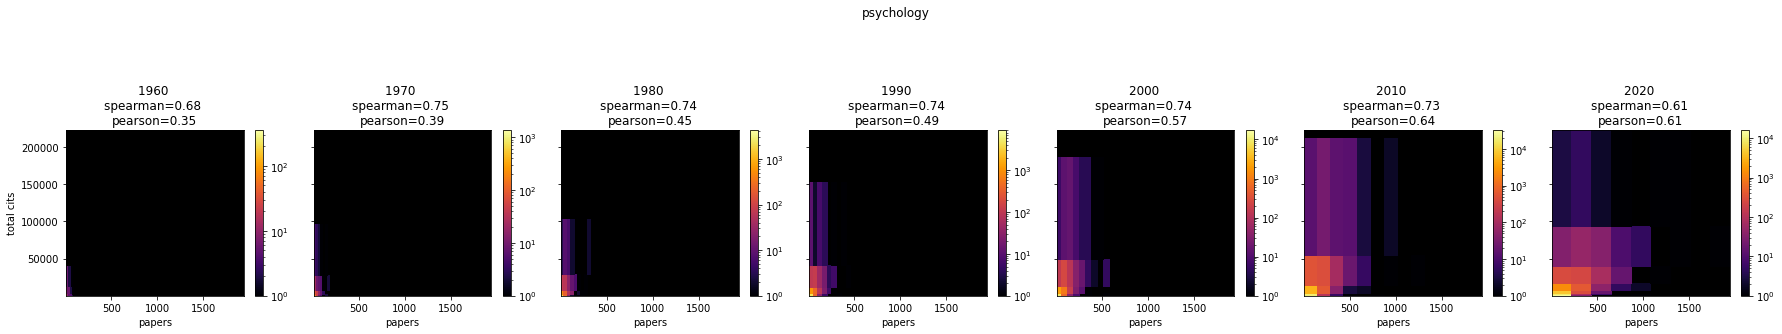

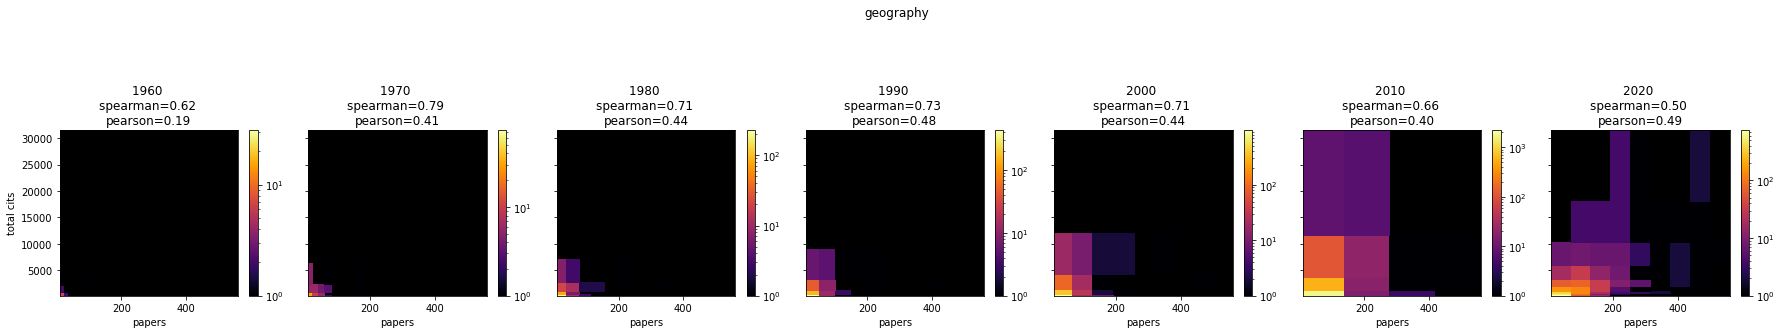

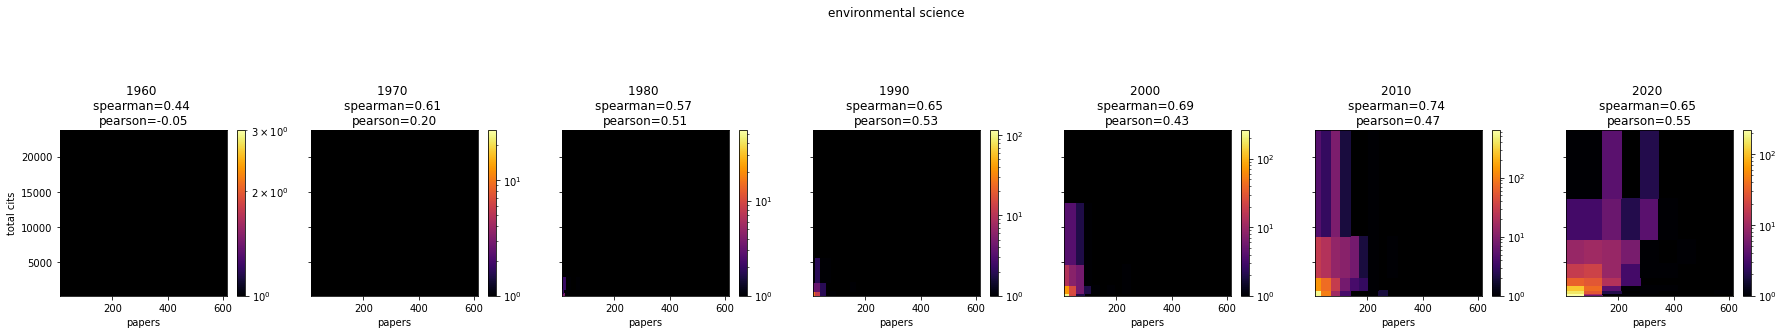

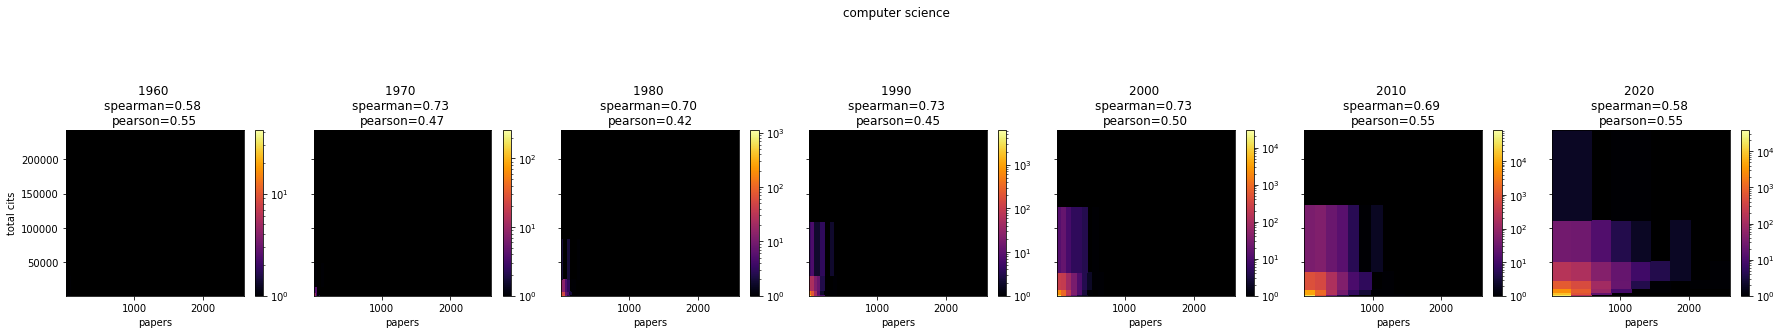

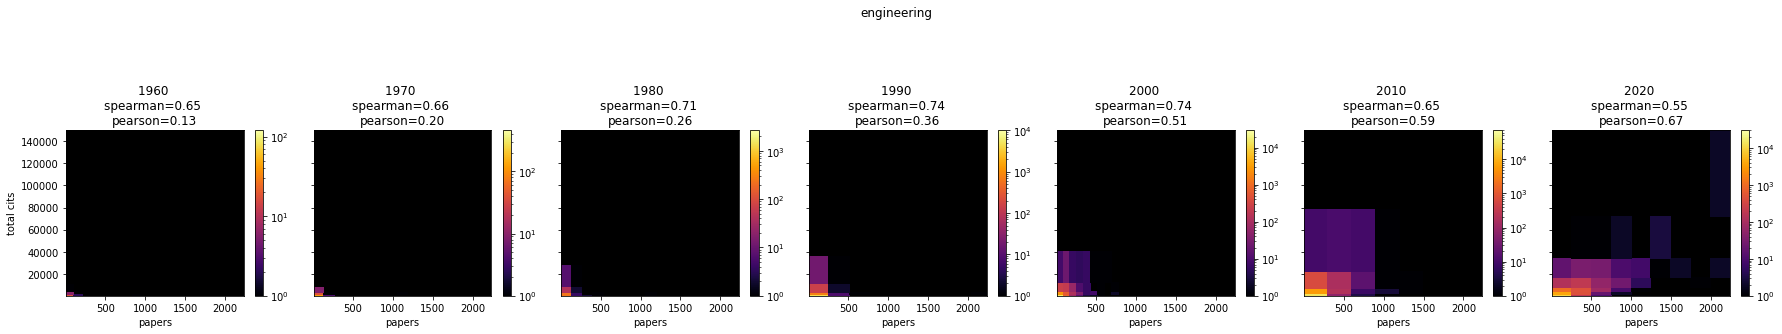

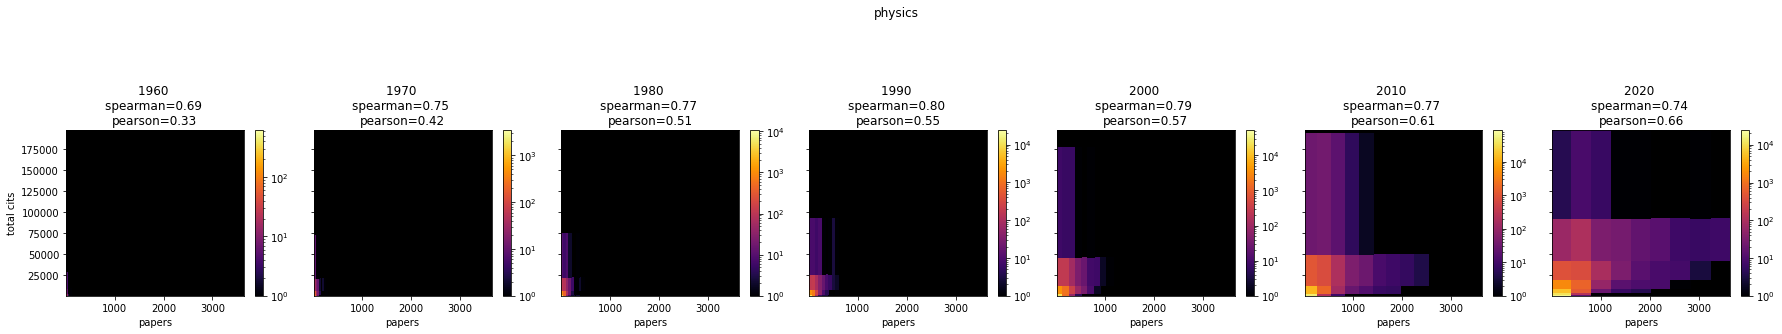

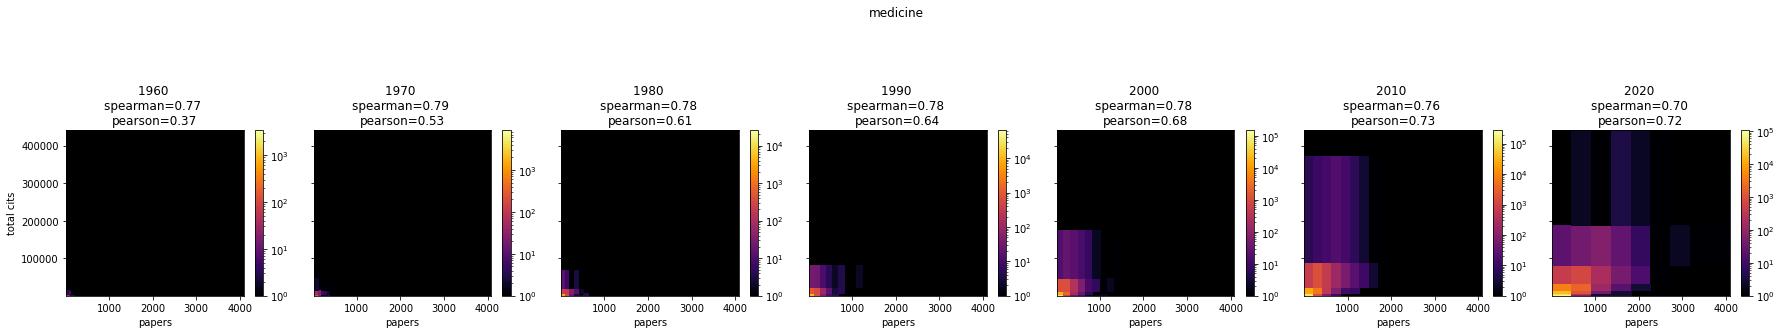

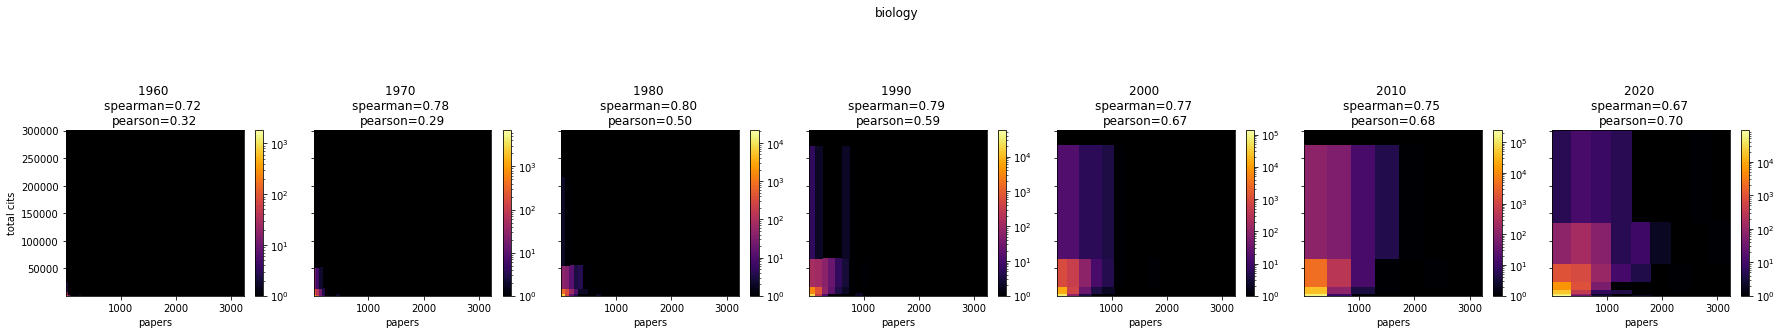

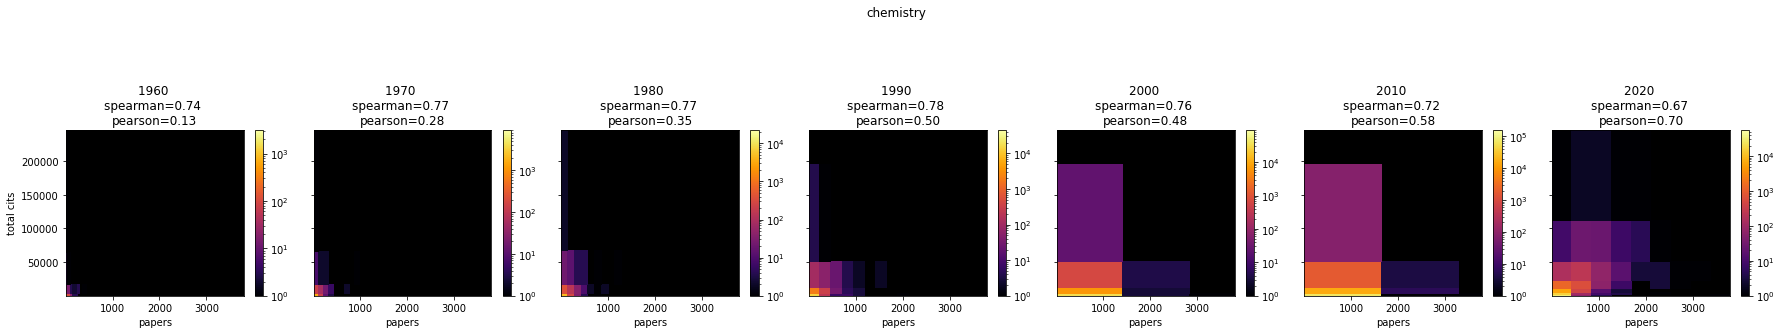

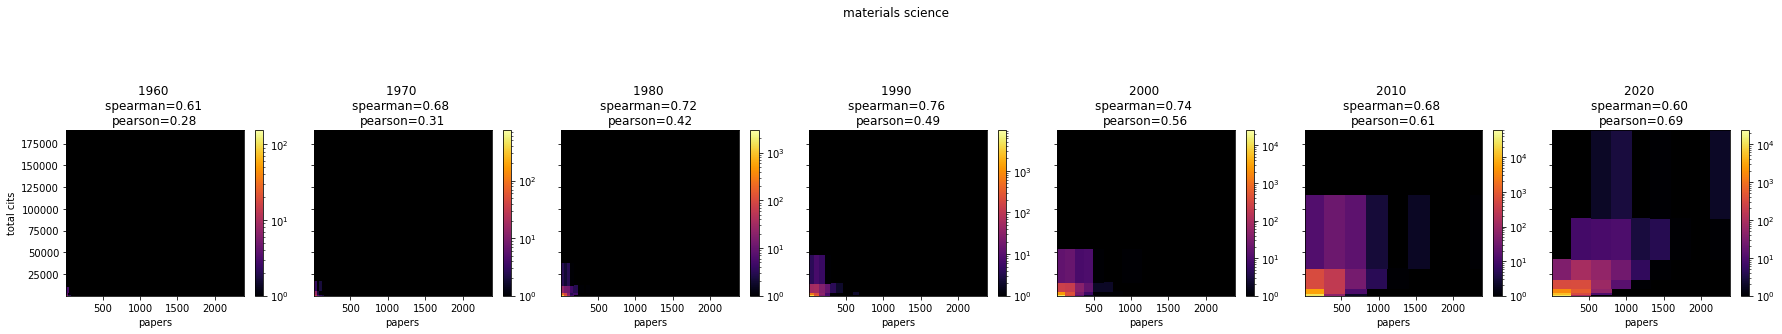

In [56]:
x_filename = 'results/papers_full_%d.json'
y_filename = 'results/cits_full_%d.json'
name = 'papers_cits'
xlabel = 'papers'
ylabel = 'total cits'
xscale = 'linear'
yscale = 'log'
hist2d_temporal(x_filename, y_filename, name, xlabel, ylabel, xscale, yscale)

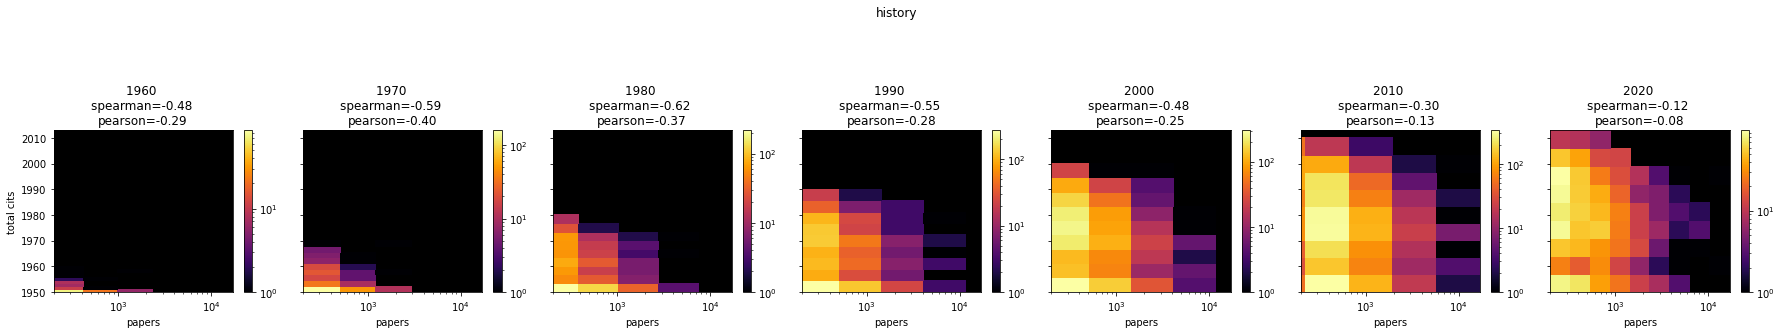

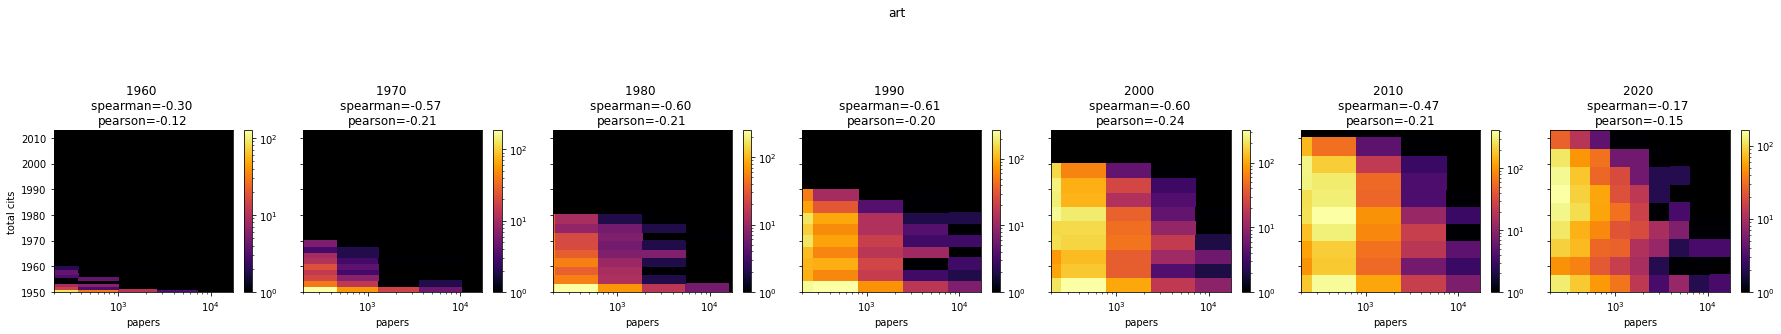

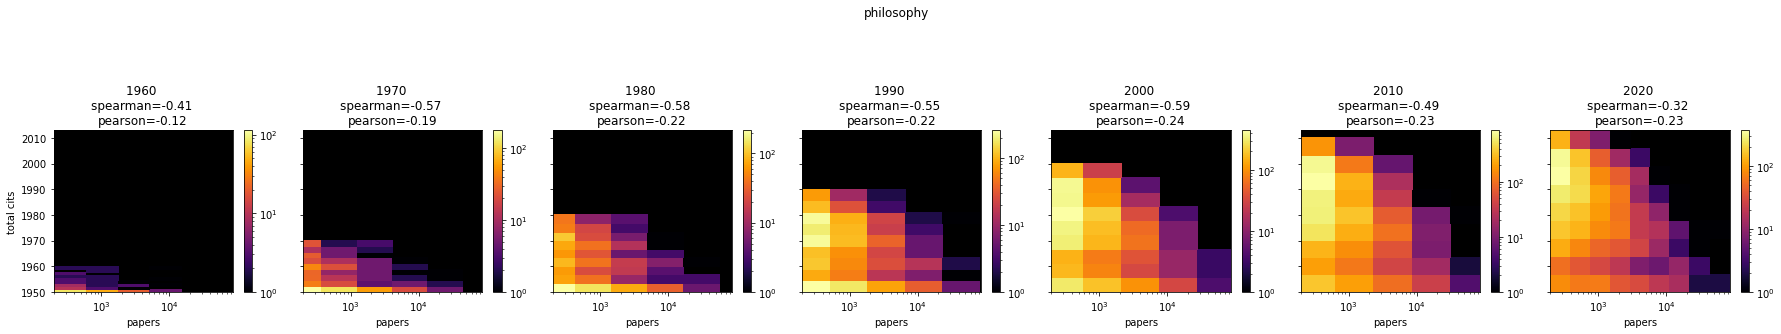

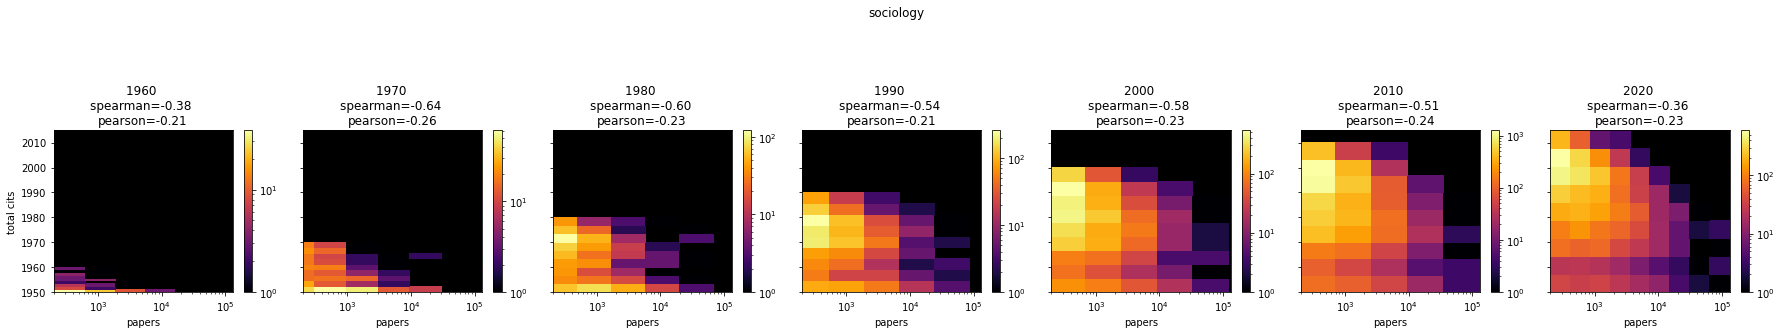

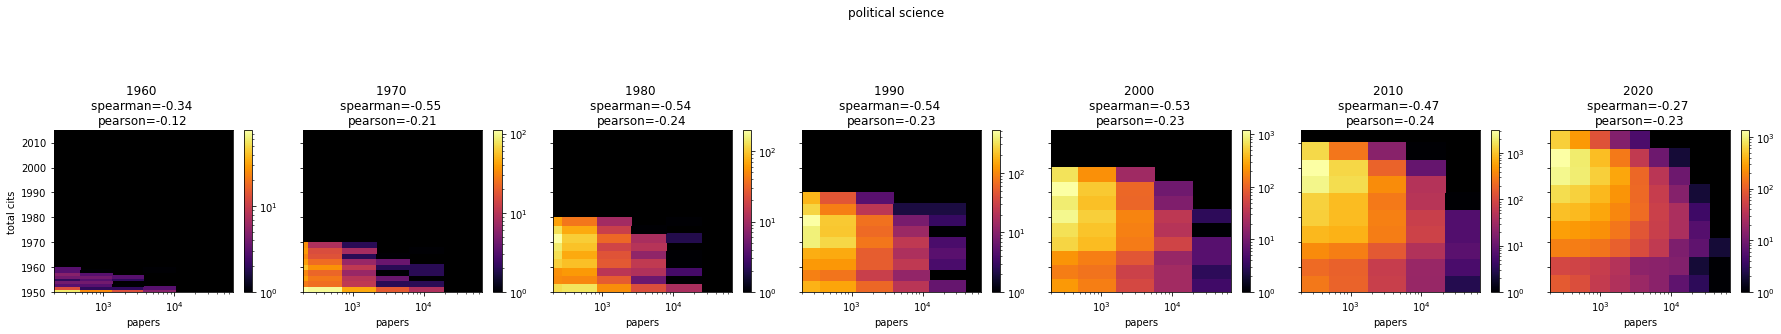

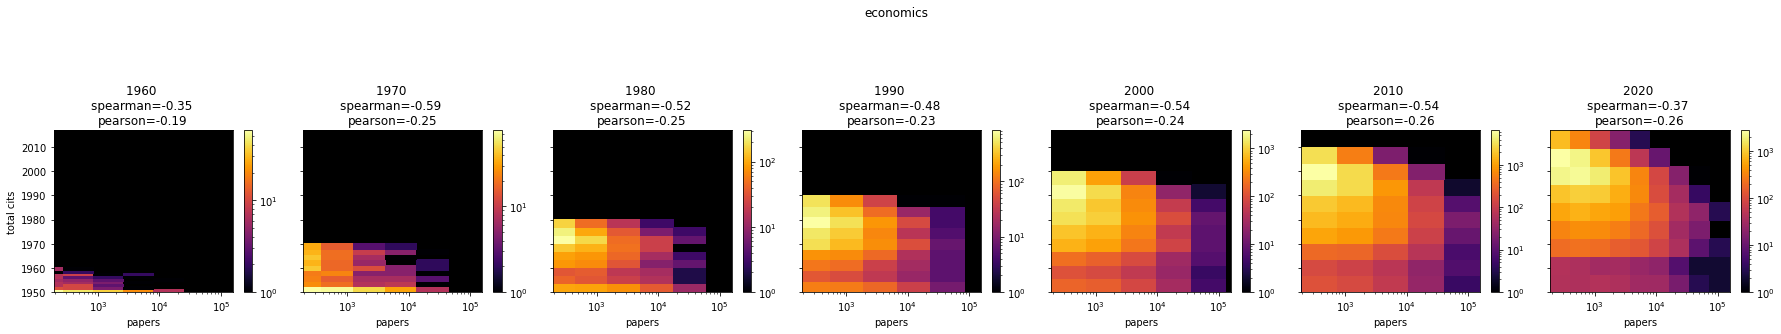

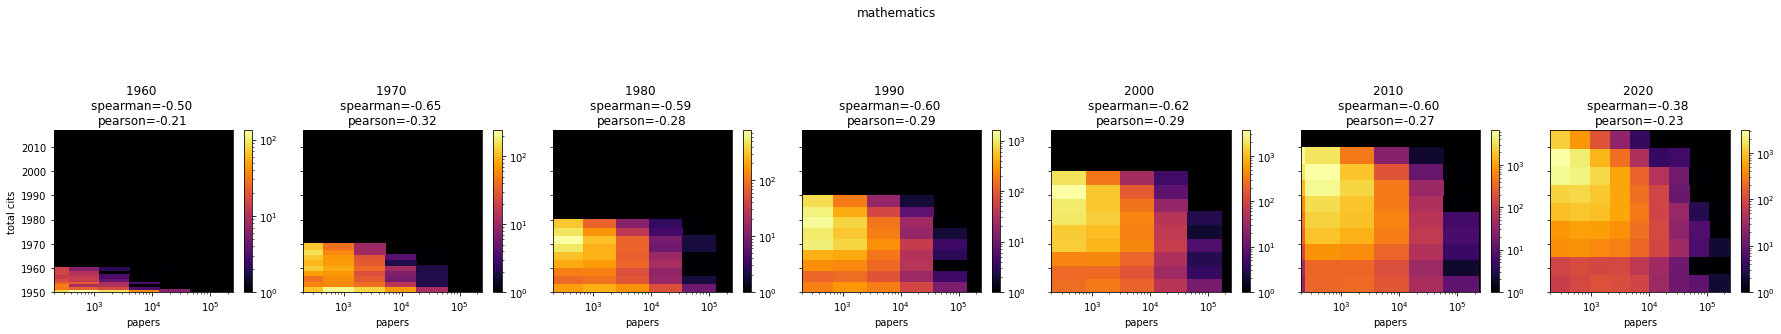

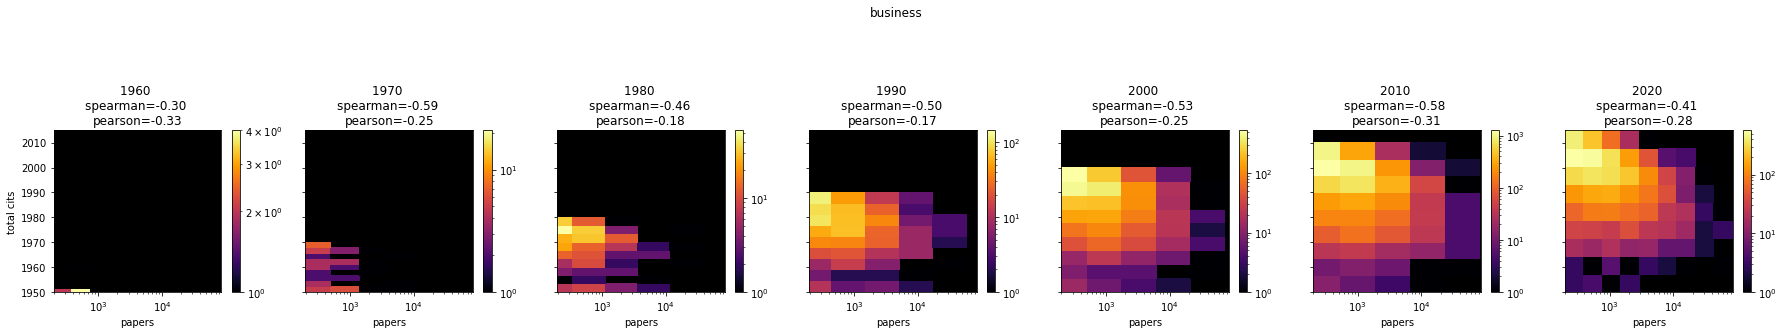

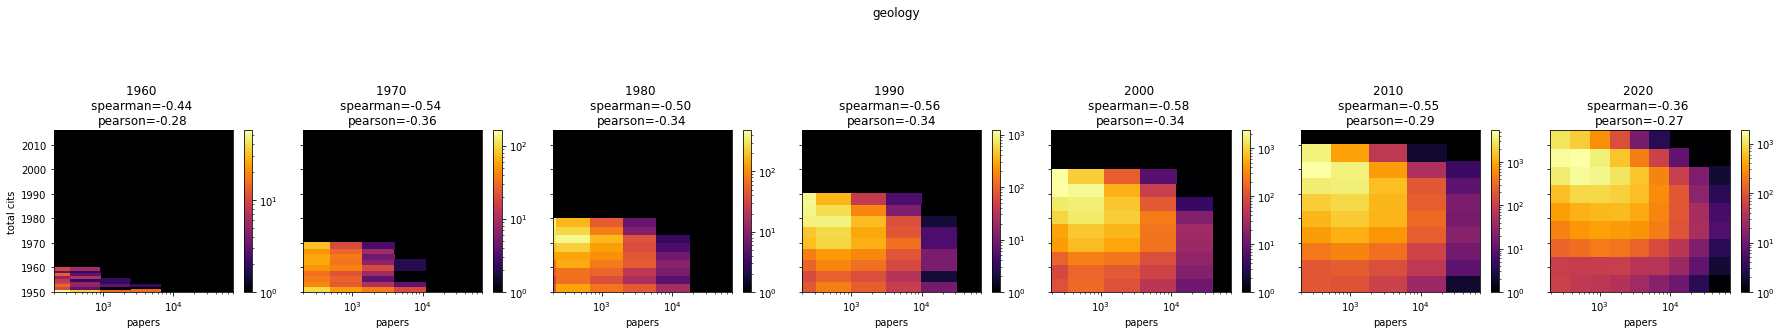

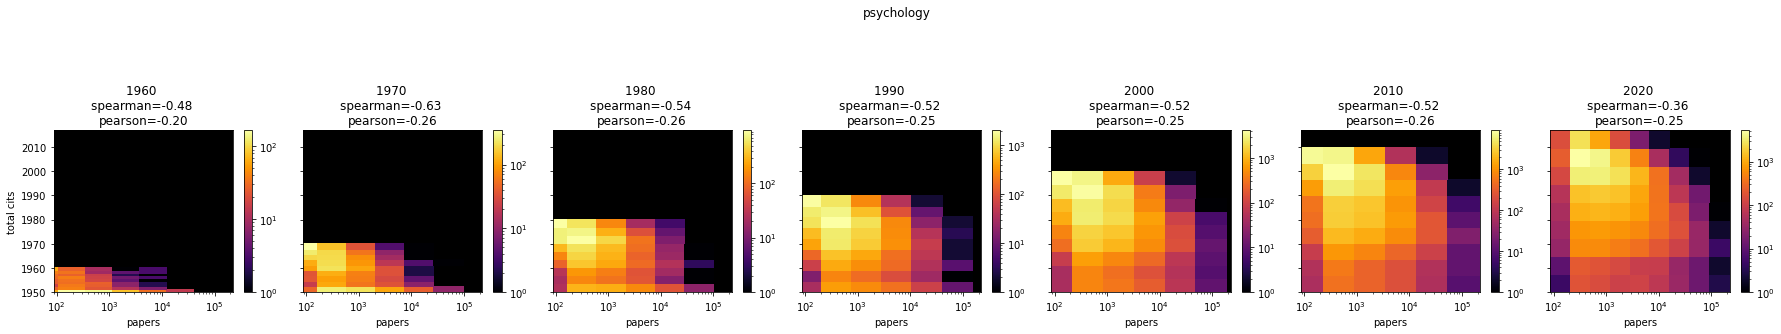

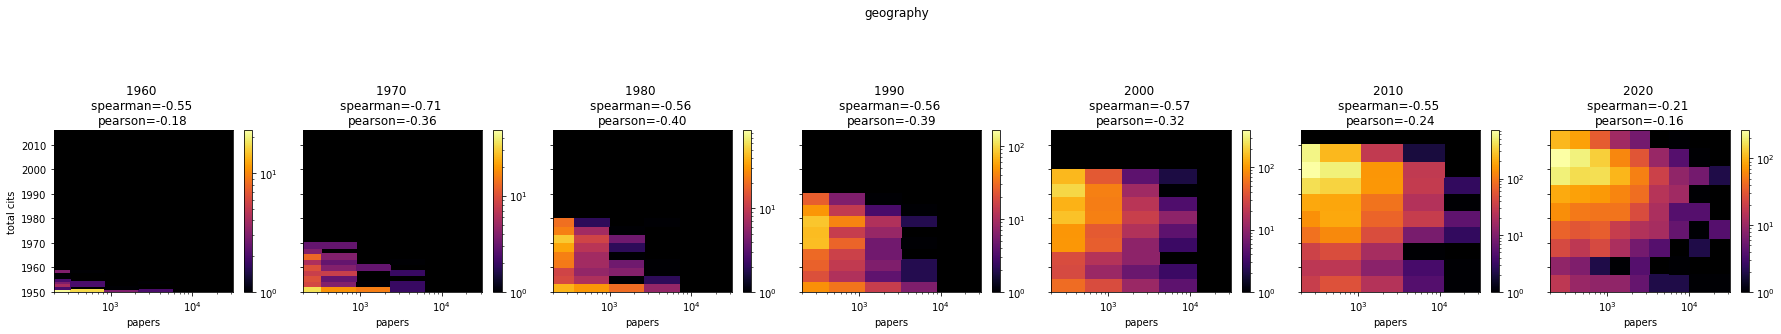

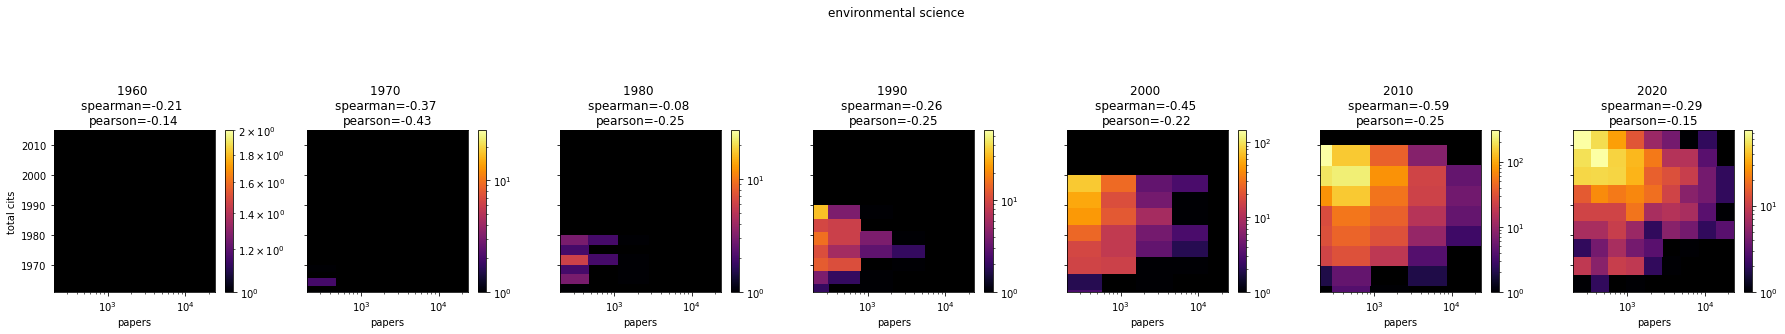

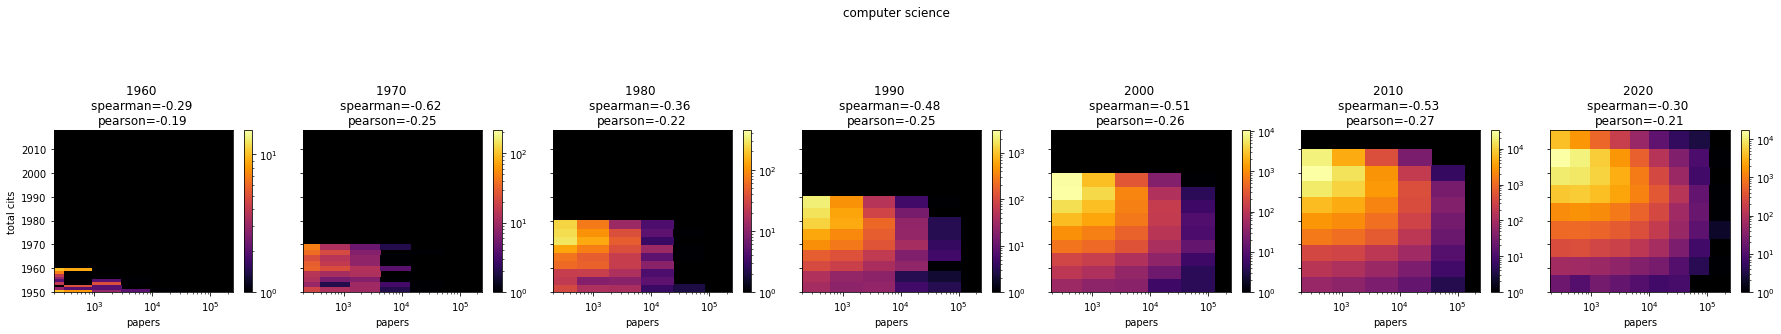

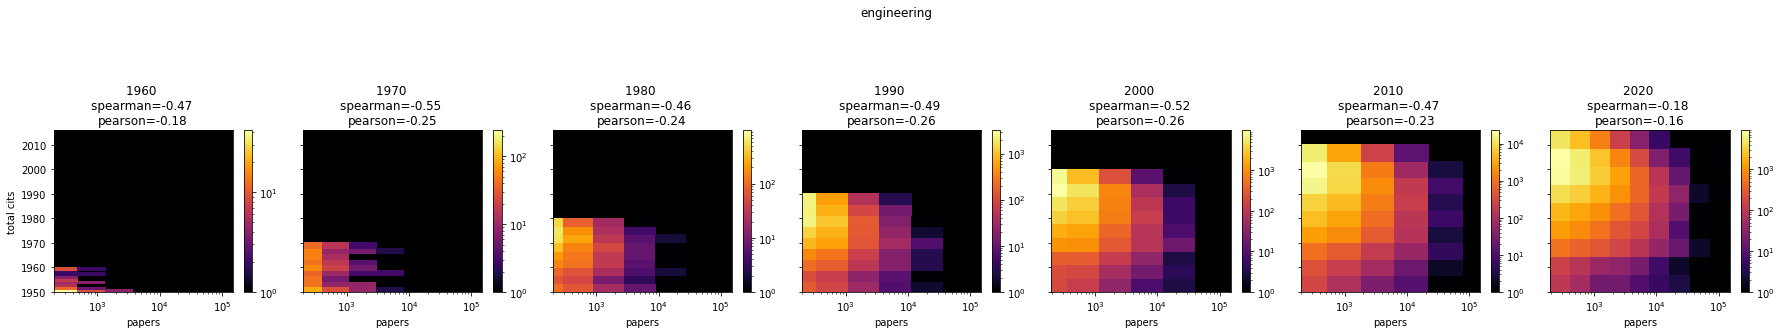

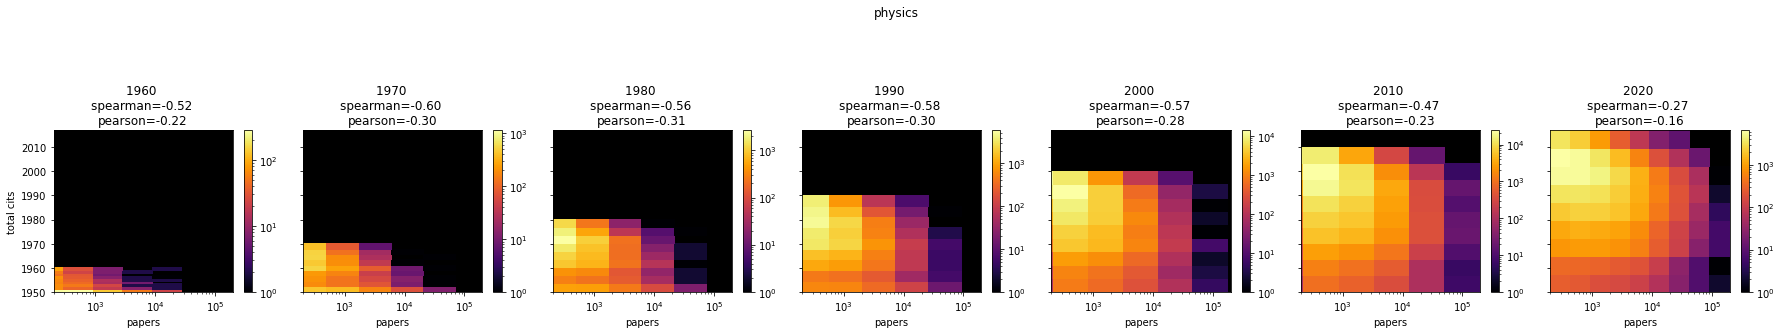

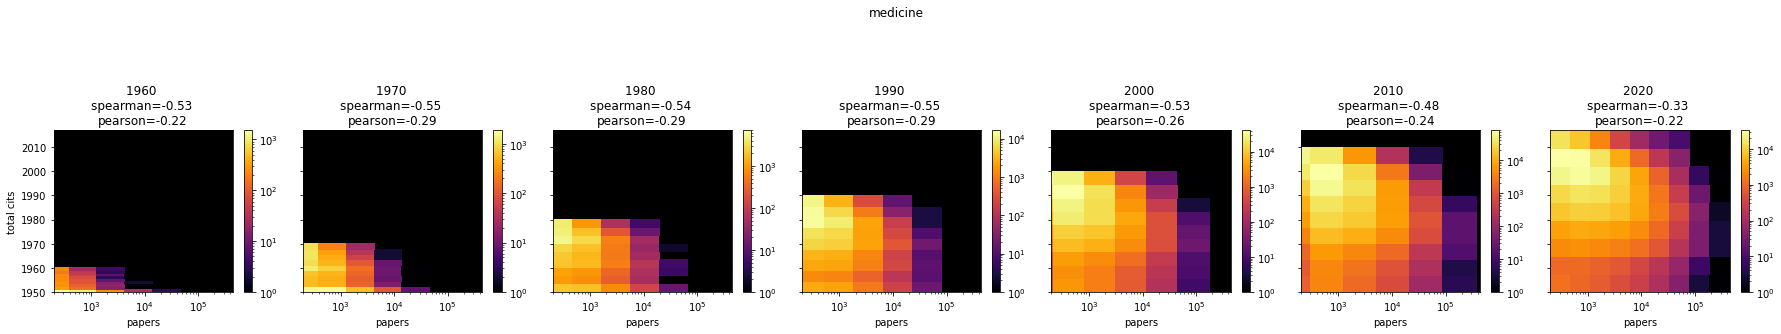

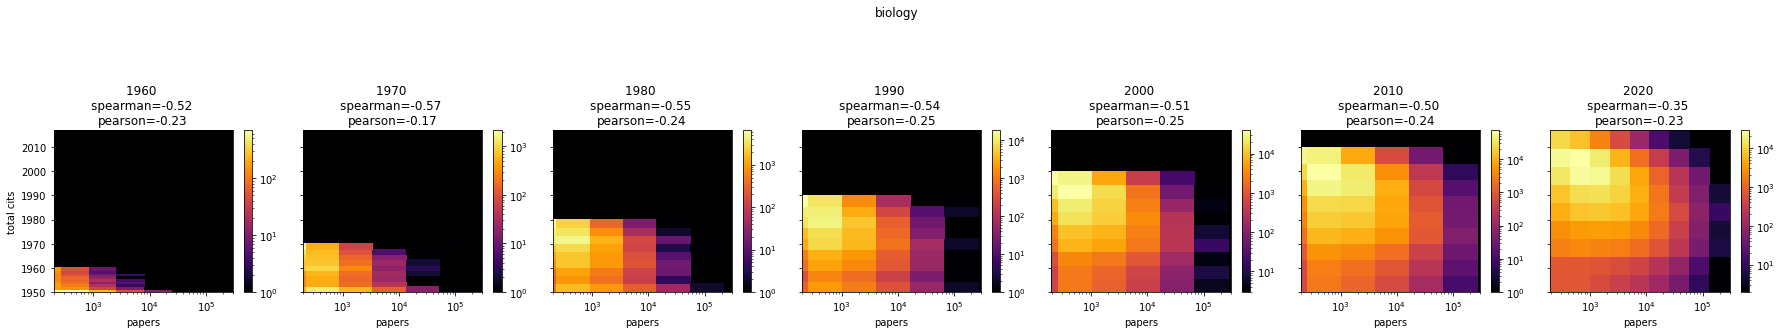

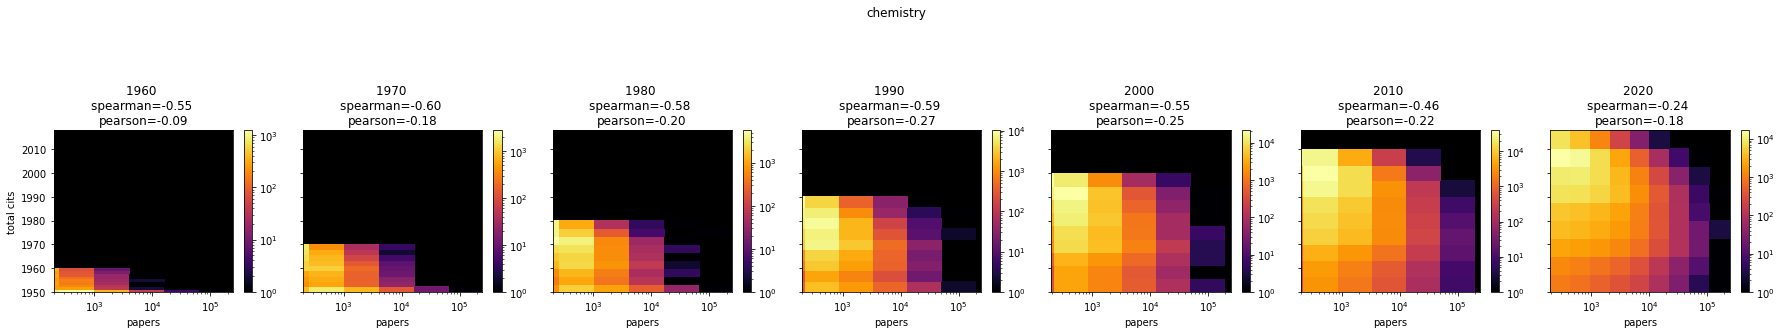

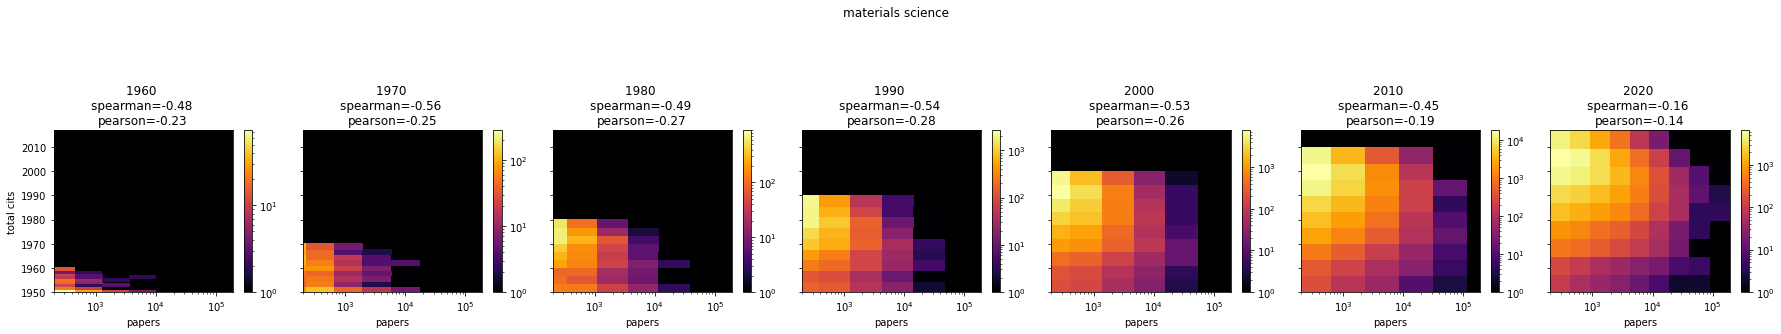

In [57]:
x_filename = 'results/cits_full_%d.json'
y_filename = 'results/birth_full_%d.json'
name = 'cits_birth'
xlabel = 'papers'
ylabel = 'total cits'
xscale = 'log'
yscale = 'linear'
hist2d_temporal(x_filename, y_filename, name, xlabel, ylabel, xscale, yscale)

/home/acmbrito/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/acmbrito/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/acmbrito/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or nda

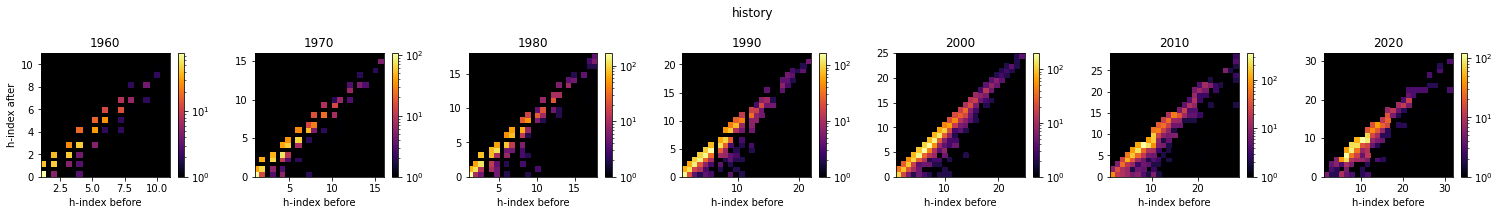

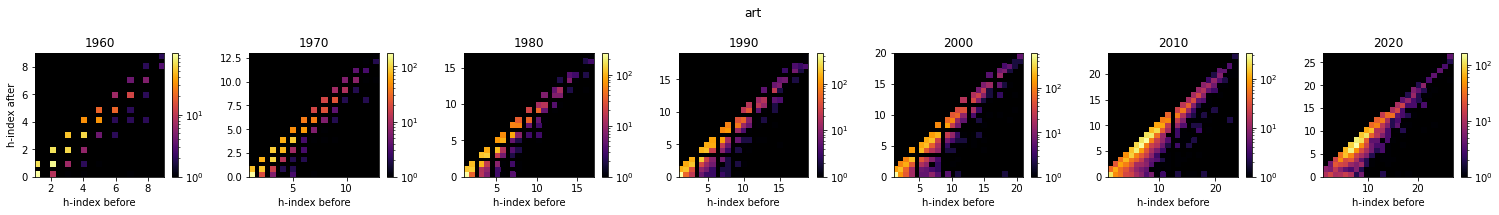

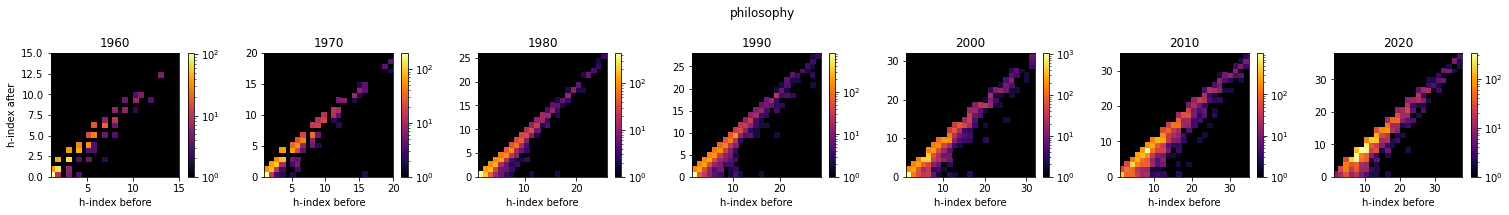

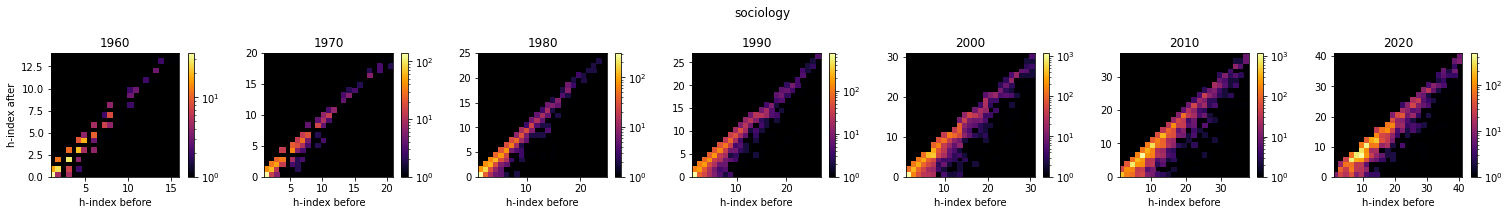

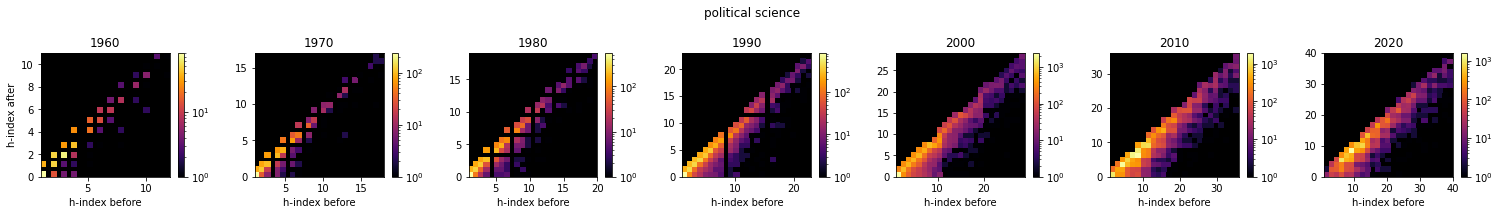

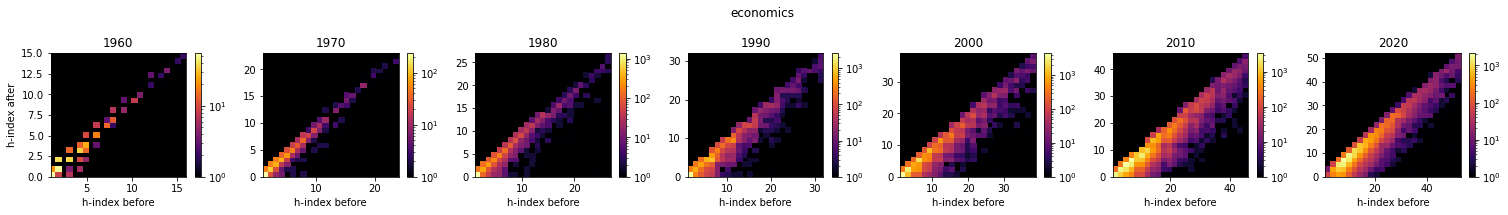

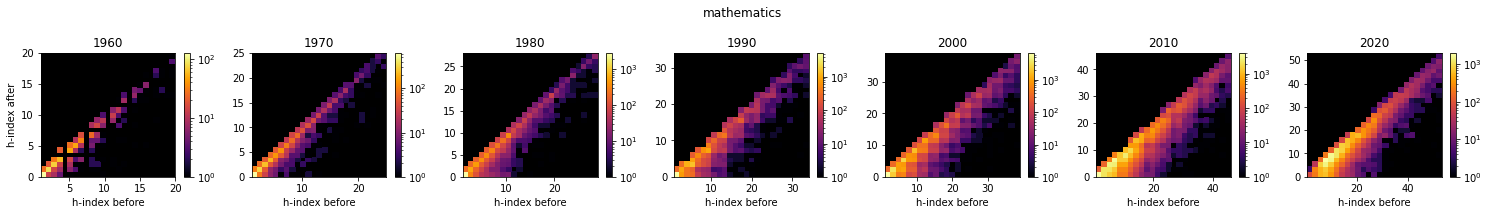

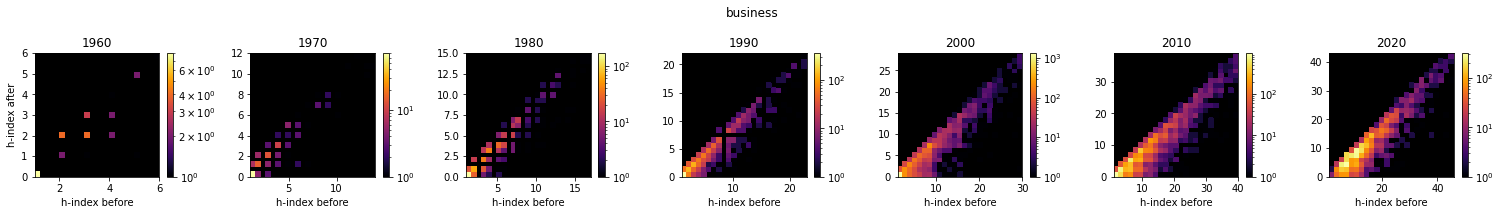

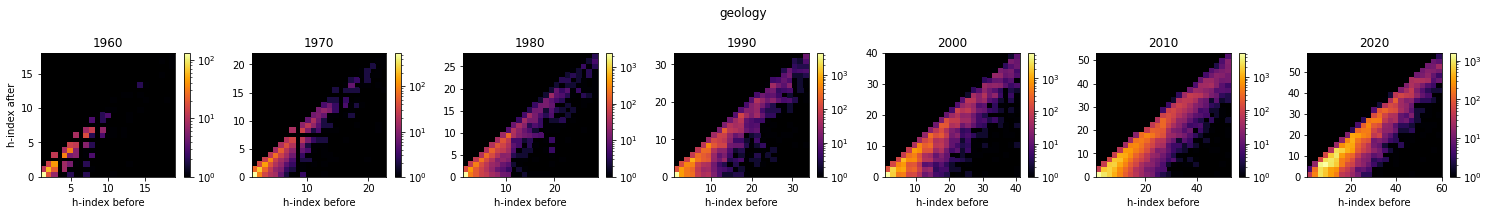

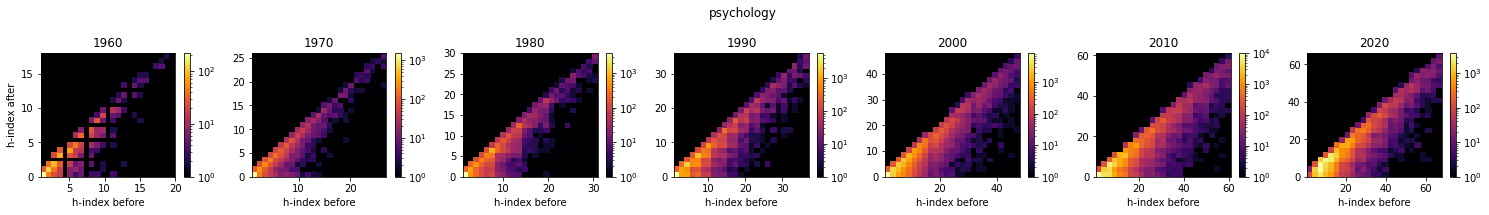

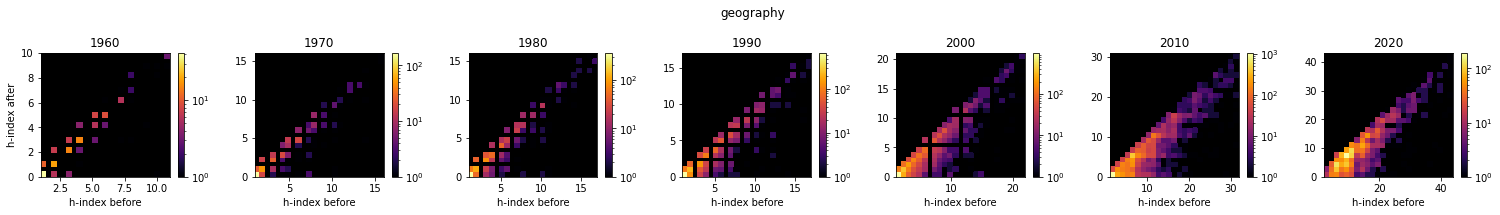

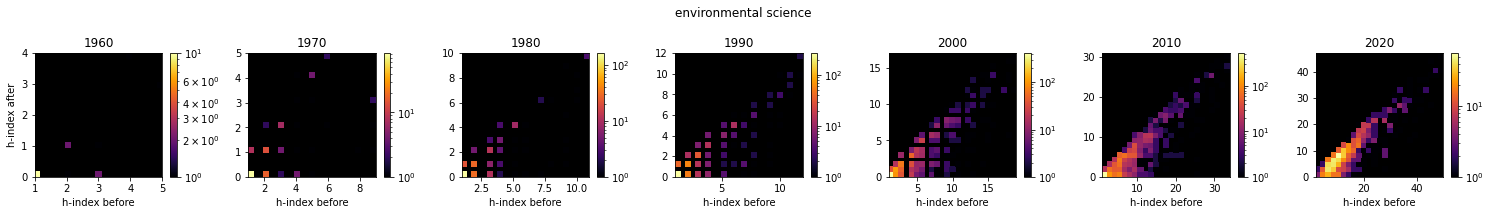

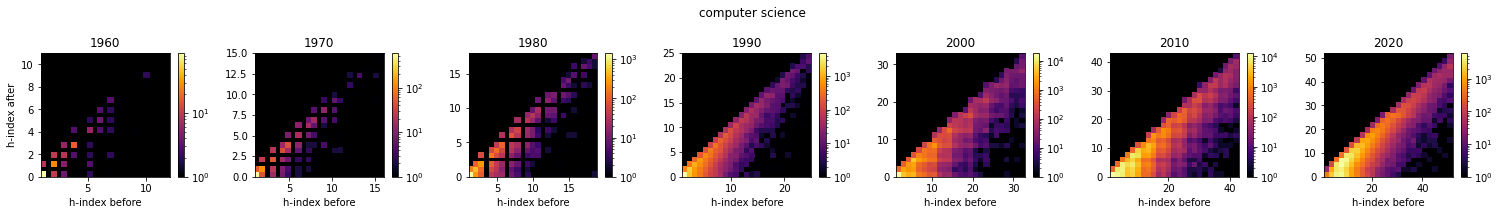

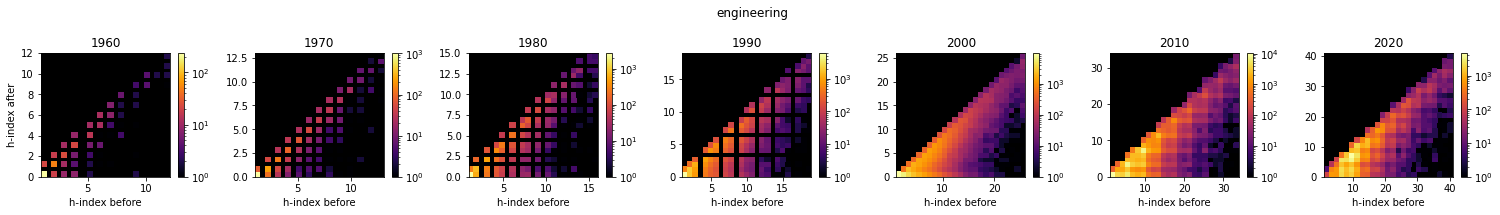

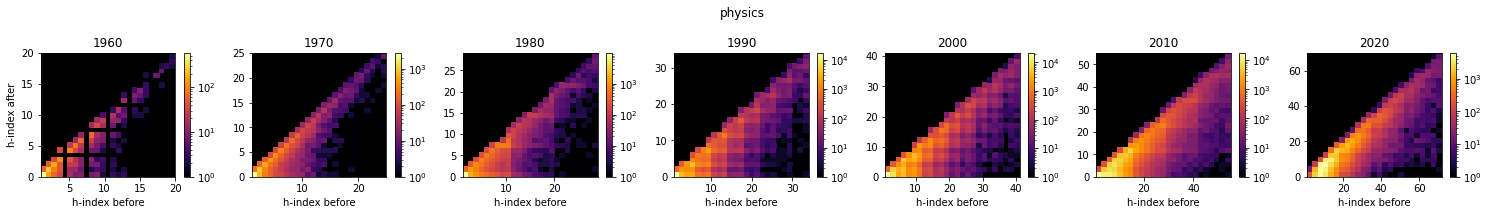

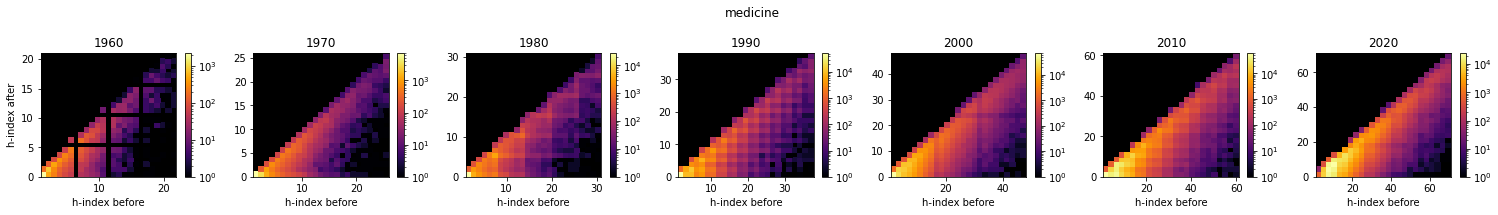

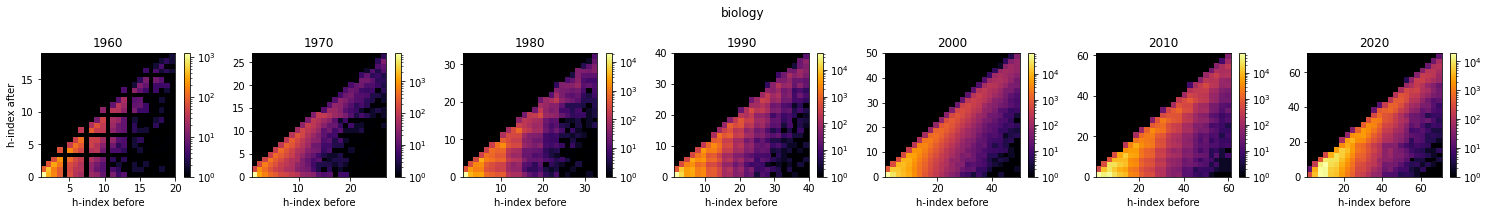

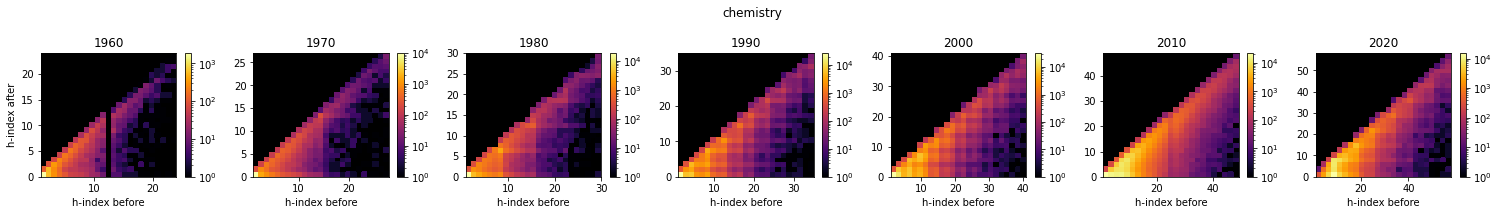

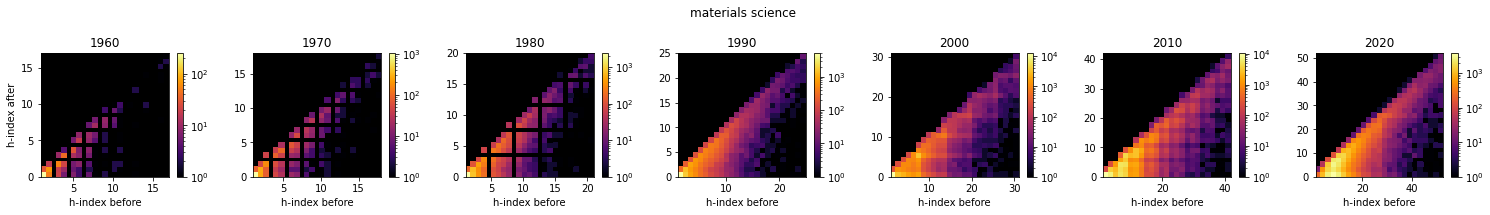

In [16]:
from s4_authors_stats import get_h_index

def _hindex_before_after_temporal(ax, field_name, valid_colabs_cit_list, valid_citation_list, valid_h_index):
    
    hindex_after = []
    
    for ccits, acits in zip(valid_colabs_cit_list, valid_citation_list):
        diff_cits = acits.copy() # json.loads(acits)
        for ctemp in ccits: # json.loads(ccits):
            diff_cits.remove(ctemp)
            
        hafter = get_h_index(diff_cits)
        hindex_after.append(hafter)
    
    hindex_before_l1 = np.asarray([row[0] for row in valid_h_index])
    hindex_after_l1 = np.asarray(hindex_after)[:,0]
    
    ax.set_facecolor("black")
    perc = np.percentile(hindex_before_l1, 99)
    im = ax.hist2d(hindex_before_l1[hindex_before_l1 <= perc], hindex_after_l1[hindex_before_l1 <= perc], 
           norm=LogNorm(), cmap='inferno', bins=(25, 25))
    ax.set_title(field_name)
    
    return im, hindex_after 


def hindex_before_after_temporal(suffix):
    hafter_map = {fos:dict() for fos in fos_sorted}
    for field in fos_sorted:
        fig,axes = plt.subplots(figsize=(21, 3), nrows=1, ncols=7)

        for i, tempsuffix in enumerate(range(1960, 2021, 10)):
            
            FOS = np.asarray(json.load(open('results/fos_full_%d.json' % tempsuffix)))
            X = np.asarray(json.load(open('results/citlist_full_%d.json' % tempsuffix)))
            Y = np.asarray(json.load(open('results/ch_full_%d.json' % tempsuffix)))
            H = np.asarray(json.load(open('results/hindex_full_%d.json' % tempsuffix)))
            idxs = FOS == field
            tempX = X[idxs]
            tempY = Y[idxs]
            tempH = H[idxs]
            im, hafter = _hindex_before_after_temporal(axes[i], '%d' % tempsuffix, tempX, tempY, tempH)
            hafter_map[field][tempsuffix] = hafter
    
            fig.colorbar(im[3], ax=axes[i])
            axes[i].set_xlabel('h-index before')
            if i == 0:
                axes[i].set_ylabel('h-index after')

        field_name = fos_infos[fos_infos['field_id'] == field].iloc[0, -1]
        fig.suptitle(field_name)
        fig.tight_layout()
        fig.savefig('outputs/fos_hist2d_before_after_%s_temporal.pdf' % (field_name))    
    
    return hafter_map
        
        
hafter_map = hindex_before_after_temporal(suffix=2020)


/home/acmbrito/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
100%|██████████| 1573/1573 [00:00<00:00, 43175.17it/s]
/home/acmbrito/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
100%|██████████| 2255/2255 [00:00<00:00, 37600.40it/s]
/home/acmbrito/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecatio

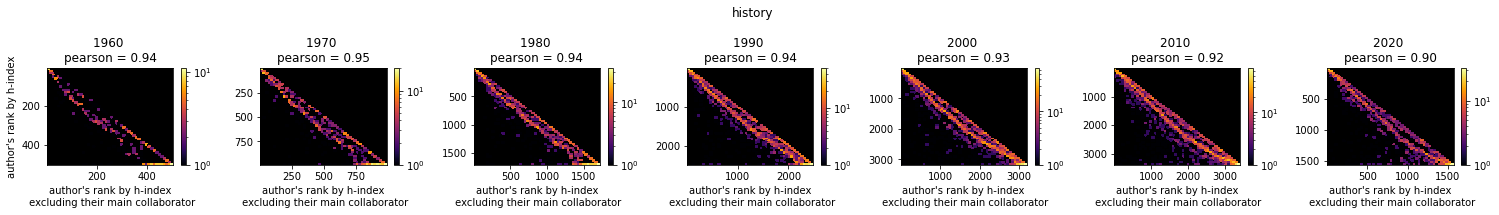

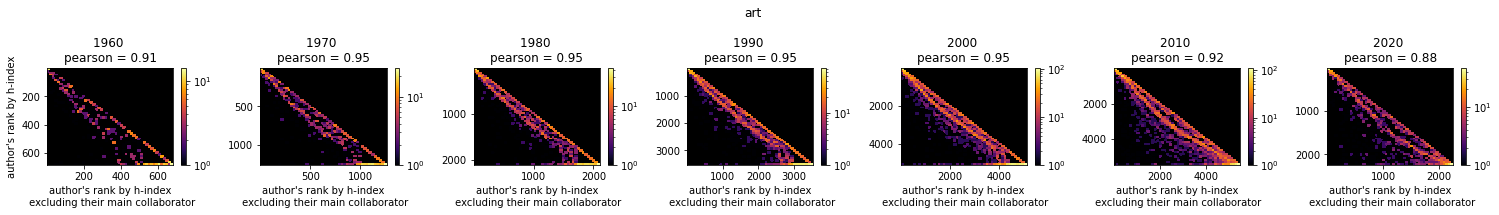

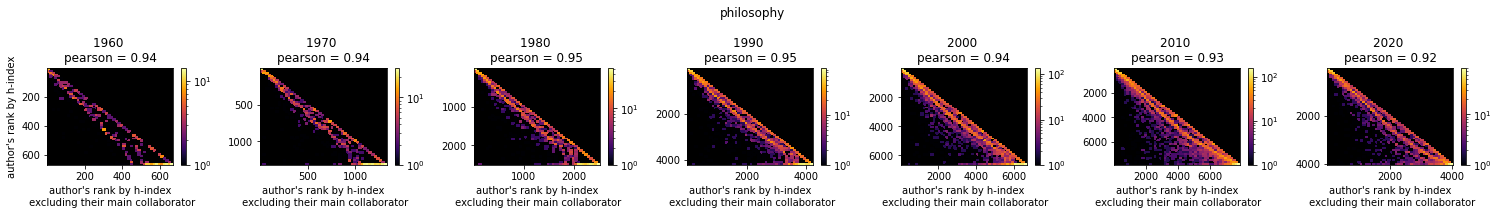

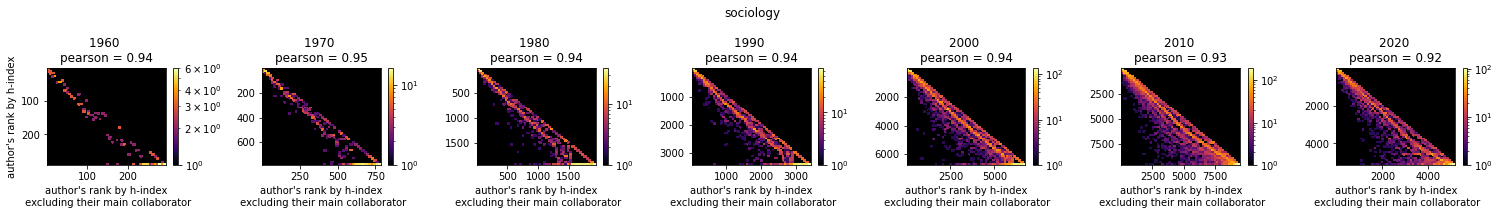

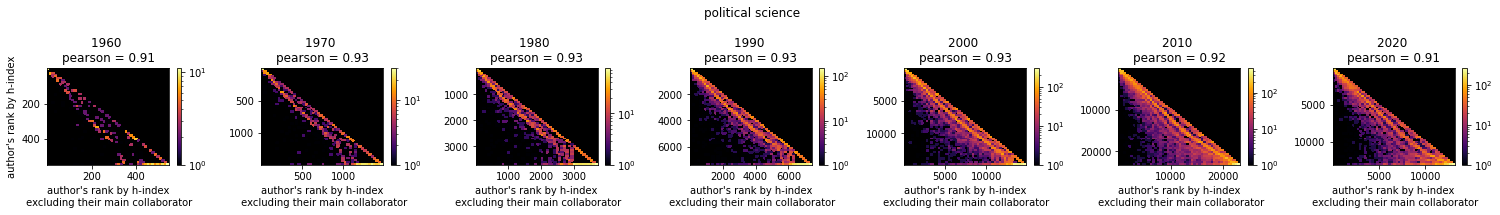

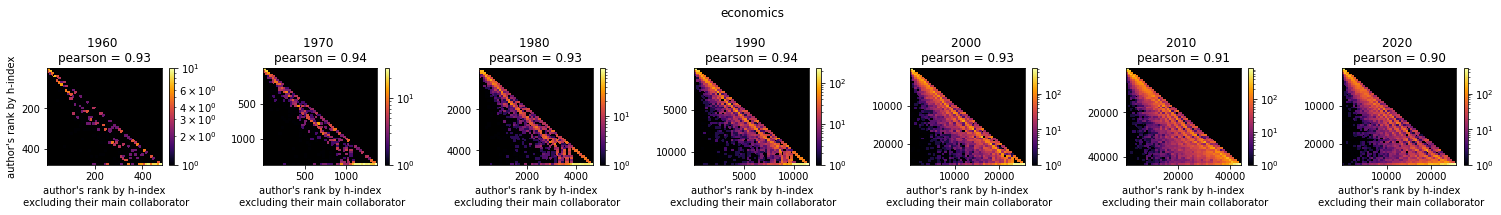

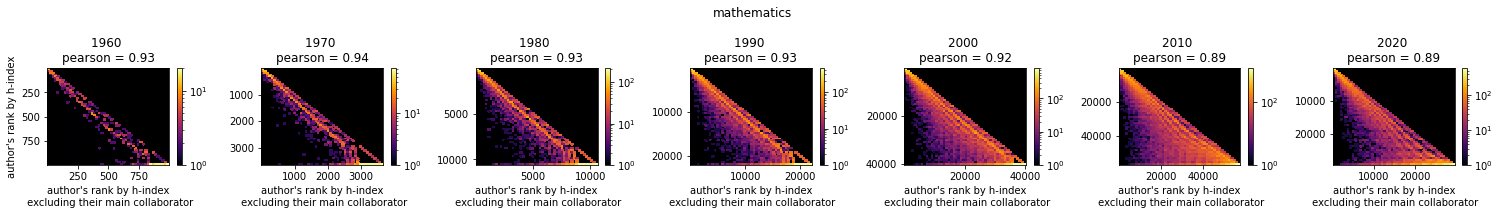

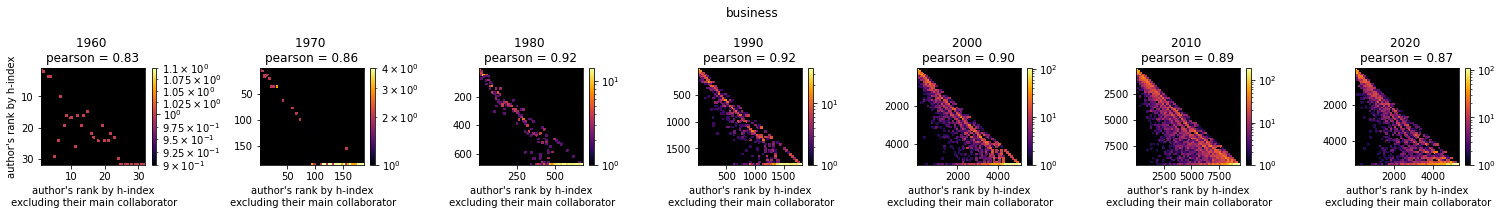

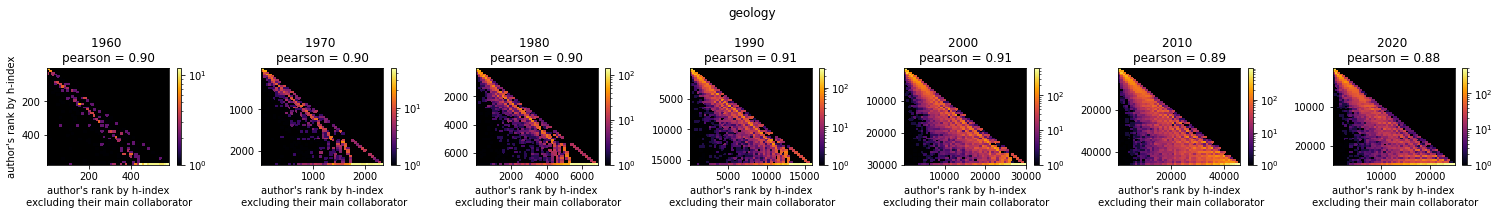

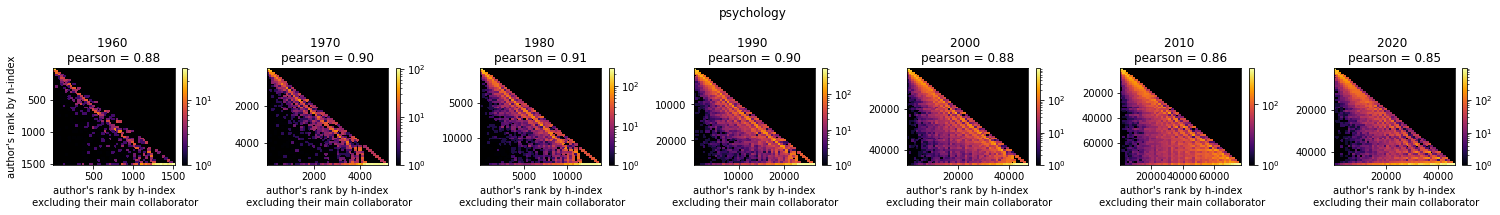

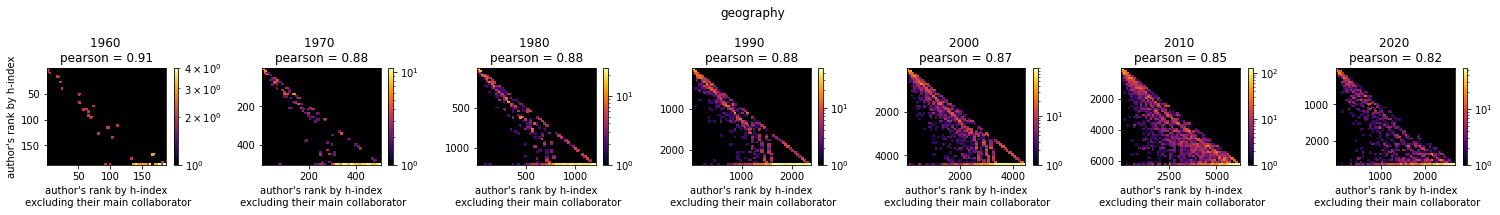

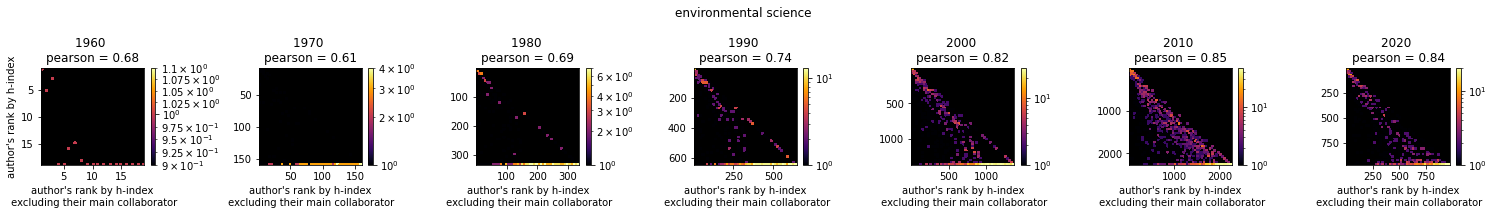

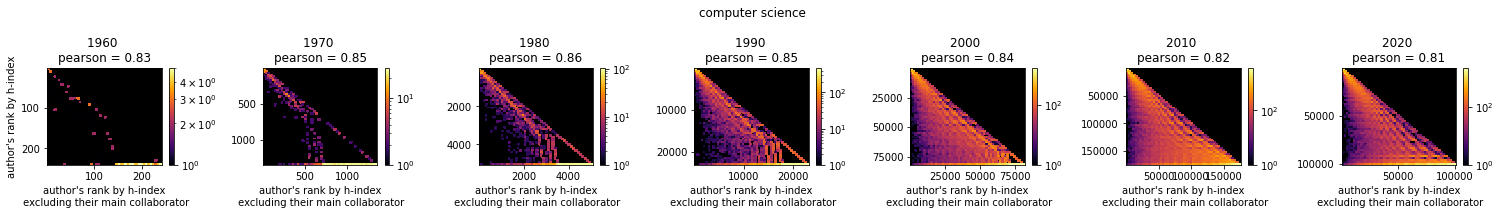

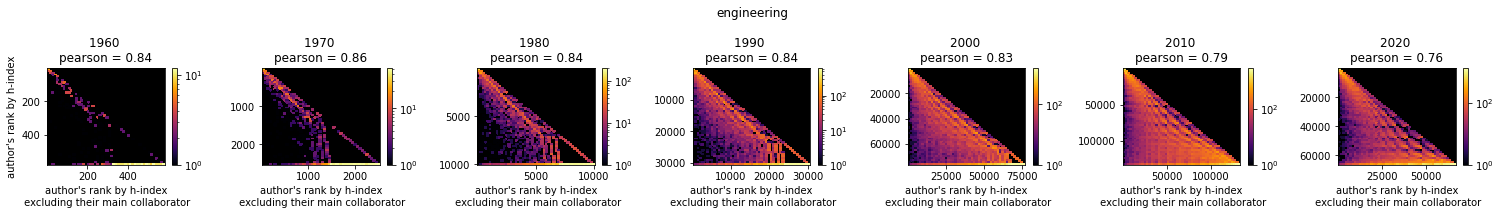

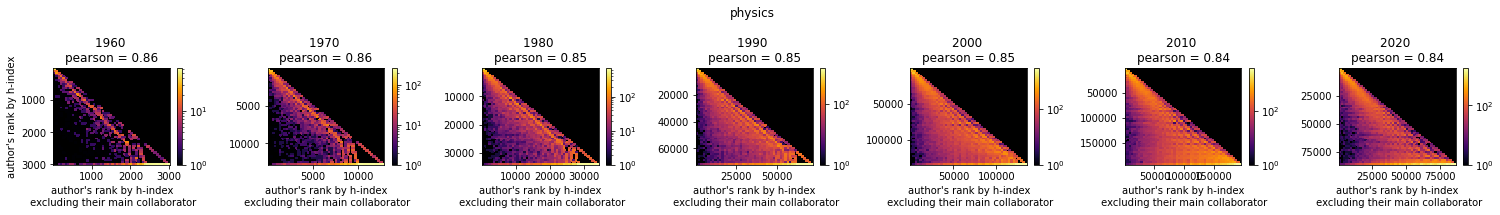

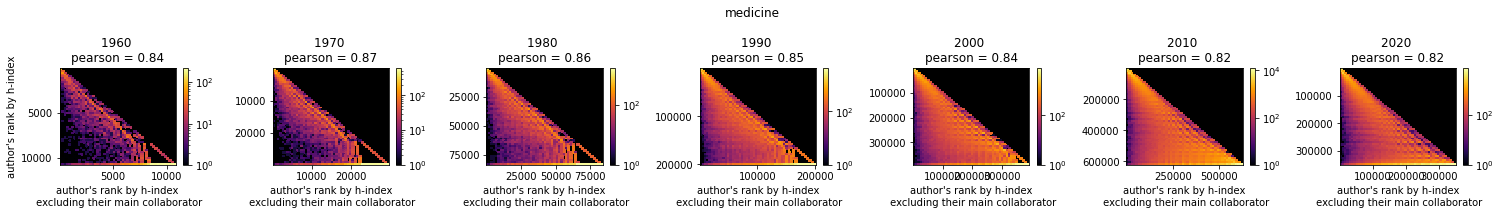

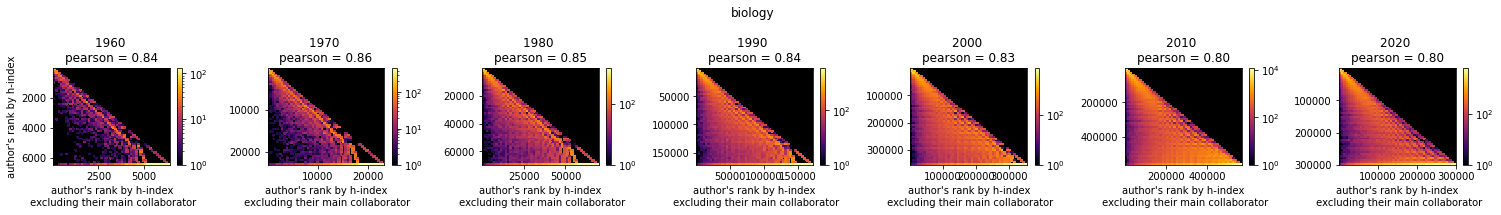

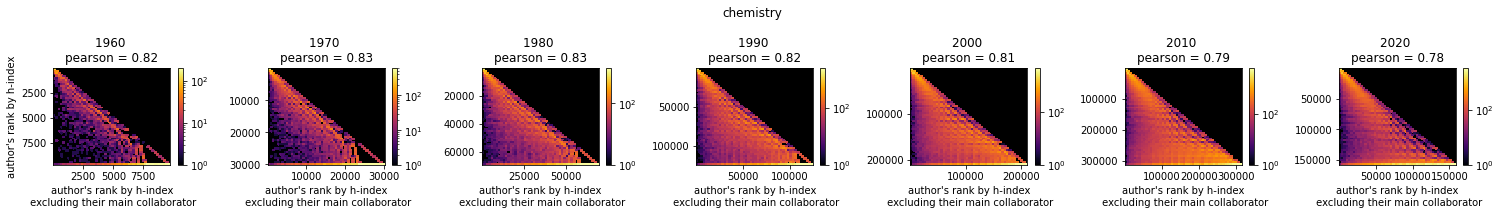

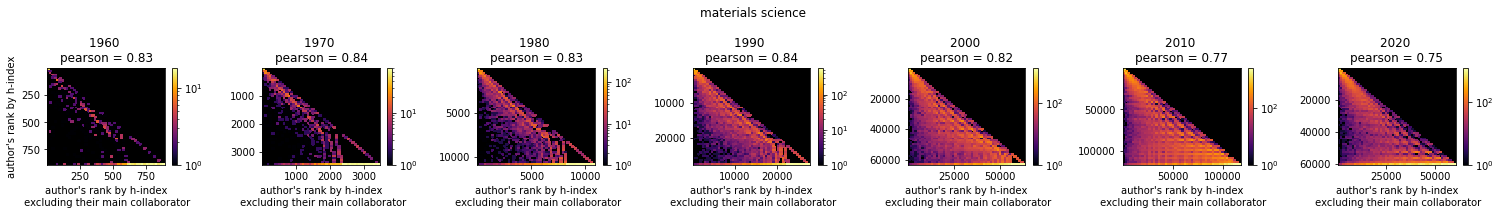

In [21]:
import tqdm
def _plot_rank_temporal(ax, hindex_after, field_name, valid_h_index, valid_citation_list, valid_colabs_cit_list):
    
    neg_hindex = np.array([(-row[0], -row[1], -row[2], i) for i,row in enumerate(valid_h_index)], 
                          dtype=[('my_val1', int), ('my_val2', int), ('my_val3', int), ('my_val4', int)])
    
    neg_hindex_sorted = np.sort(neg_hindex)
    rankbefore = rankdata(neg_hindex, method='ordinal')

    temp = 0
    results = []
    for a,b,c in tqdm.tqdm(zip(neg_hindex, valid_colabs_cit_list, valid_citation_list), total=len(neg_hindex)):
        results.append(get_rank_after(neg_hindex_sorted, a,b,c)) 
    
    ax.set_facecolor("black")
    
    im = ax.hist2d(rankbefore, results, bins=50, cmap='inferno', norm=LogNorm())
    ax.set_title('%s \npearson = %.2f' % (field_name, pearsonr(rankbefore, results)[0]))
    ax.invert_yaxis()
    return im


def _plot_rank_cits_temporal(ax, hindex_after, field_name, valid_citation_list, valid_colabs_cit_list):
    
    neg_hindex = np.array([(-sum(row), i) for i,row in enumerate(valid_citation_list)], 
                          dtype=[('my_val1', int), ('my_val4', int)])
    
    neg_hindex_sorted = np.sort(neg_hindex)
    rankbefore = rankdata(neg_hindex, method='ordinal')

    results = []
    for a,b,c in tqdm.tqdm(zip(neg_hindex, valid_colabs_cit_list, valid_citation_list), total=len(neg_hindex)):
        
        results.append(get_rank_after(neg_hindex_sorted, a, sum(c)-sumb)) 
    
    ax.set_facecolor("black")
    
    im = ax.hist2d(rankbefore, results, bins=50, cmap='inferno', norm=LogNorm())
    ax.set_title('%s \npearson = %.2f' % (field_name, pearsonr(rankbefore, results)[0]))
    ax.invert_yaxis()
    return im



def plot_rank_temporal(hafter_map):

    for field in fos_sorted:
        fig,axes = plt.subplots(figsize=(21, 3), nrows=1, ncols=7)
        for i, tempsuffix in enumerate(range(1960, 2021, 10)):
    
            FOS = np.asarray(json.load(open('results/fos_full_%d.json' % tempsuffix)))
            
            H = np.asarray(json.load(open('results/hindex_full_%d.json' % tempsuffix)))
            X = np.asarray(json.load(open('results/ch_full_%d.json' % tempsuffix)))
            Y = np.asarray(json.load(open('results/citlist_full_%d.json' % tempsuffix)))
            
            idxs = FOS == field
            tempX = X[idxs]
            tempY = Y[idxs]
            tempH = H[idxs]
            
    
            im = _plot_rank_temporal(axes[i], hafter_map[field][tempsuffix], "%d" % tempsuffix,
                                    tempH, tempX, tempY)

            if i == 0: 
                axes[i].set_ylabel('author\'s rank by h-index')
            axes[i].set_xlabel('author\'s rank by h-index\n excluding their main collaborator')

            fig.colorbar(im[3], ax=axes[i])

        
        field_name = fos_infos[fos_infos['field_id'] == field].iloc[0, -1]
            
        fig.suptitle(field_name)
        fig.tight_layout()
        fig.savefig('outputs/fos_hist2d_hrank_%s_temporal.pdf' % field_name)
        fig.show()
    
plot_rank_temporal(hafter_map)
